In [29]:
# Load packages
library(plyr)
library(tidyverse)
library(caret)
library(Hmisc)
library(moments)
library(gbm)
library(gridExtra)
library(repr)
library(glmnet)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.0-2



# **Part 1, Data Preparation**

In [2]:
# Load Kaggle data
train_df <- read_csv("train.csv")
test_df <- read_csv("test.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  Id = col_double(),
  MSSubClass = col_double(),
  LotFrontage = col_double(),
  LotArea = col_double(),
  OverallQual = col_double(),
  OverallCond = col_double(),
  YearBuilt = col_double(),
  YearRemodAdd = col_double(),
  MasVnrArea = col_double(),
  BsmtFinSF1 = col_double(),
  BsmtFinSF2 = col_double(),
  BsmtUnfSF = col_double(),
  TotalBsmtSF = col_double(),
  `1stFlrSF` = col_double(),
  `2ndFlrSF` = col_double(),
  LowQualFinSF = col_double(),
  GrLivArea = col_double(),
  BsmtFullBath = col_double(),
  BsmtHalfBath = col_double(),
  FullBath = col_double()
  # ... with 18 more columns
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  Id = col_double(),
  MS

In [3]:
## function converts ordinal categorical data into rank 
catToRank <- function(df, col, cat, rank) {
   df <- df %>% 
    mutate(col = is.na(get(col)) %>% ifelse("No", get(col)))
  
  newcol <- df$col %>% 
    mapvalues(cat, rank) %>% 
    as.numeric()
  
  return(newcol)   
}

In [7]:
## Impute NA with meanings for all data. Error message means there is not that category, so it can be ignored
## BsmtQual

## bind training and testing sets
all_df <- rbind(train_df %>% select(-SalePrice), test_df)

## NA = No for Alley, GarageType, GarageFinish, Fence, and MiscFeature
all_df <- all_df %>% 
  mutate(Alley = is.na(Alley) %>% ifelse("No", Alley),
         GarageType = is.na(GarageType) %>% ifelse("No", GarageType),
         GarageFinish = is.na(GarageFinish) %>% ifelse("No", GarageFinish),
         Fence = is.na(Fence) %>% ifelse("No", Fence),
         MiscFeature = is.na(MiscFeature) %>% ifelse("No", MiscFeature))

## Convert ordinal categorical data into ranks and impute NAs with rank 0
all_df["BsmtQual"] <- catToRank(all_df, "BsmtQual", c("Ex", "Gd", "TA", "Fa", "Po", "No"), 
                                c(5, 4, 3, 2, 1, 0))
## BsmtCond
all_df["BsmtCond"] <- catToRank(all_df, "BsmtCond", c("Ex", "Gd", "TA", "Fa", "Po", "No"), 
                                c(5, 4, 3, 2, 1, 0))
## BsmtExposure
all_df["BsmtExposure"] <- catToRank(all_df, "BsmtExposure", c("Gd", "Av", "Mn", "No"), 
                                    c(3, 2, 1, 0))
## BsmtFinType1
all_df["BsmtFinType1"] <- catToRank(all_df, "BsmtFinType1", 
                                    c("GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "No"), 
                                    c(6, 5, 4, 3, 2, 1, 0))
## BsmtFinType2
all_df["BsmtFinType2"] <- catToRank(all_df, "BsmtFinType2", 
                                    c("GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "No"), 
                                    c(6, 5, 4, 3, 2, 1, 0))
## FireplaceQu
all_df["FireplaceQu"] <- catToRank(all_df, "FireplaceQu", 
                                    c("Ex", "Gd", "TA", "Fa", "Po", "No"), 
                                    c(5, 4, 3, 2, 1, 0))
## GarageQual
all_df["GarageQual"] <- catToRank(all_df, "GarageQual", 
                                    c("Ex", "Gd", "TA", "Fa", "Po", "No"), 
                                    c(5, 4, 3, 2, 1, 0))
## GarageCond
all_df["GarageCond"] <- catToRank(all_df, "GarageCond", 
                                    c("Ex", "Gd", "TA", "Fa", "Po", "No"), 
                                    c(5, 4, 3, 2, 1, 0))
## PoolQC
all_df["PoolQC"] <- catToRank(all_df, "PoolQC", 
                                    c("Ex", "Gd", "TA", "Fa", "No"), 
                                    c(4, 3, 2, 1, 0))

The following `from` values were not present in `x`: Po

The following `from` values were not present in `x`: Ex

The following `from` values were not present in `x`: TA



In [10]:
## transform the other categorical data that contains no meaningful NAs into Rank data, if they are not OverallQual, OverallCond (they are already rank)

## LandSlope
all_df["LandSlope"] <- catToRank(all_df, "LandSlope", 
                                    c("Gtl", "Mod", "Sev"), 
                                    c(0, 1, 2))

## GarageYrBlt has a mistake, year cannot be > 2019, record printed
all_df %>% 
  select(Id, GarageYrBlt) %>% 
  filter(GarageYrBlt > 2019)
## fill it with YearBuilt of that house
all_df[2593, 'GarageYrBlt'] <- all_df[2593, 'YearBuilt']

## YearBuilt, change to age, remove the original column
all_df <- all_df %>% 
  dplyr::mutate(Age = 2019 - YearBuilt) %>% 
  select(-YearBuilt)

## GarageYrBlt change to GarageAge
all_df <- all_df %>% 
  dplyr::mutate(GarageAge = 2019 - GarageYrBlt) %>% 
  select(-GarageYrBlt)

## YearRemodAdd, change to difference between 2019 and YearRemodAdd
all_df <- all_df %>% 
  dplyr::mutate(YearRemodAdd = 2019 - YearRemodAdd)

## ExterQual
all_df["ExterQual"] <- catToRank(all_df, "ExterQual", 
                                    c("Ex", "Gd", "TA", "Fa", "Po"), 
                                    c(4, 3, 2, 1, 0))
## ExterCond
all_df["ExterCond"] <- catToRank(all_df, "ExterCond", 
                                    c("Ex", "Gd", "TA", "Fa", "Po"), 
                                    c(4, 3, 2, 1, 0))

## HeatingQC
all_df["HeatingQC"] <- catToRank(all_df, "HeatingQC", 
                                    c("Ex", "Gd", "TA", "Fa", "Po"), 
                                    c(4, 3, 2, 1, 0))

## KitchenQual, “NAs introduced by coercion” error, because it contains NA, and this NA stands for missing value, it is converted back to NA by as.numeric() and will be imputed next step
all_df["KitchenQual"] <- catToRank(all_df, "KitchenQual", 
                                    c("Ex", "Gd", "TA", "Fa", "Po"), 
                                    c(4, 3, 2, 1, 0)) %>% as.numeric()

Id,GarageYrBlt
<dbl>,<dbl>
2593,2207


The following `from` values were not present in `x`: Po

The following `from` values were not present in `x`: Po

Warning message in function_list[[k]](value):
“NAs introduced by coercion”


In [11]:
## Meanful NA impuated dataset, ratio of NA for each variable, LotFrontage has the most NAs, but only 16%, keep all variables
all_df %>% 
  is.na() %>% 
  colMeans() %>% 
  sort(decreasing = TRUE) %>% 
  head()

LotFrontage    GarageAge   MasVnrType   MasVnrArea     MSZoning    Utilities 
0.1664953751 0.0544707091 0.0082219938 0.0078794108 0.0013703323 0.0006851662

In [12]:
## MSSubClass should be category instead of number
all_df <- all_df %>% 
  dplyr::mutate(MSSubClass = MSSubClass %>% as.character())

$Id
[1] 2919

$MSSubClass120
[1] 1

$MSSubClass20
[1] 1

$MSSubClass50
[1] 1

$MSSubClass60
[1] 1

$MSZoningRL
[1] 1

$MSZoningRM
[1] 1

$LotFrontage
[1] 5.749393

$LotArea
[1] 12.27954

$AlleyNo
[1] 1

$LotShapeIR1
[1] 1

$LotShapeReg
[1] 1

$LandContourLvl
[1] 1

$LotConfigCorner
[1] 1

$LotConfigCulDSac
[1] 1

$LotConfigInside
[1] 1

$NeighborhoodCollgCr
[1] 1

$NeighborhoodEdwards
[1] 1

$NeighborhoodGilbert
[1] 1

$NeighborhoodNAmes
[1] 1

$NeighborhoodNridgHt
[1] 1

$NeighborhoodOldTown
[1] 1

$NeighborhoodSawyer
[1] 1

$NeighborhoodSomerst
[1] 1

$Condition1Feedr
[1] 1

$Condition1Norm
[1] 1

$BldgType1Fam
[1] 1

$BldgTypeTwnhsE
[1] 1

$HouseStyle1.5Fin
[1] 1

$HouseStyle1Story
[1] 1

$HouseStyle2Story
[1] 1

$OverallQual
[1] 10

$OverallCond
[1] 9

$YearRemodAdd
[1] 69

$RoofStyleGable
[1] 1

$RoofStyleHip
[1] 1

$Exterior1stHdBoard
[1] 1

$Exterior1stMetalSd
[1] 1

$Exterior1stPlywood
[1] 1

$Exterior1stVinylSd
[1] 1

$`Exterior1stWd Sdng`
[1] 1

$Exterior2ndHdBoard
[1] 1

$Exterior2ndMetalSd
[1] 1

$Exterior2ndPlywood
[1] 1

$Exterior2ndVinylSd
[1] 1

$`Exterior2ndWd Sdng`
[1] 1

$MasVnrTypeBrkFace
[1] 1

$MasVnrTypeNone
[1] 1

$MasVnrTypeStone
[1] 1

$MasVnrArea
[1] 7.378384

$ExterQual
[1] 1.609438

$ExterCond
[1] 1.609438

$FoundationBrkTil
[1] 1

$FoundationCBlock
[1] 1

$FoundationPConc
[1] 1

$BsmtQual
[1] 5

$BsmtExposure
[1] 1.386294

$BsmtFinType1
[1] 6

$BsmtFinSF1
[1] 8.638525

$BsmtUnfSF
[1] 2336

$TotalBsmtSF
[1] 6110

$HeatingQC
[1] 4

$CentralAirN
[1] 1

$CentralAirY
[1] 1

$ElectricalFuseA
[1] 1

$ElectricalSBrkr
[1] 1

$``1stFlrSF``
[1] 8.536211

$``2ndFlrSF``
[1] 7.63337

$GrLivArea
[1] 8.638171

$BsmtFullBath
[1] 1.386294

$BsmtHalfBath
[1] 1.098612

$FullBath
[1] 4

$HalfBath
[1] 1.098612

$BedroomAbvGr
[1] 8

$KitchenQual
[1] 4

$TotRmsAbvGrd
[1] 2.772589

$FunctionalTyp
[1] 1

$Fireplaces
[1] 1.609438

$FireplaceQu
[1] 5

$GarageTypeAttchd
[1] 1

$GarageTypeBuiltIn
[1] 1

$GarageTypeDetchd
[1] 1

$GarageTypeNo
[1] 1

$GarageFinishFin
[1] 1

$GarageFinishNo
[1] 1

$GarageFinishRFn
[1] 1

$GarageFinishUnf
[1] 1

$GarageCars
[1] 5

$GarageArea
[1] 1488

$GarageQual
[1] 5

$GarageCond
[1] 5

$PavedDriveN
[1] 1

$PavedDriveY
[1] 1

$WoodDeckSF
[1] 7.261927

$FenceMnPrv
[1] 1

$FenceNo
[1] 1

$MoSold
[1] 12

$YrSold
[1] 2010

$SaleTypeNew
[1] 1

$SaleTypeWD
[1] 1

$SaleConditionAbnorml
[1] 1

$SaleConditionNormal
[1] 1

$SaleConditionPartial
[1] 1

$Age
[1] 4.997212

$GarageAge
[1] 4.828314

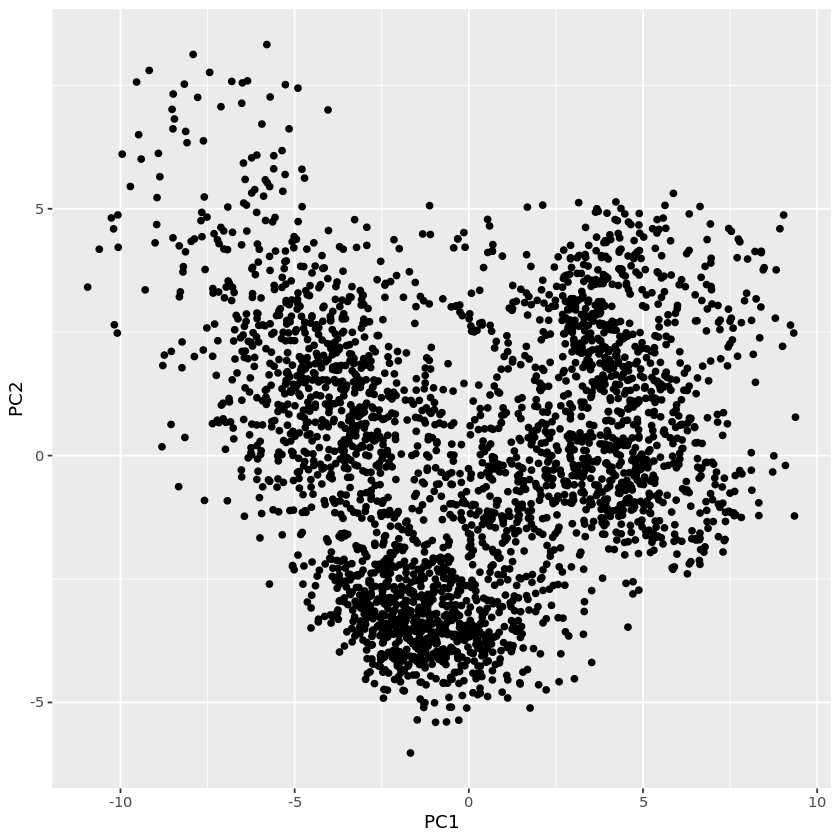

In [13]:
## Categorical data into dummy variables, impute NA with median
all_dummy <- dummyVars(~ ., data = all_df) %>% 
  predict(newdata = all_df) %>% 
  as.data.frame()
all_dummy <- preProcess(all_dummy, "medianImpute") %>%
  predict(all_dummy)

## remove variables with low variance
all_dummy <- all_dummy %>% select(-nzv(all_dummy))

## get variables that might need to be log transformed (skewness > 0.5)
trans <- ((skewness(all_dummy) %>% abs()) > 0.5) %>% which()

## get variables that log transformation improves their skewness
all_dummy_temp <- all_dummy
all_dummy_temp[, trans] <- log(all_dummy[, trans] + 1)
log_index <- (abs(skewness(all_dummy)) - abs(skewness(all_dummy_temp)) > 0.1) %>% which()
## log transform these variables
all_dummy[, log_index] <- log(all_dummy[, log_index] + 1) 

## Get additional features need to be transformed (ones not at the same scale as others) by checking the range of each variable
lapply(all_dummy, range) %>% lapply(max) 

## Tranformed BsmtUnfSF, TotalBsmtSF, GarageArea, YrSold, as their ranges are largely different from other variables
all_dummy <- all_dummy %>% 
  mutate(BsmtUnfSF = log(BsmtUnfSF + 1),
         GarageArea = log(GarageArea + 1),
         YrSold = log(2019 - YrSold + 1),
         TotalBsmtSF = log(TotalBsmtSF + 1))

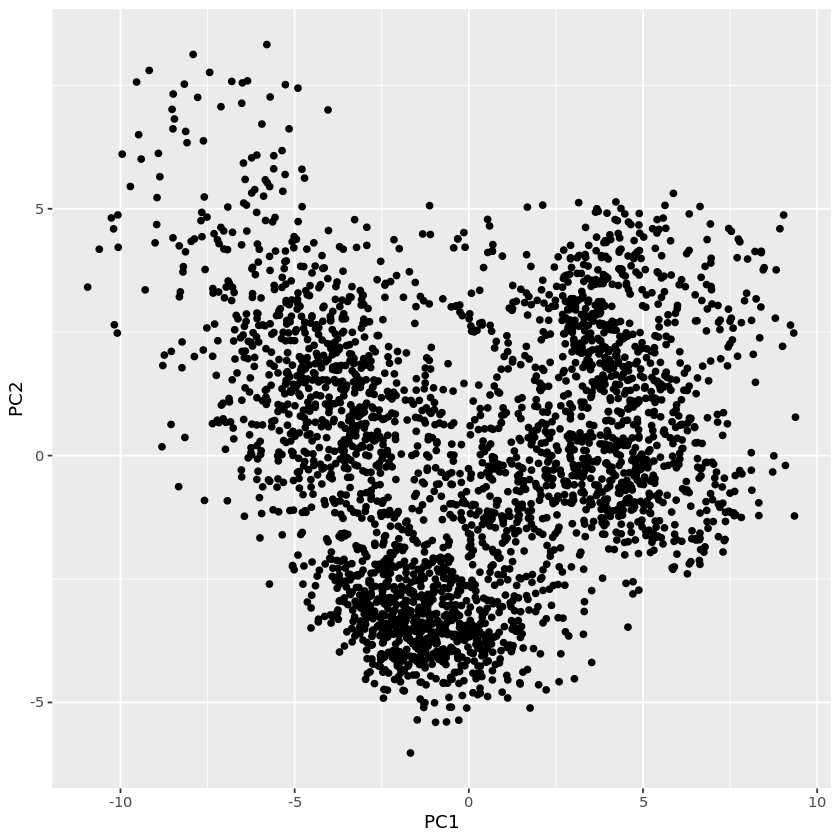

In [14]:
## Visual inspection for potential samples that are extremely different from others using PCA, didn't see one
pc <- prcomp(all_dummy[, -1], center = TRUE, scale. = TRUE)
ggplot(data.frame(pc$x), aes(PC1, PC2)) + geom_point()

In [15]:
## split train and test set and look for outliners
train_ready <- all_dummy %>% 
  filter(Id <= 1460)

train_ready['LogSalePrice'] <- log(train_df$SalePrice)

test_ready <- all_dummy %>% 
  filter(Id > 1460) %>% 
  select(-Id)

colnames(train_ready) <- make.names(colnames(train_ready))
colnames(test_ready) <- make.names(colnames(test_ready))

mean_sale,median_sale,sd_sale
<dbl>,<dbl>,<dbl>
180921.2,163000,79442.5


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



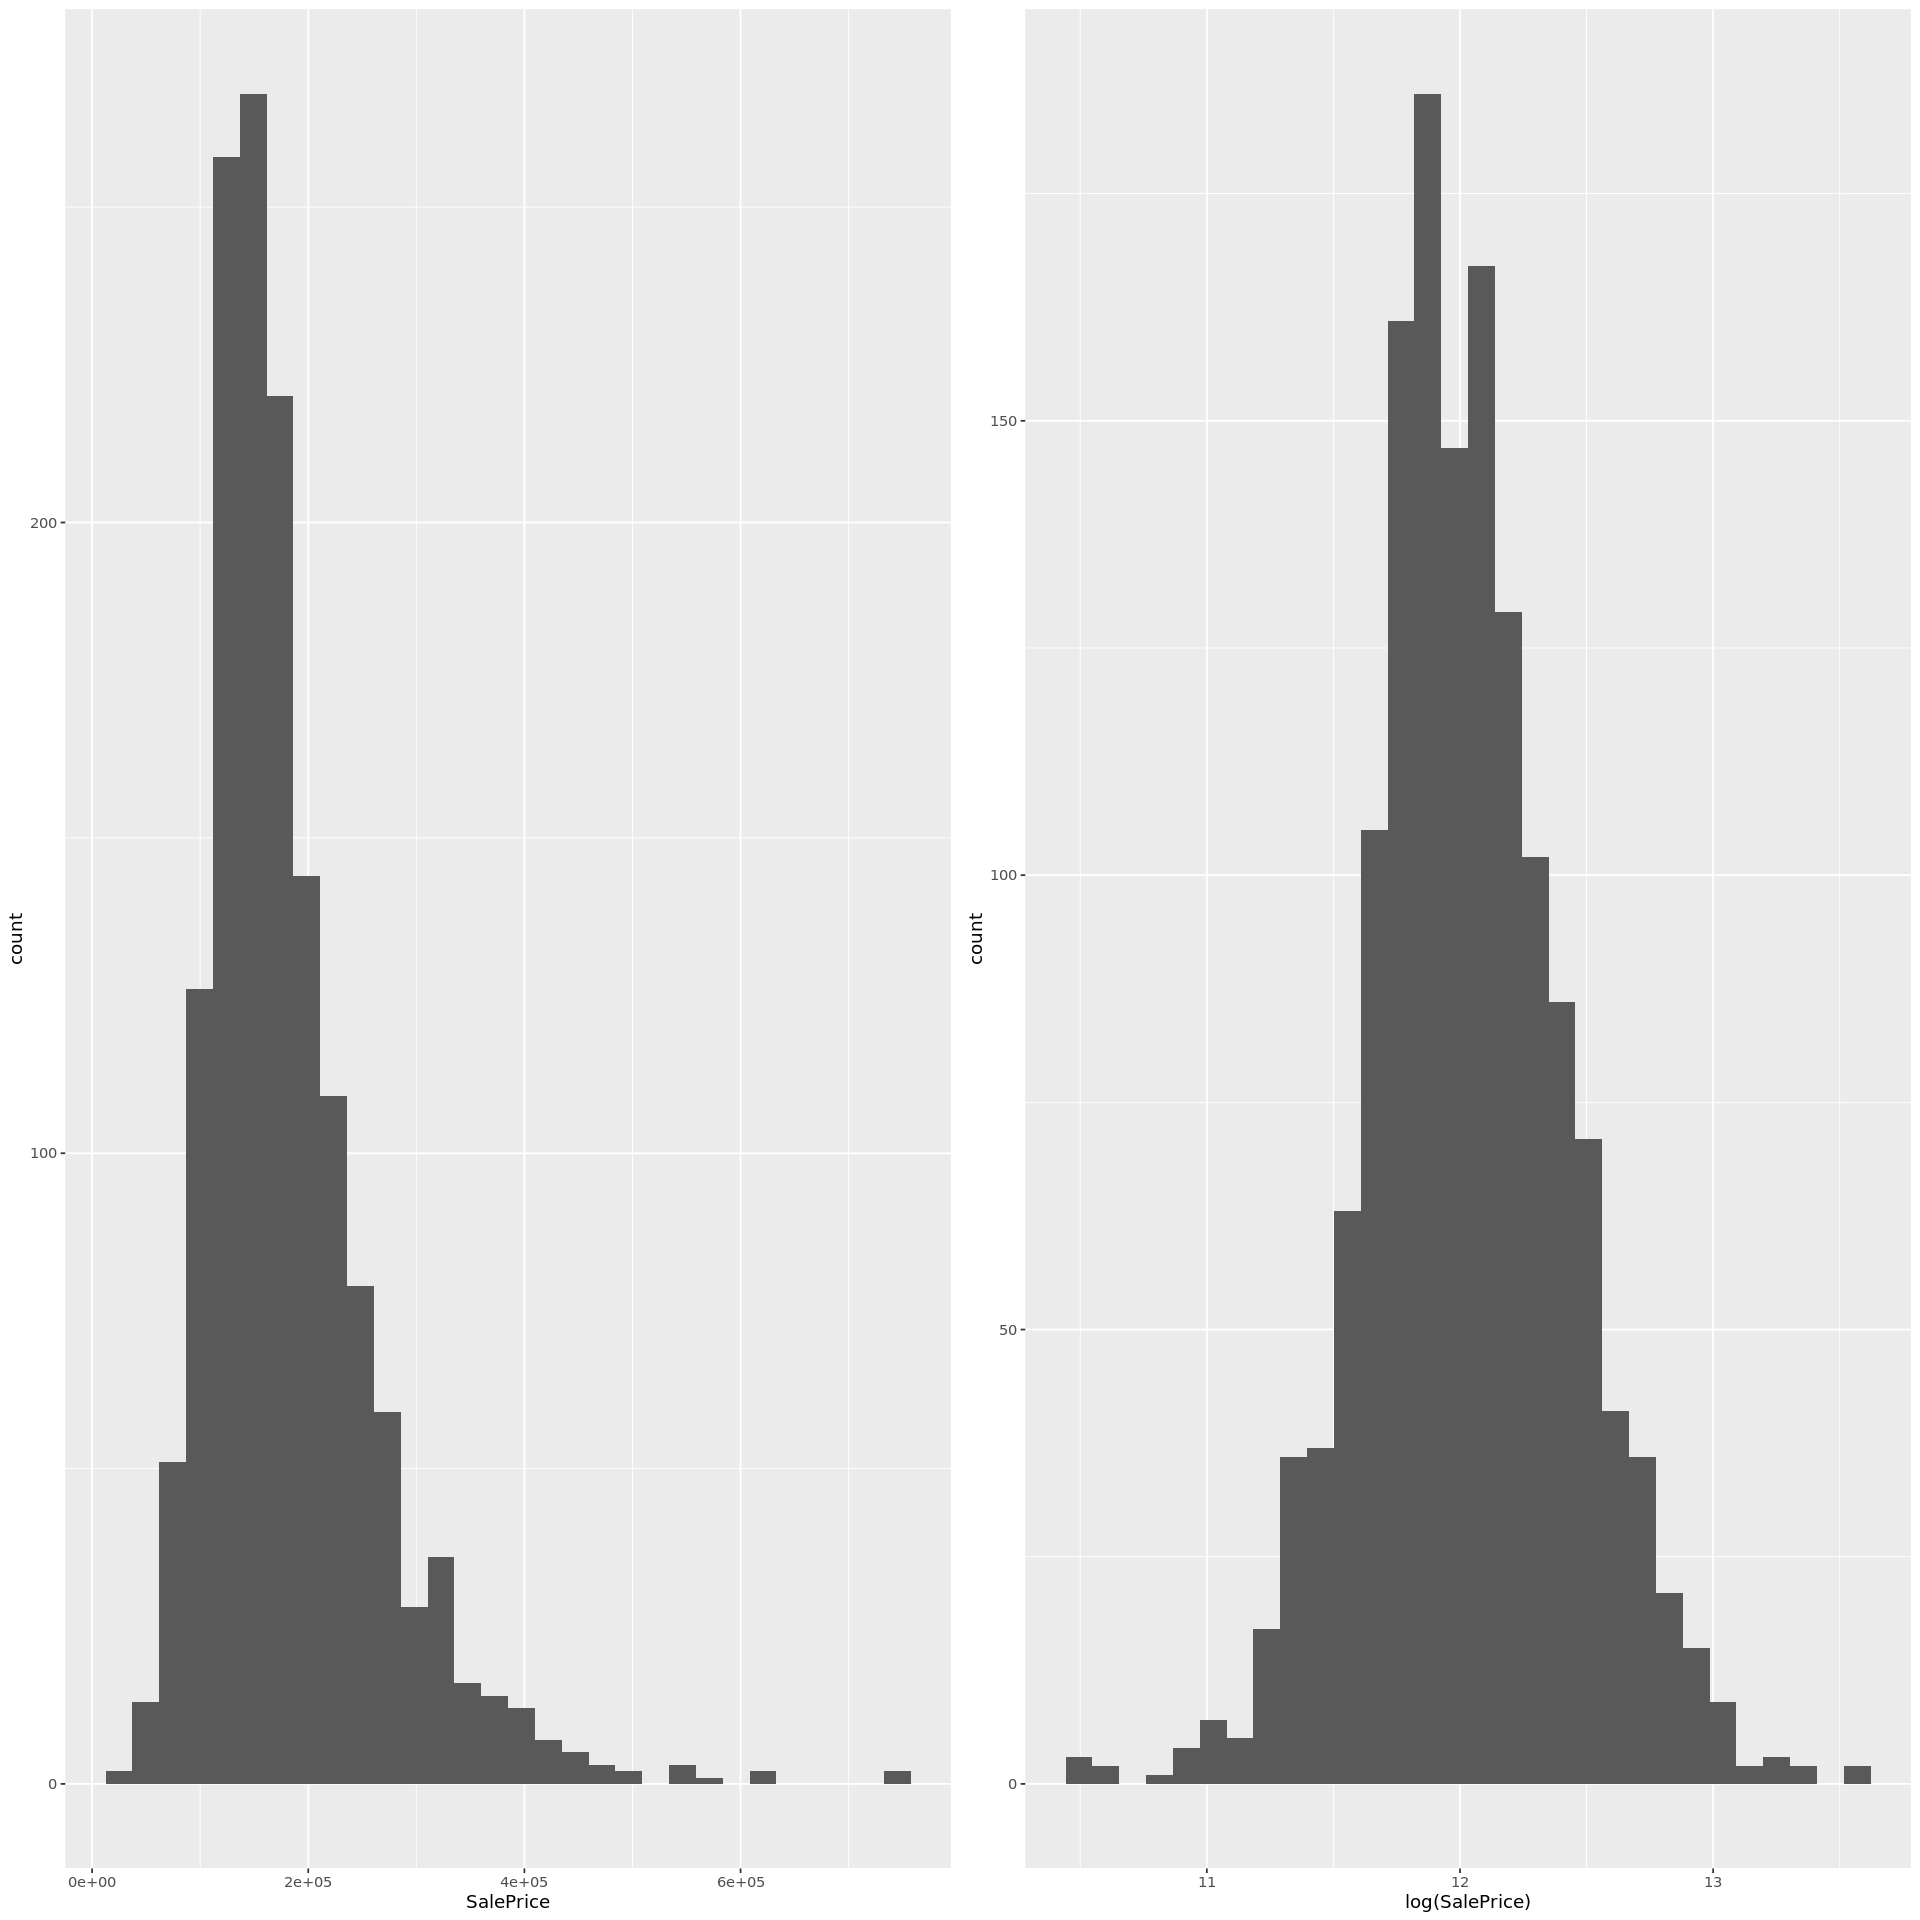

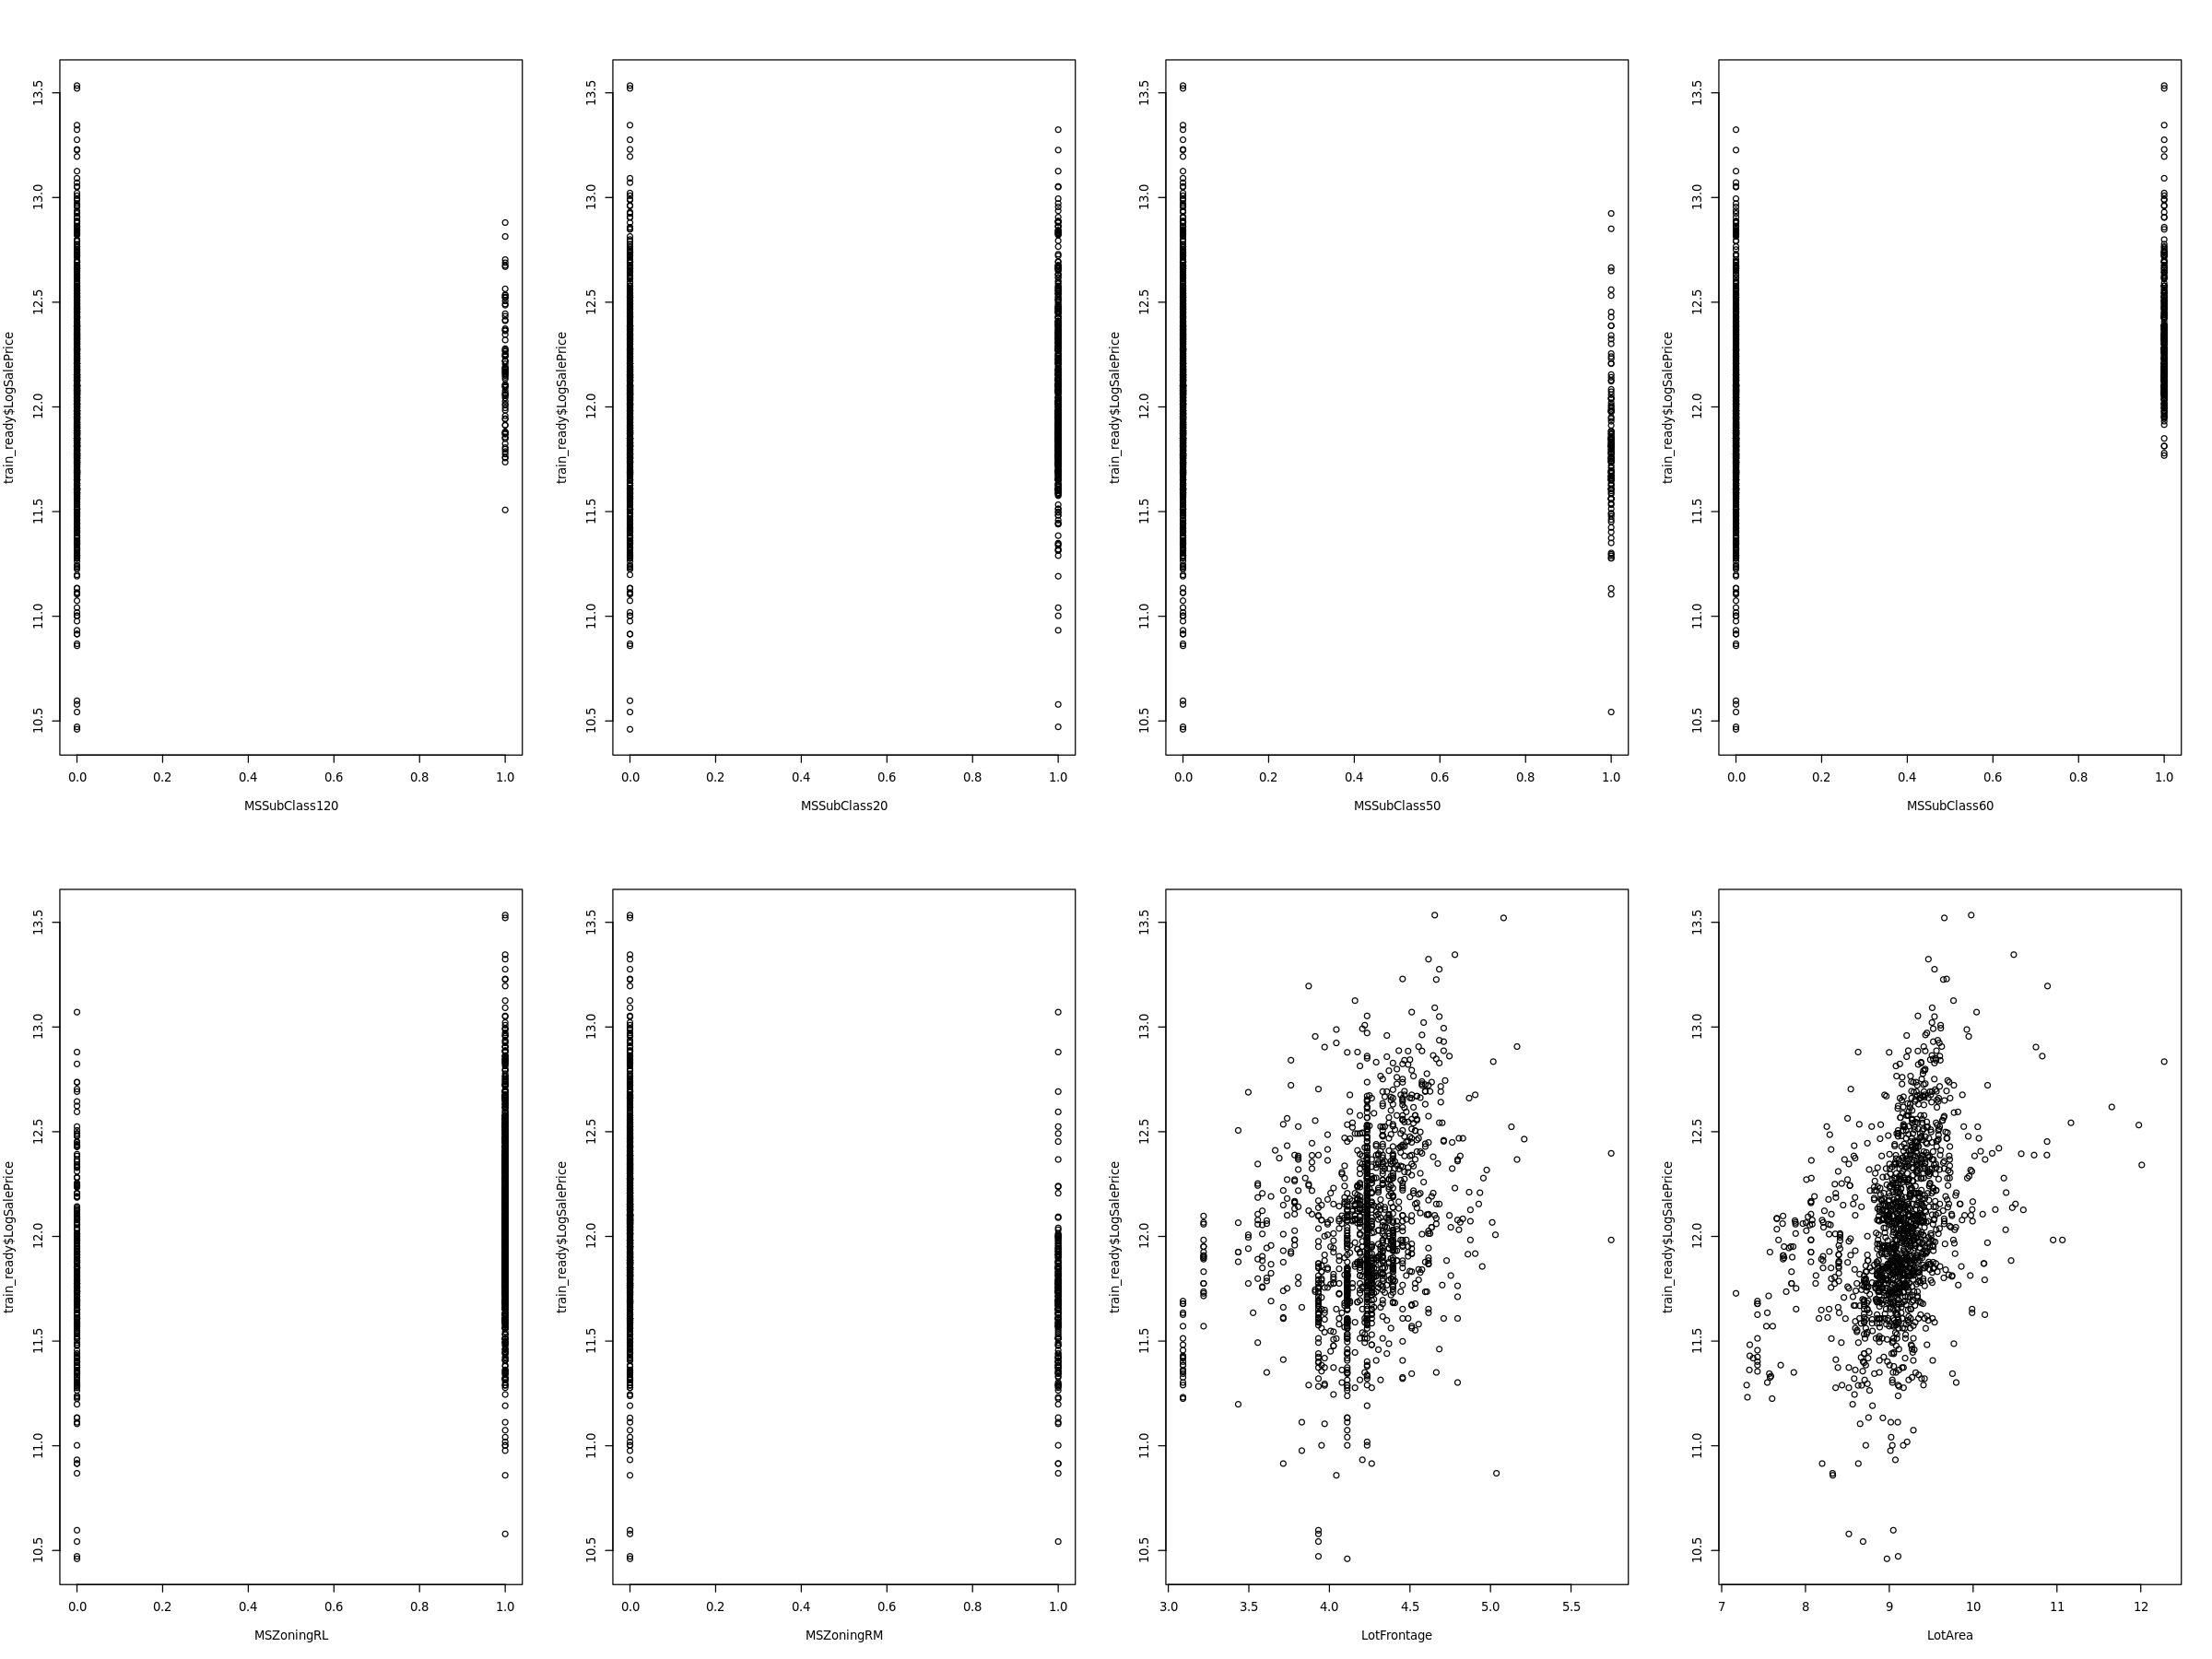

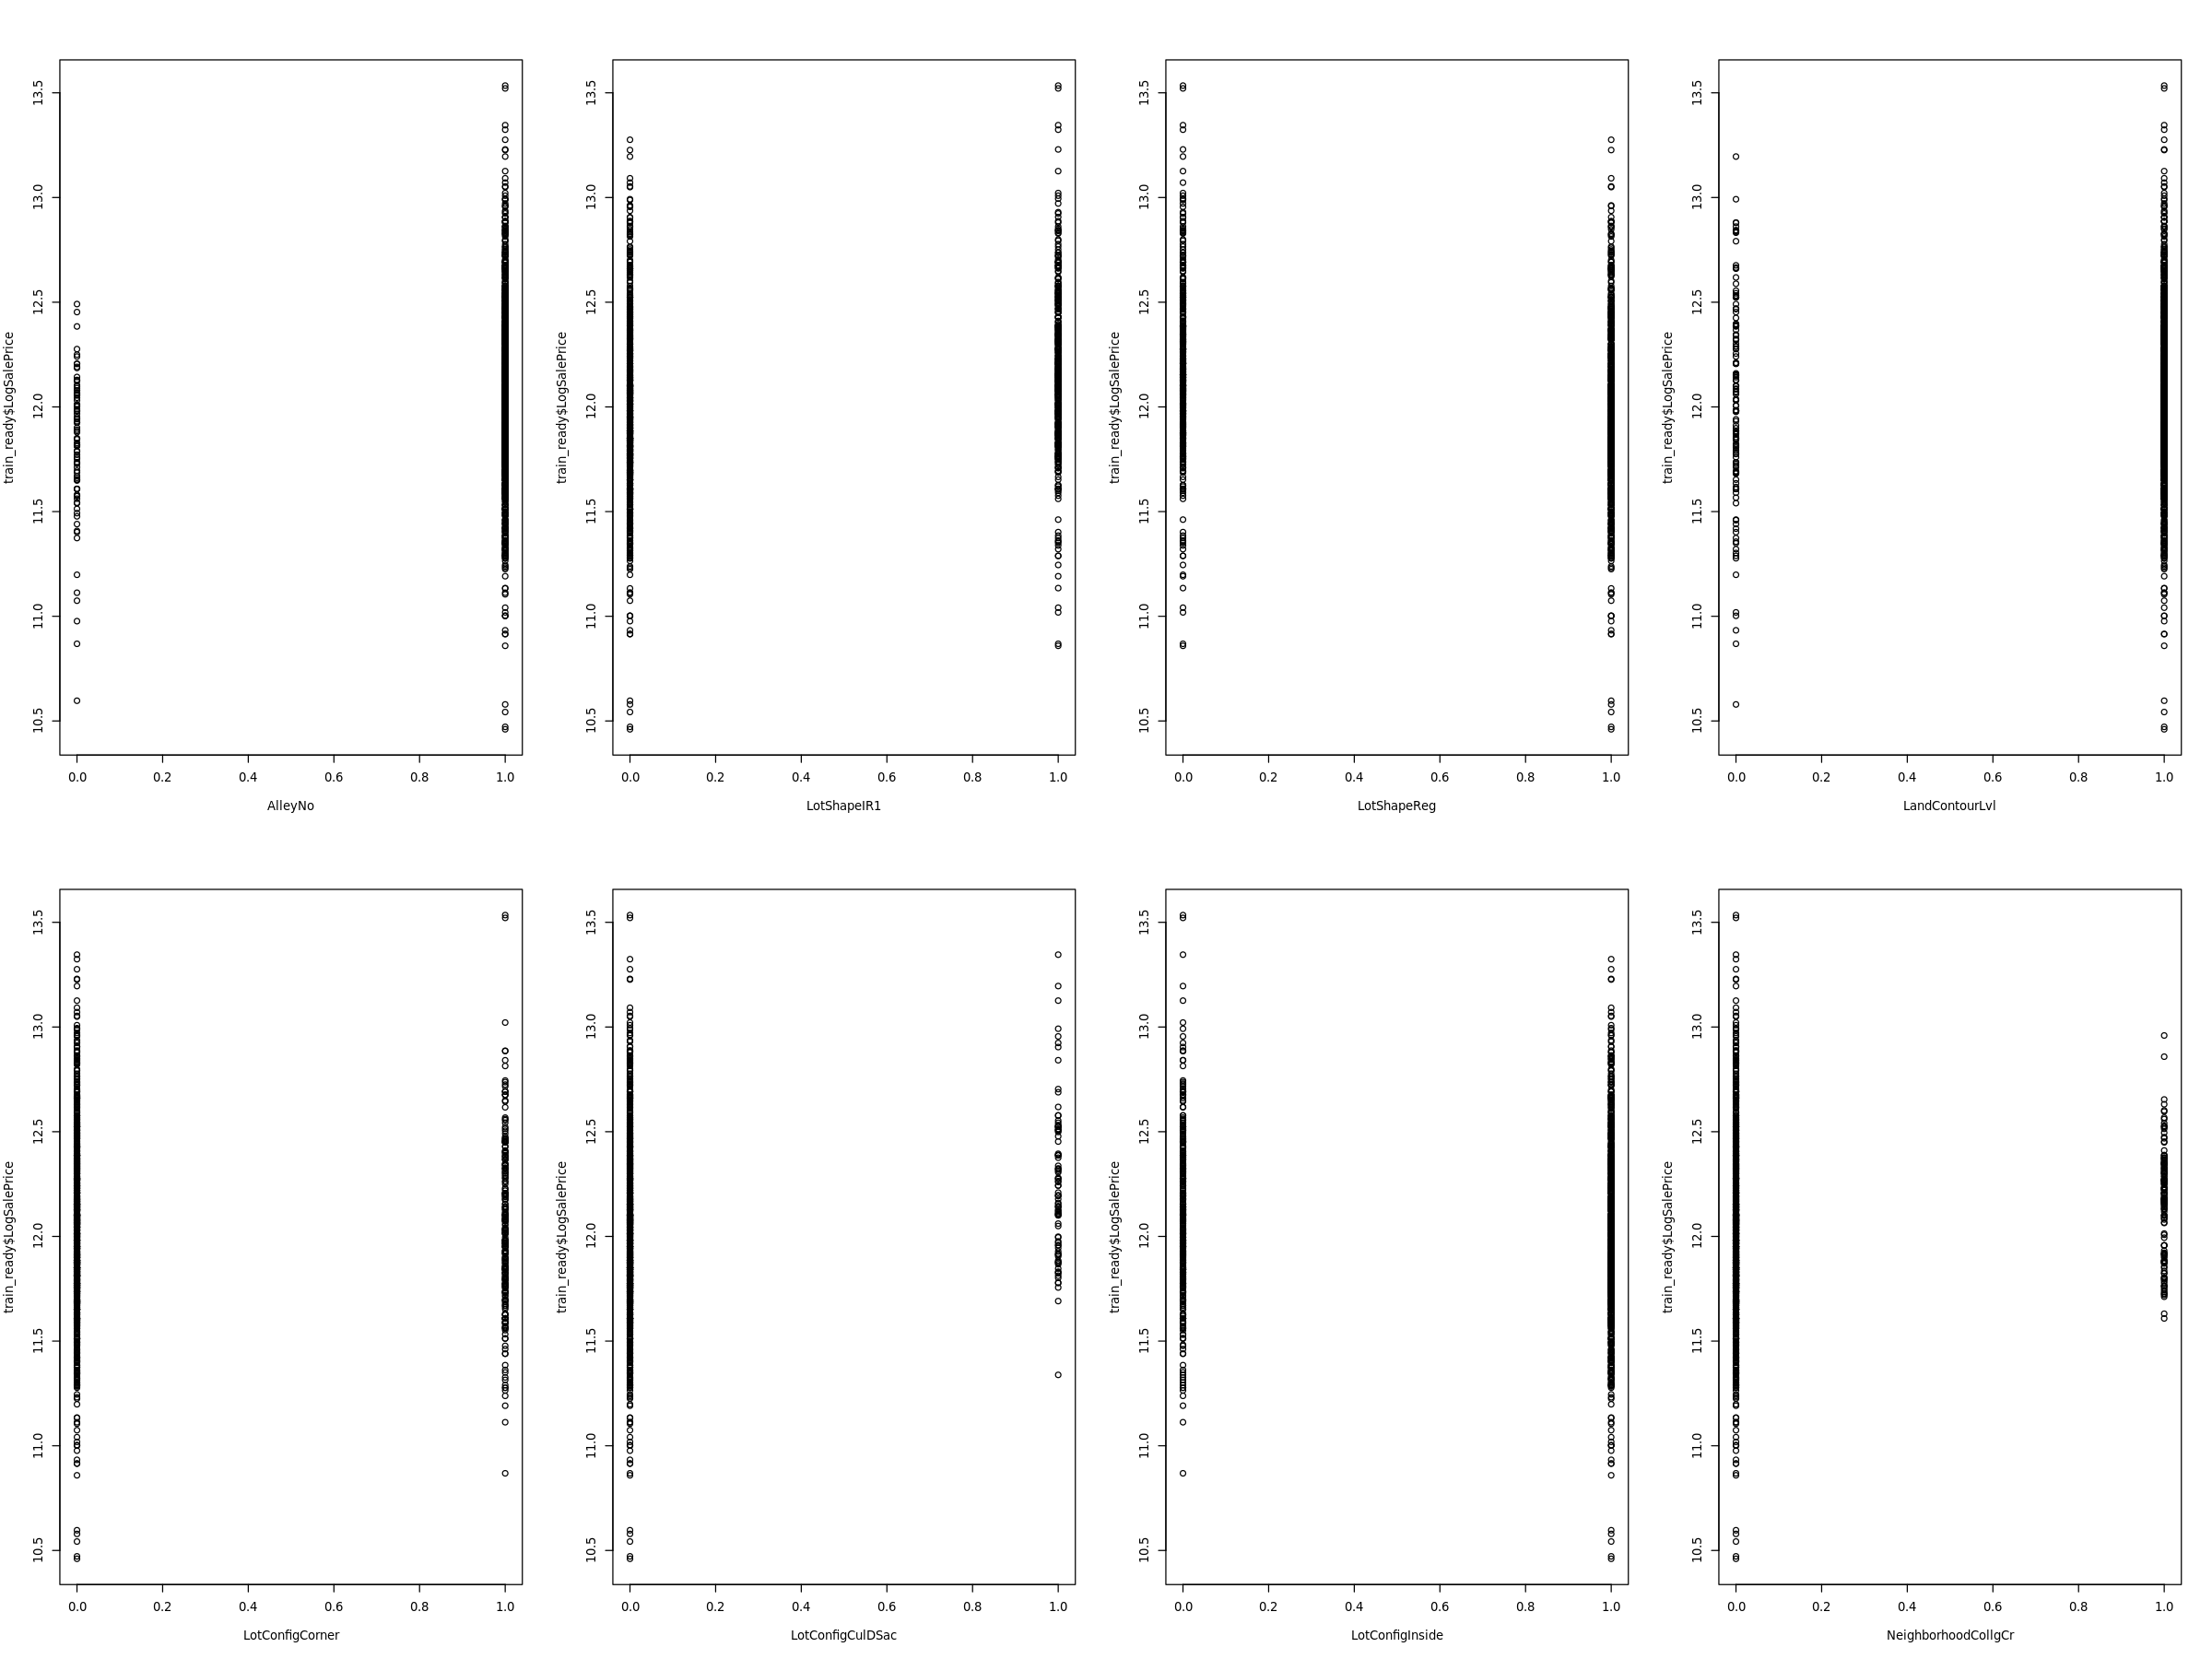

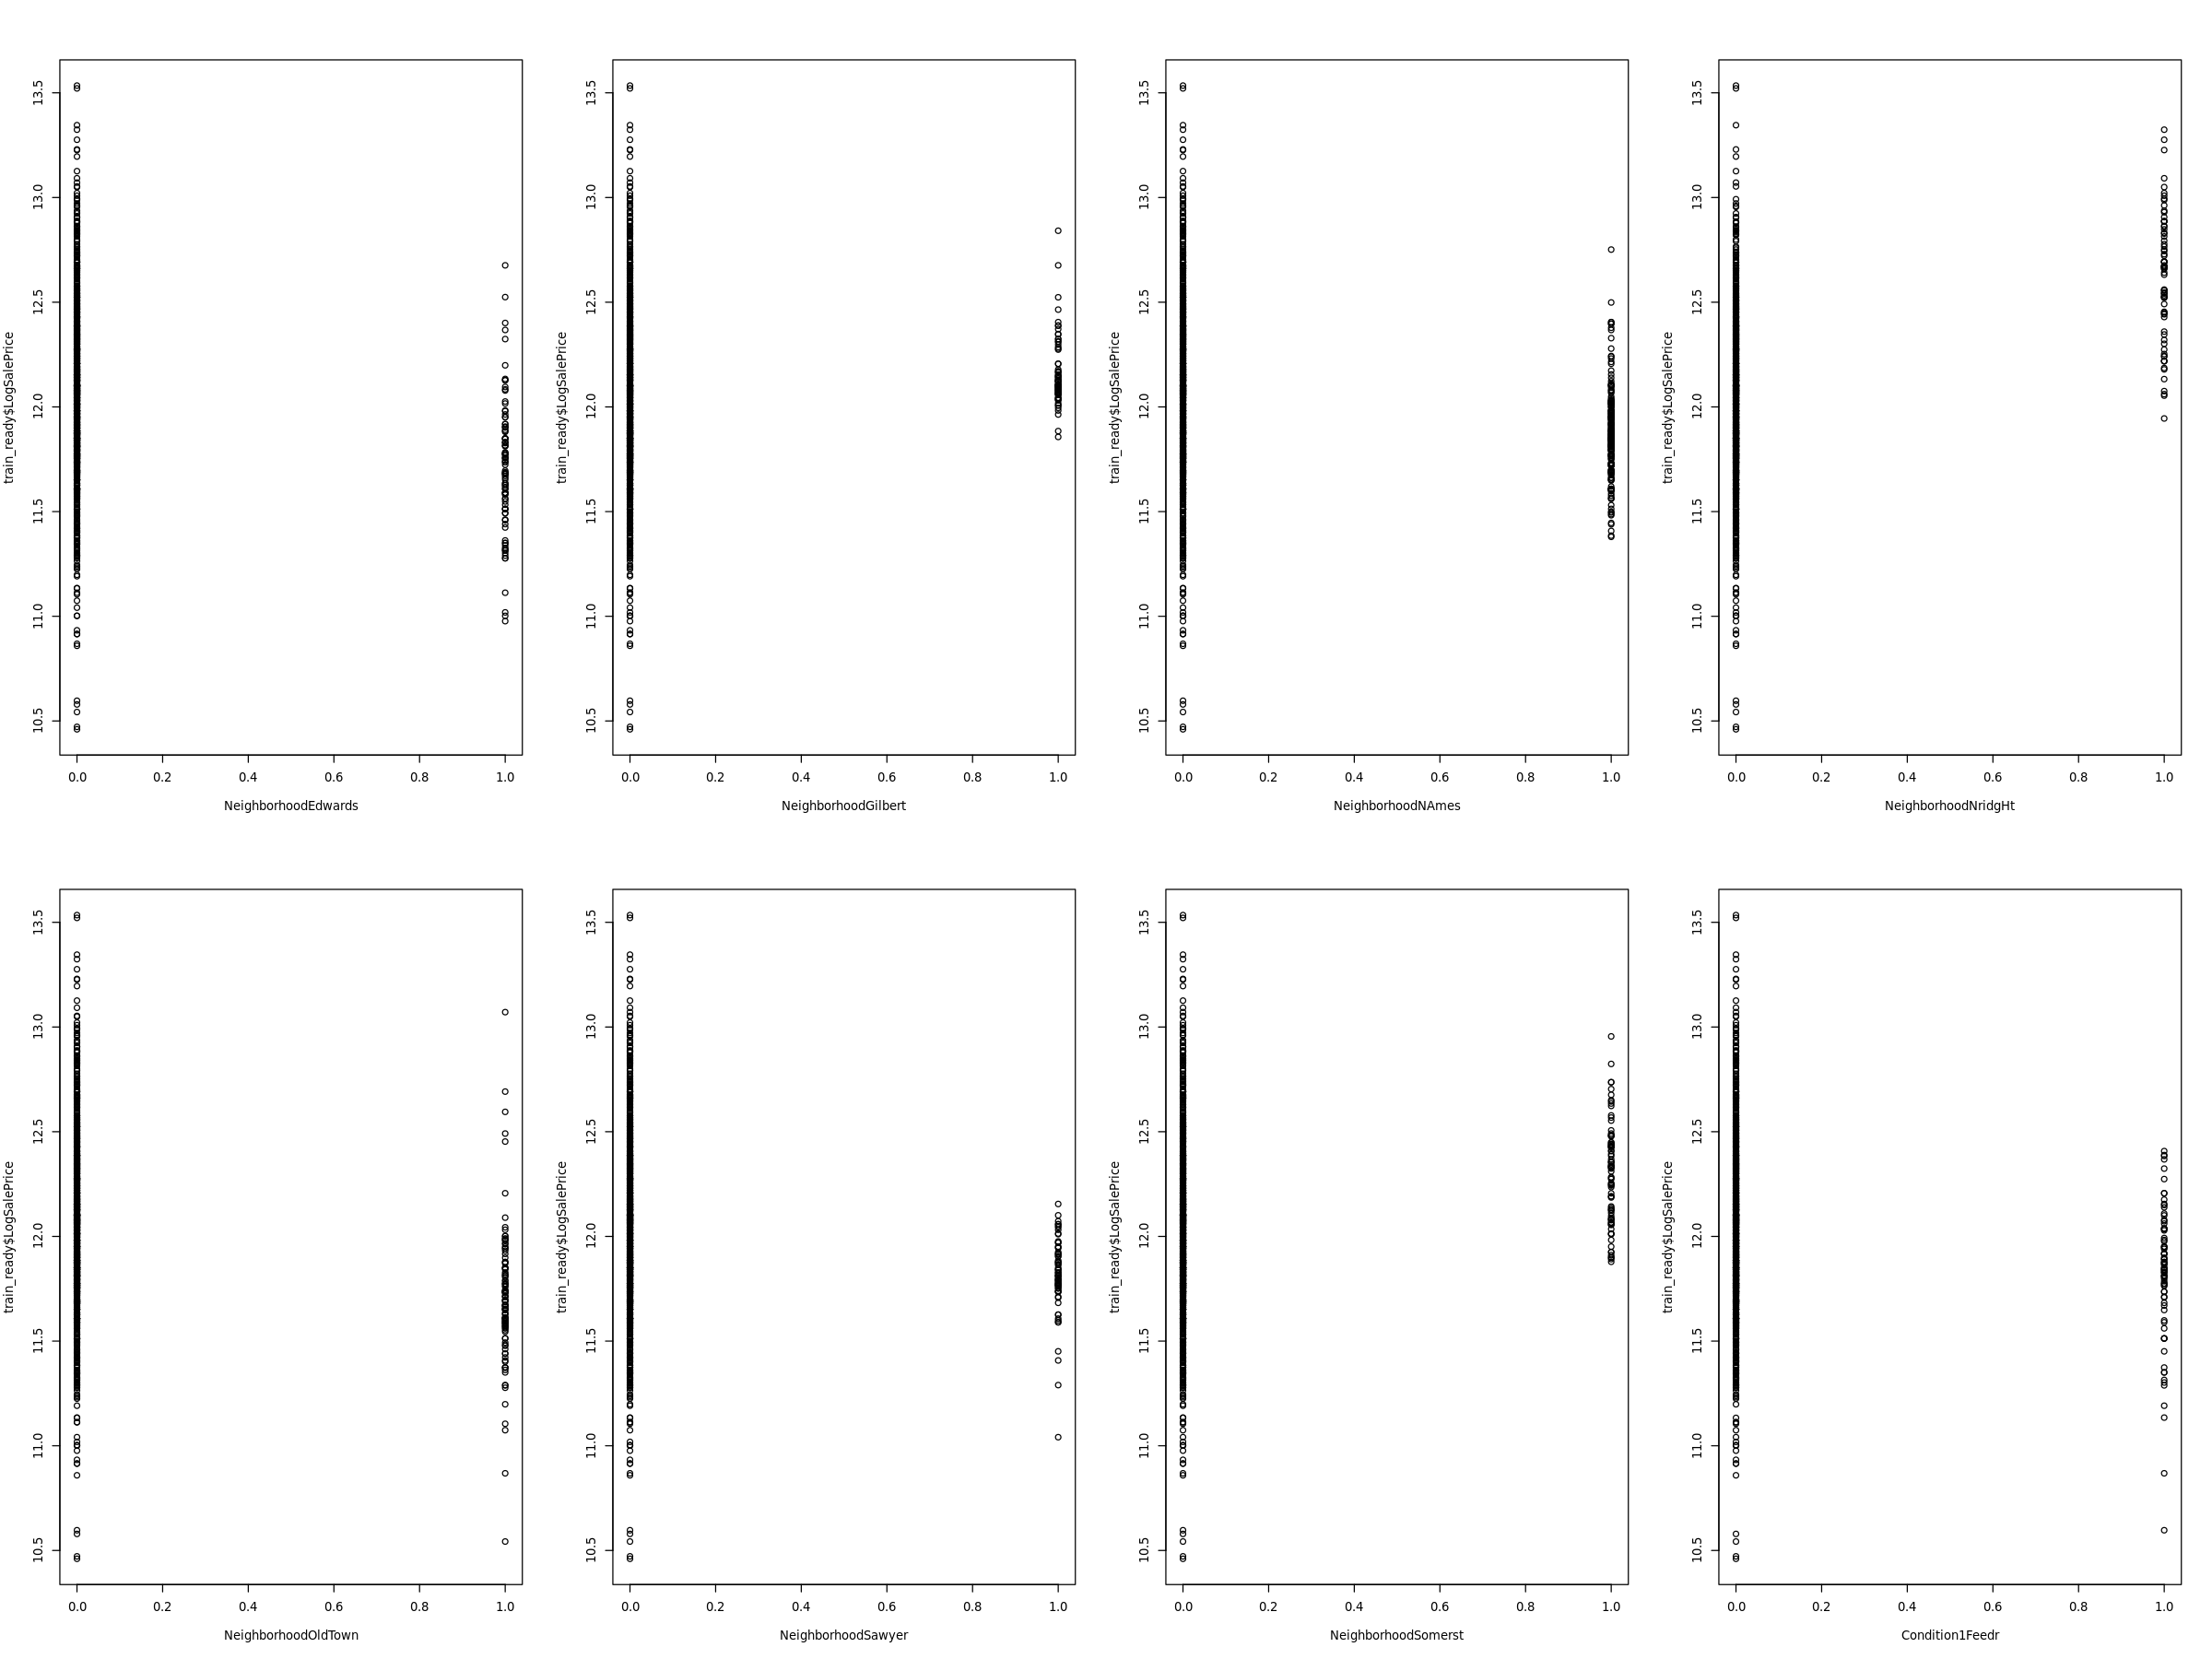

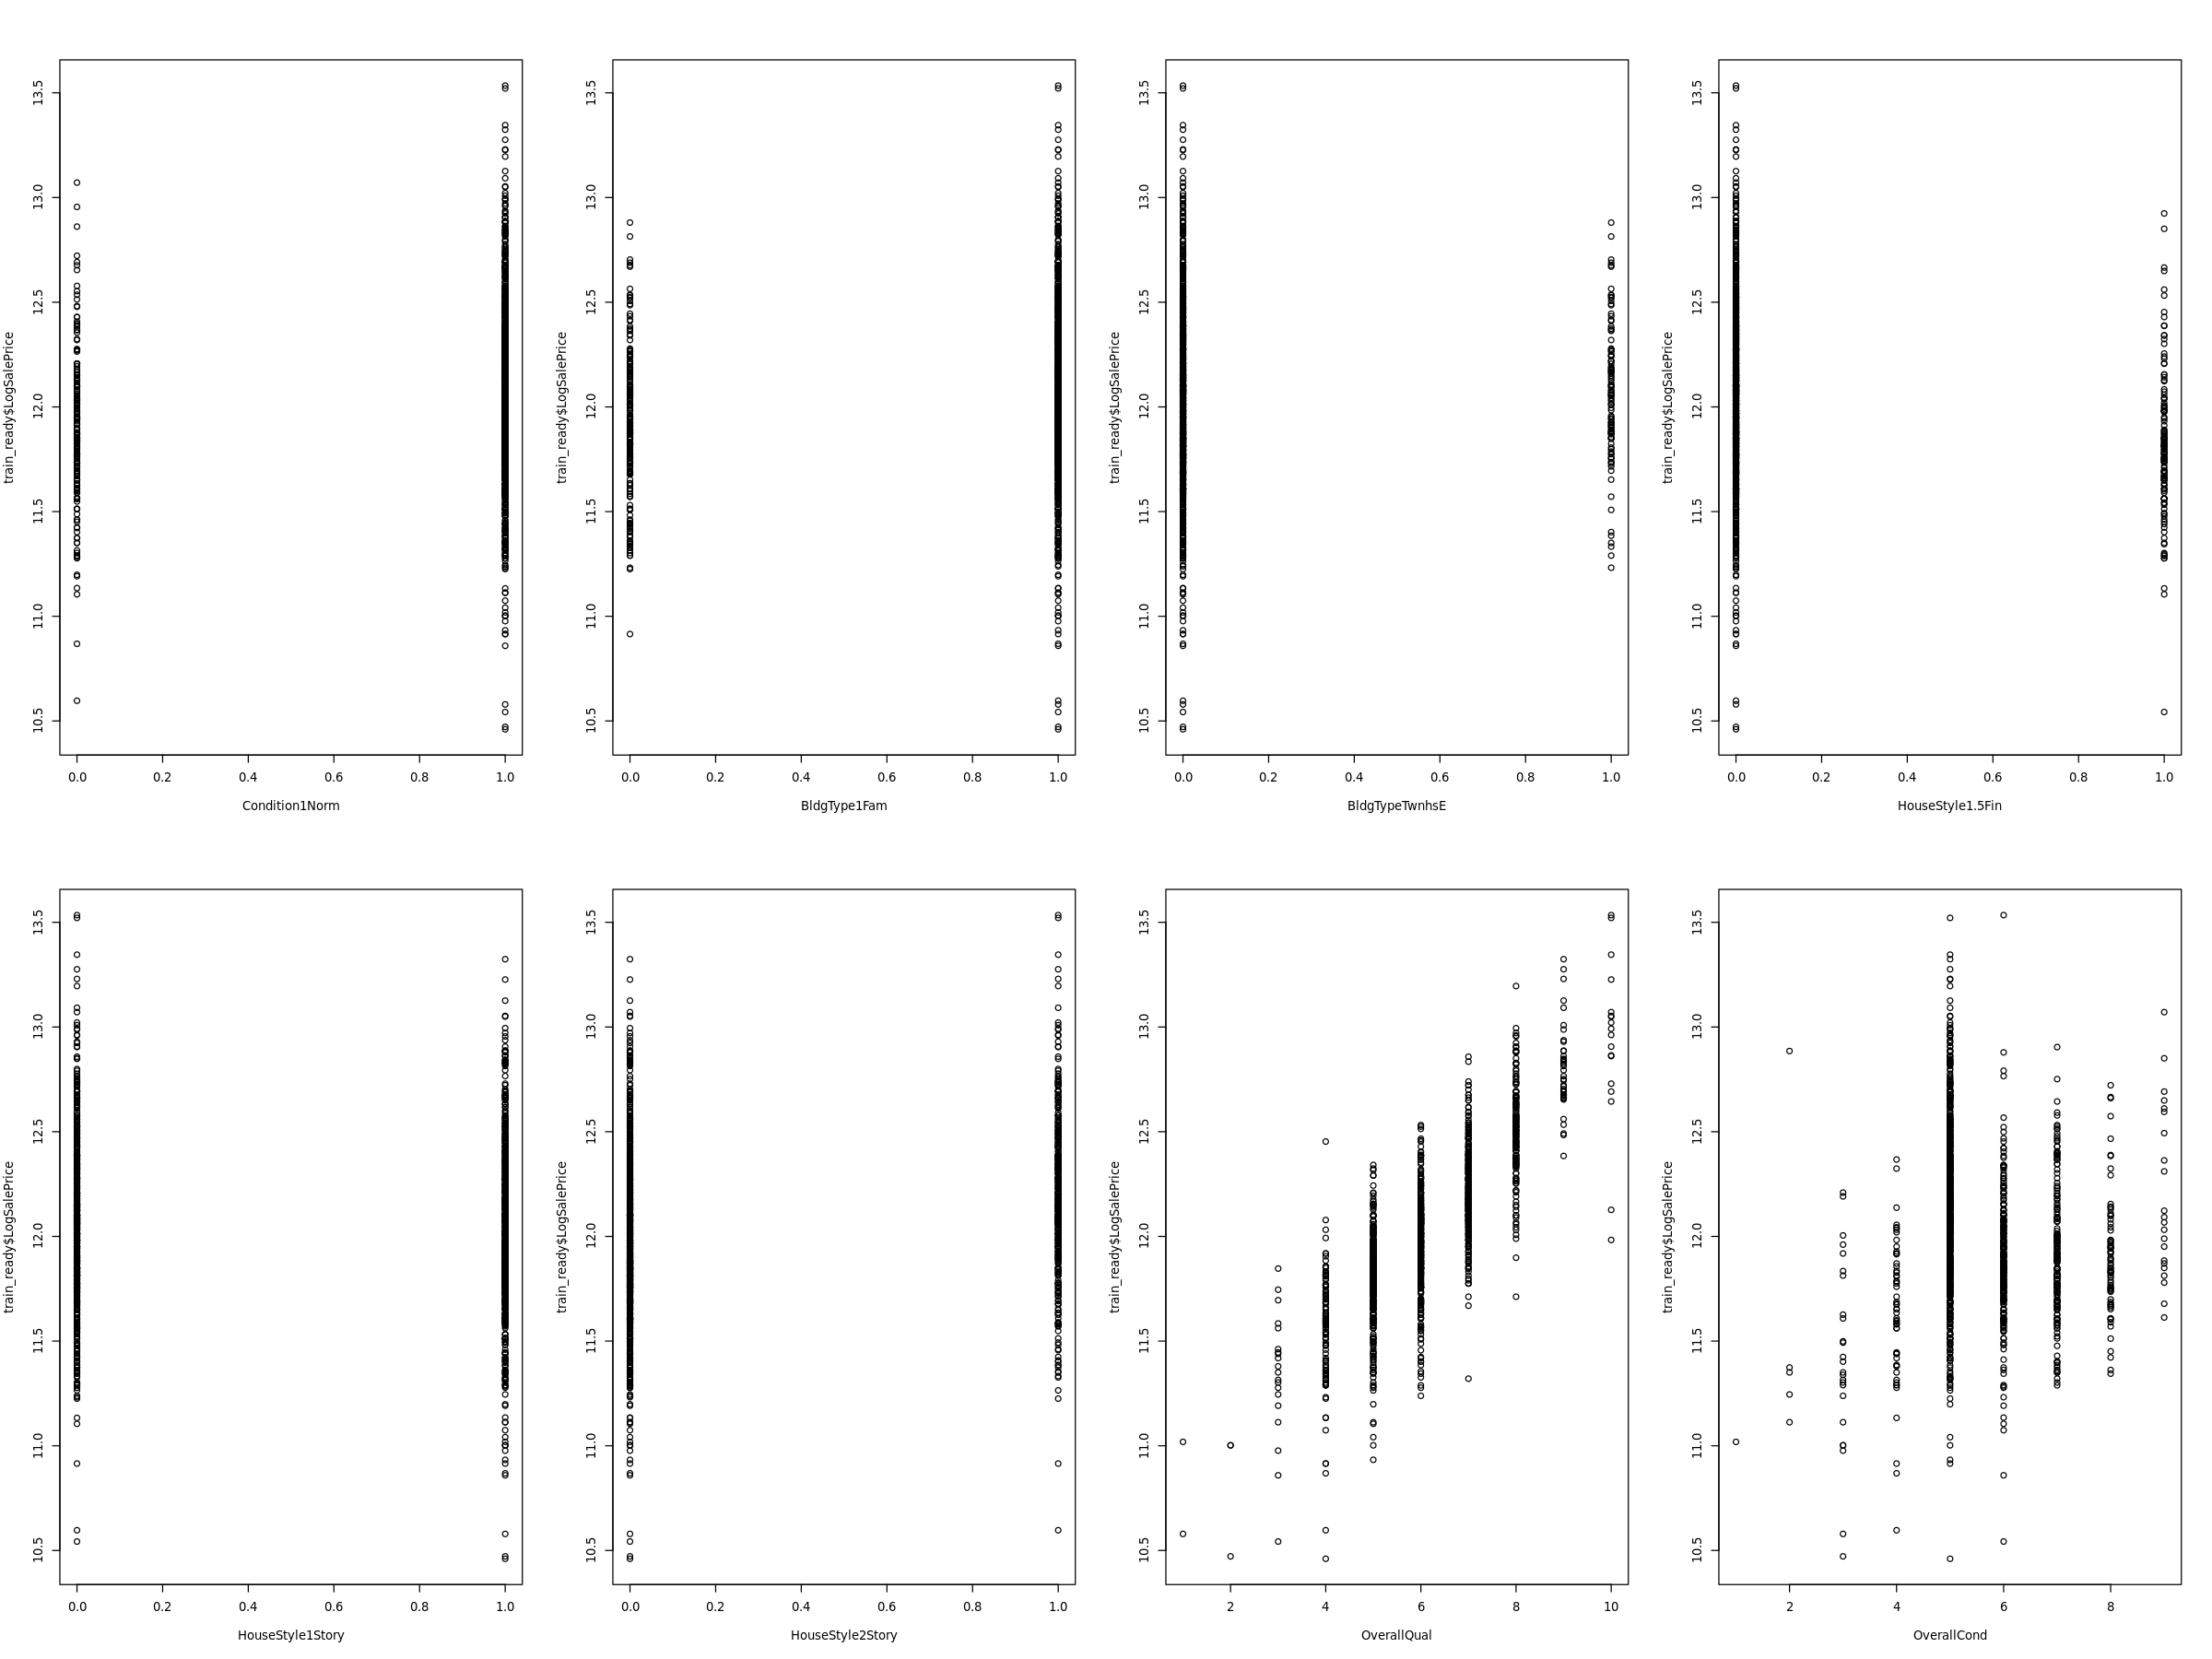

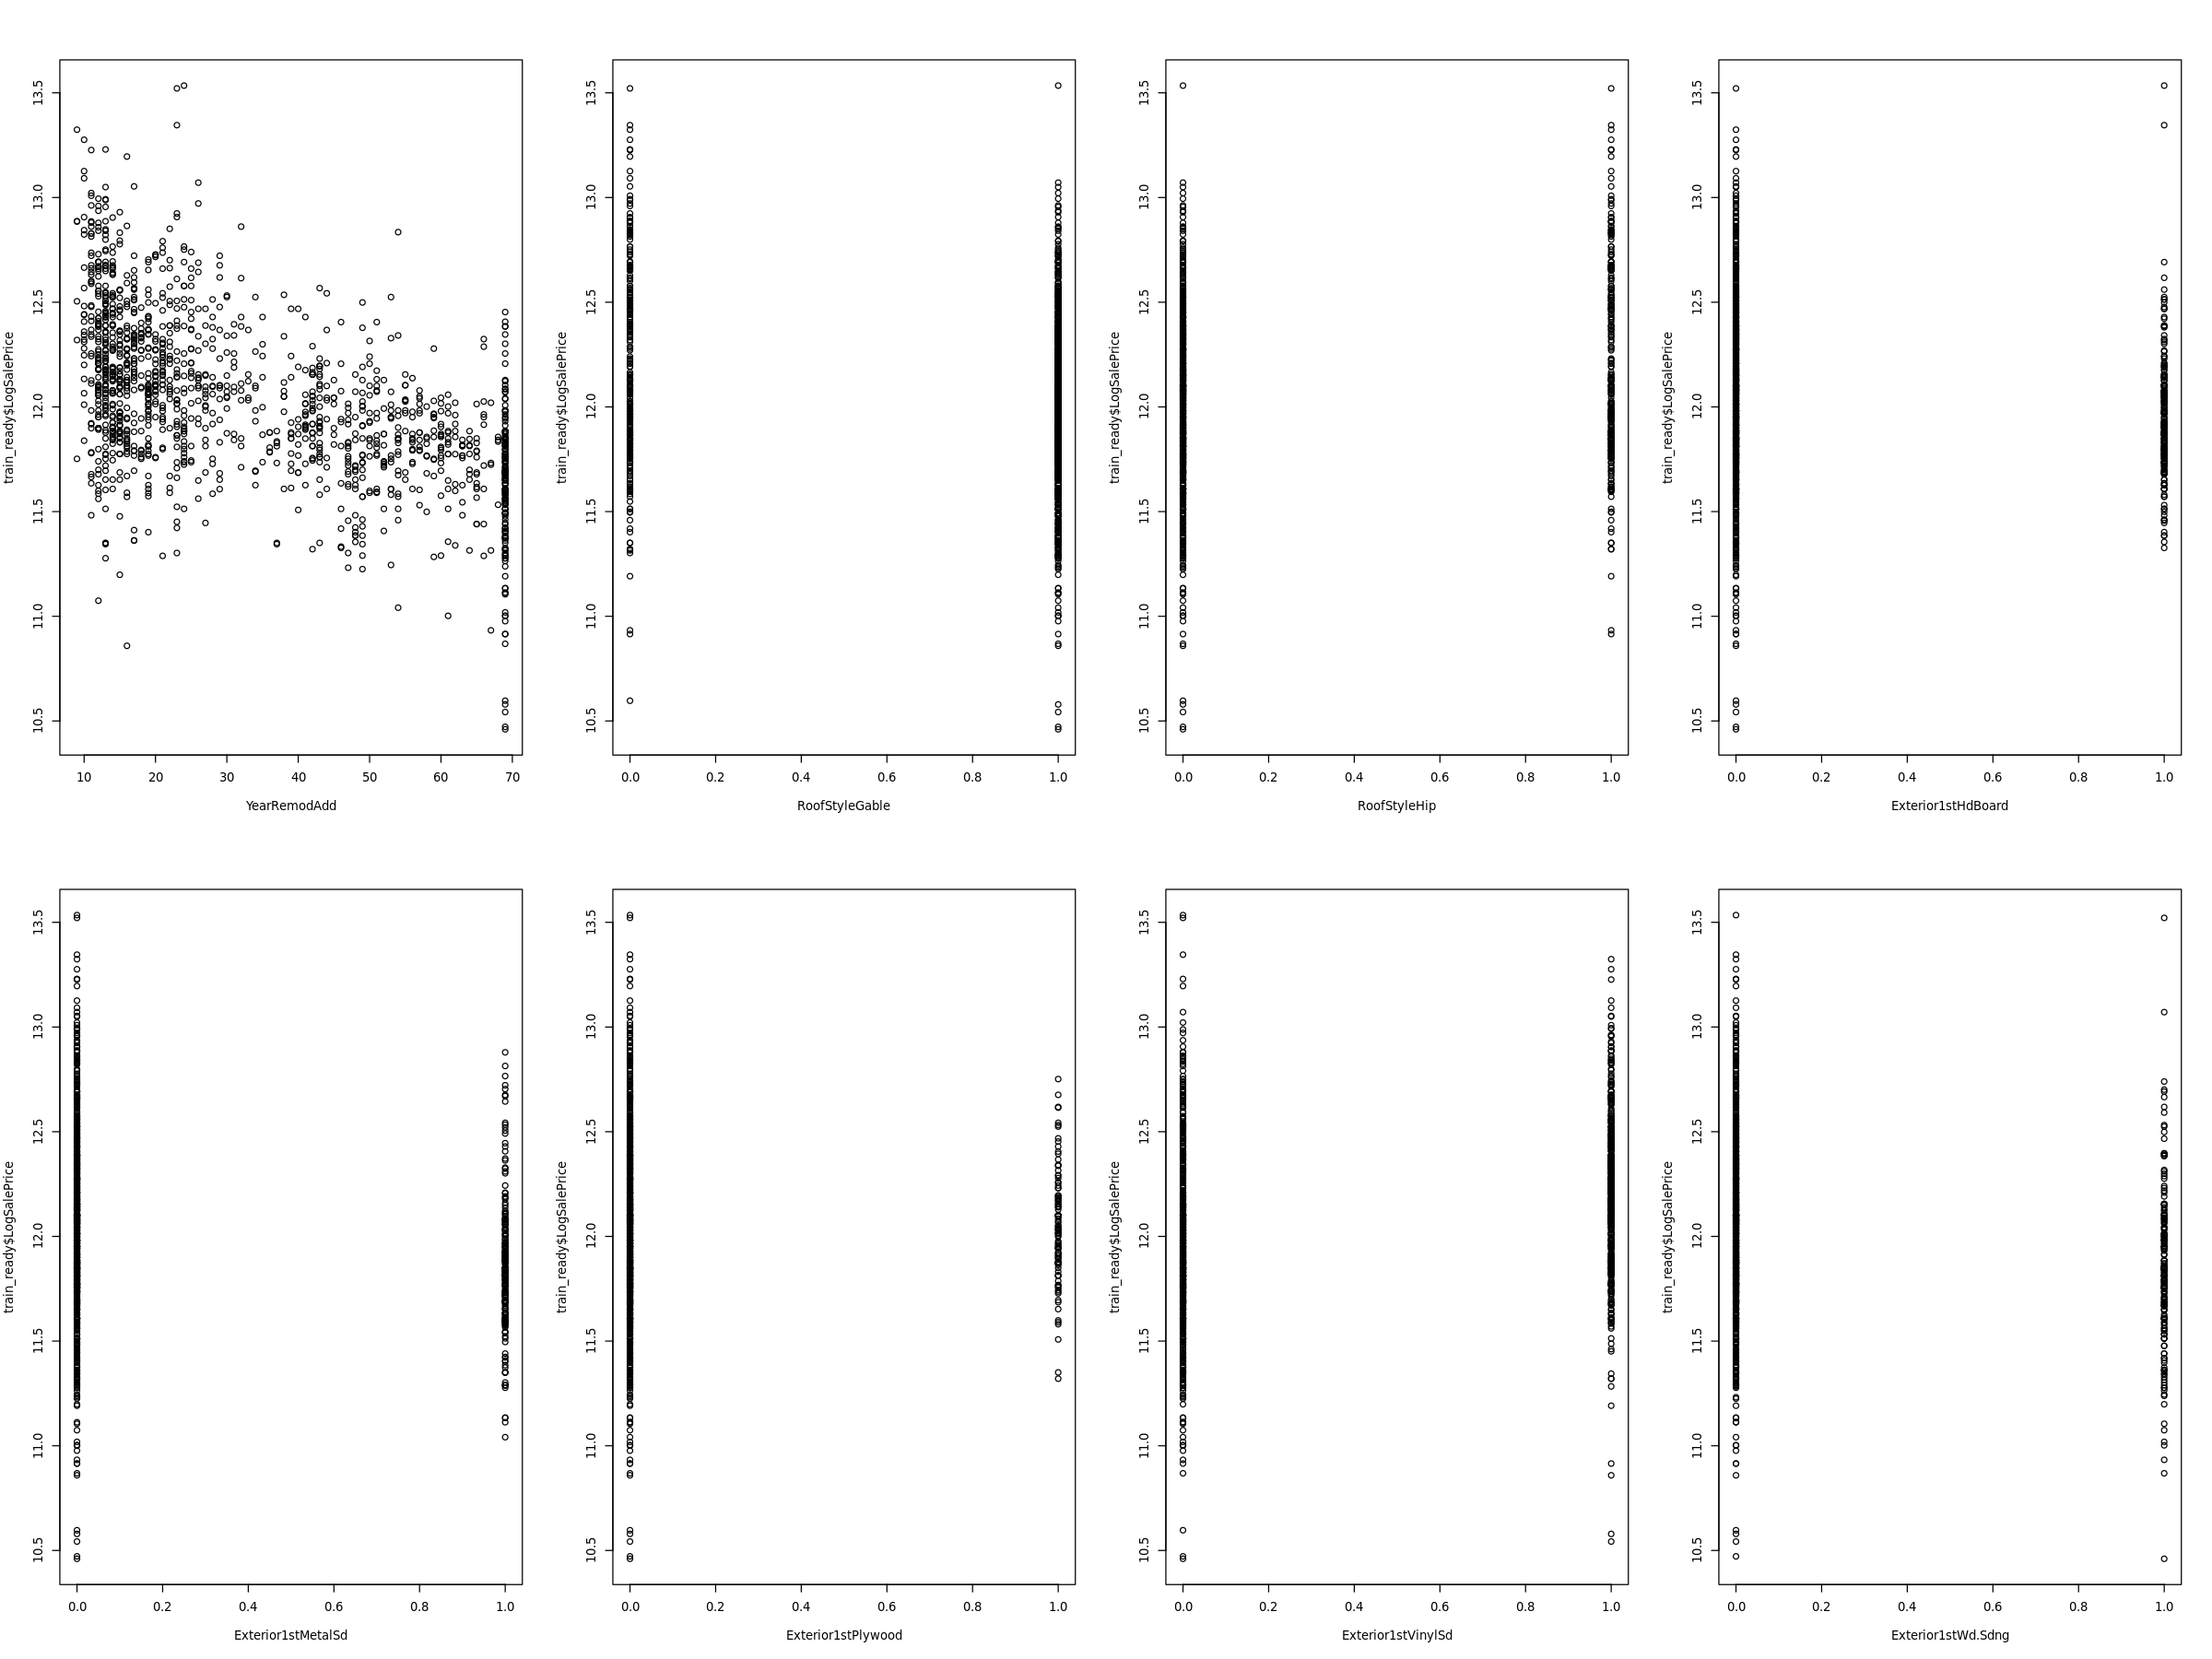

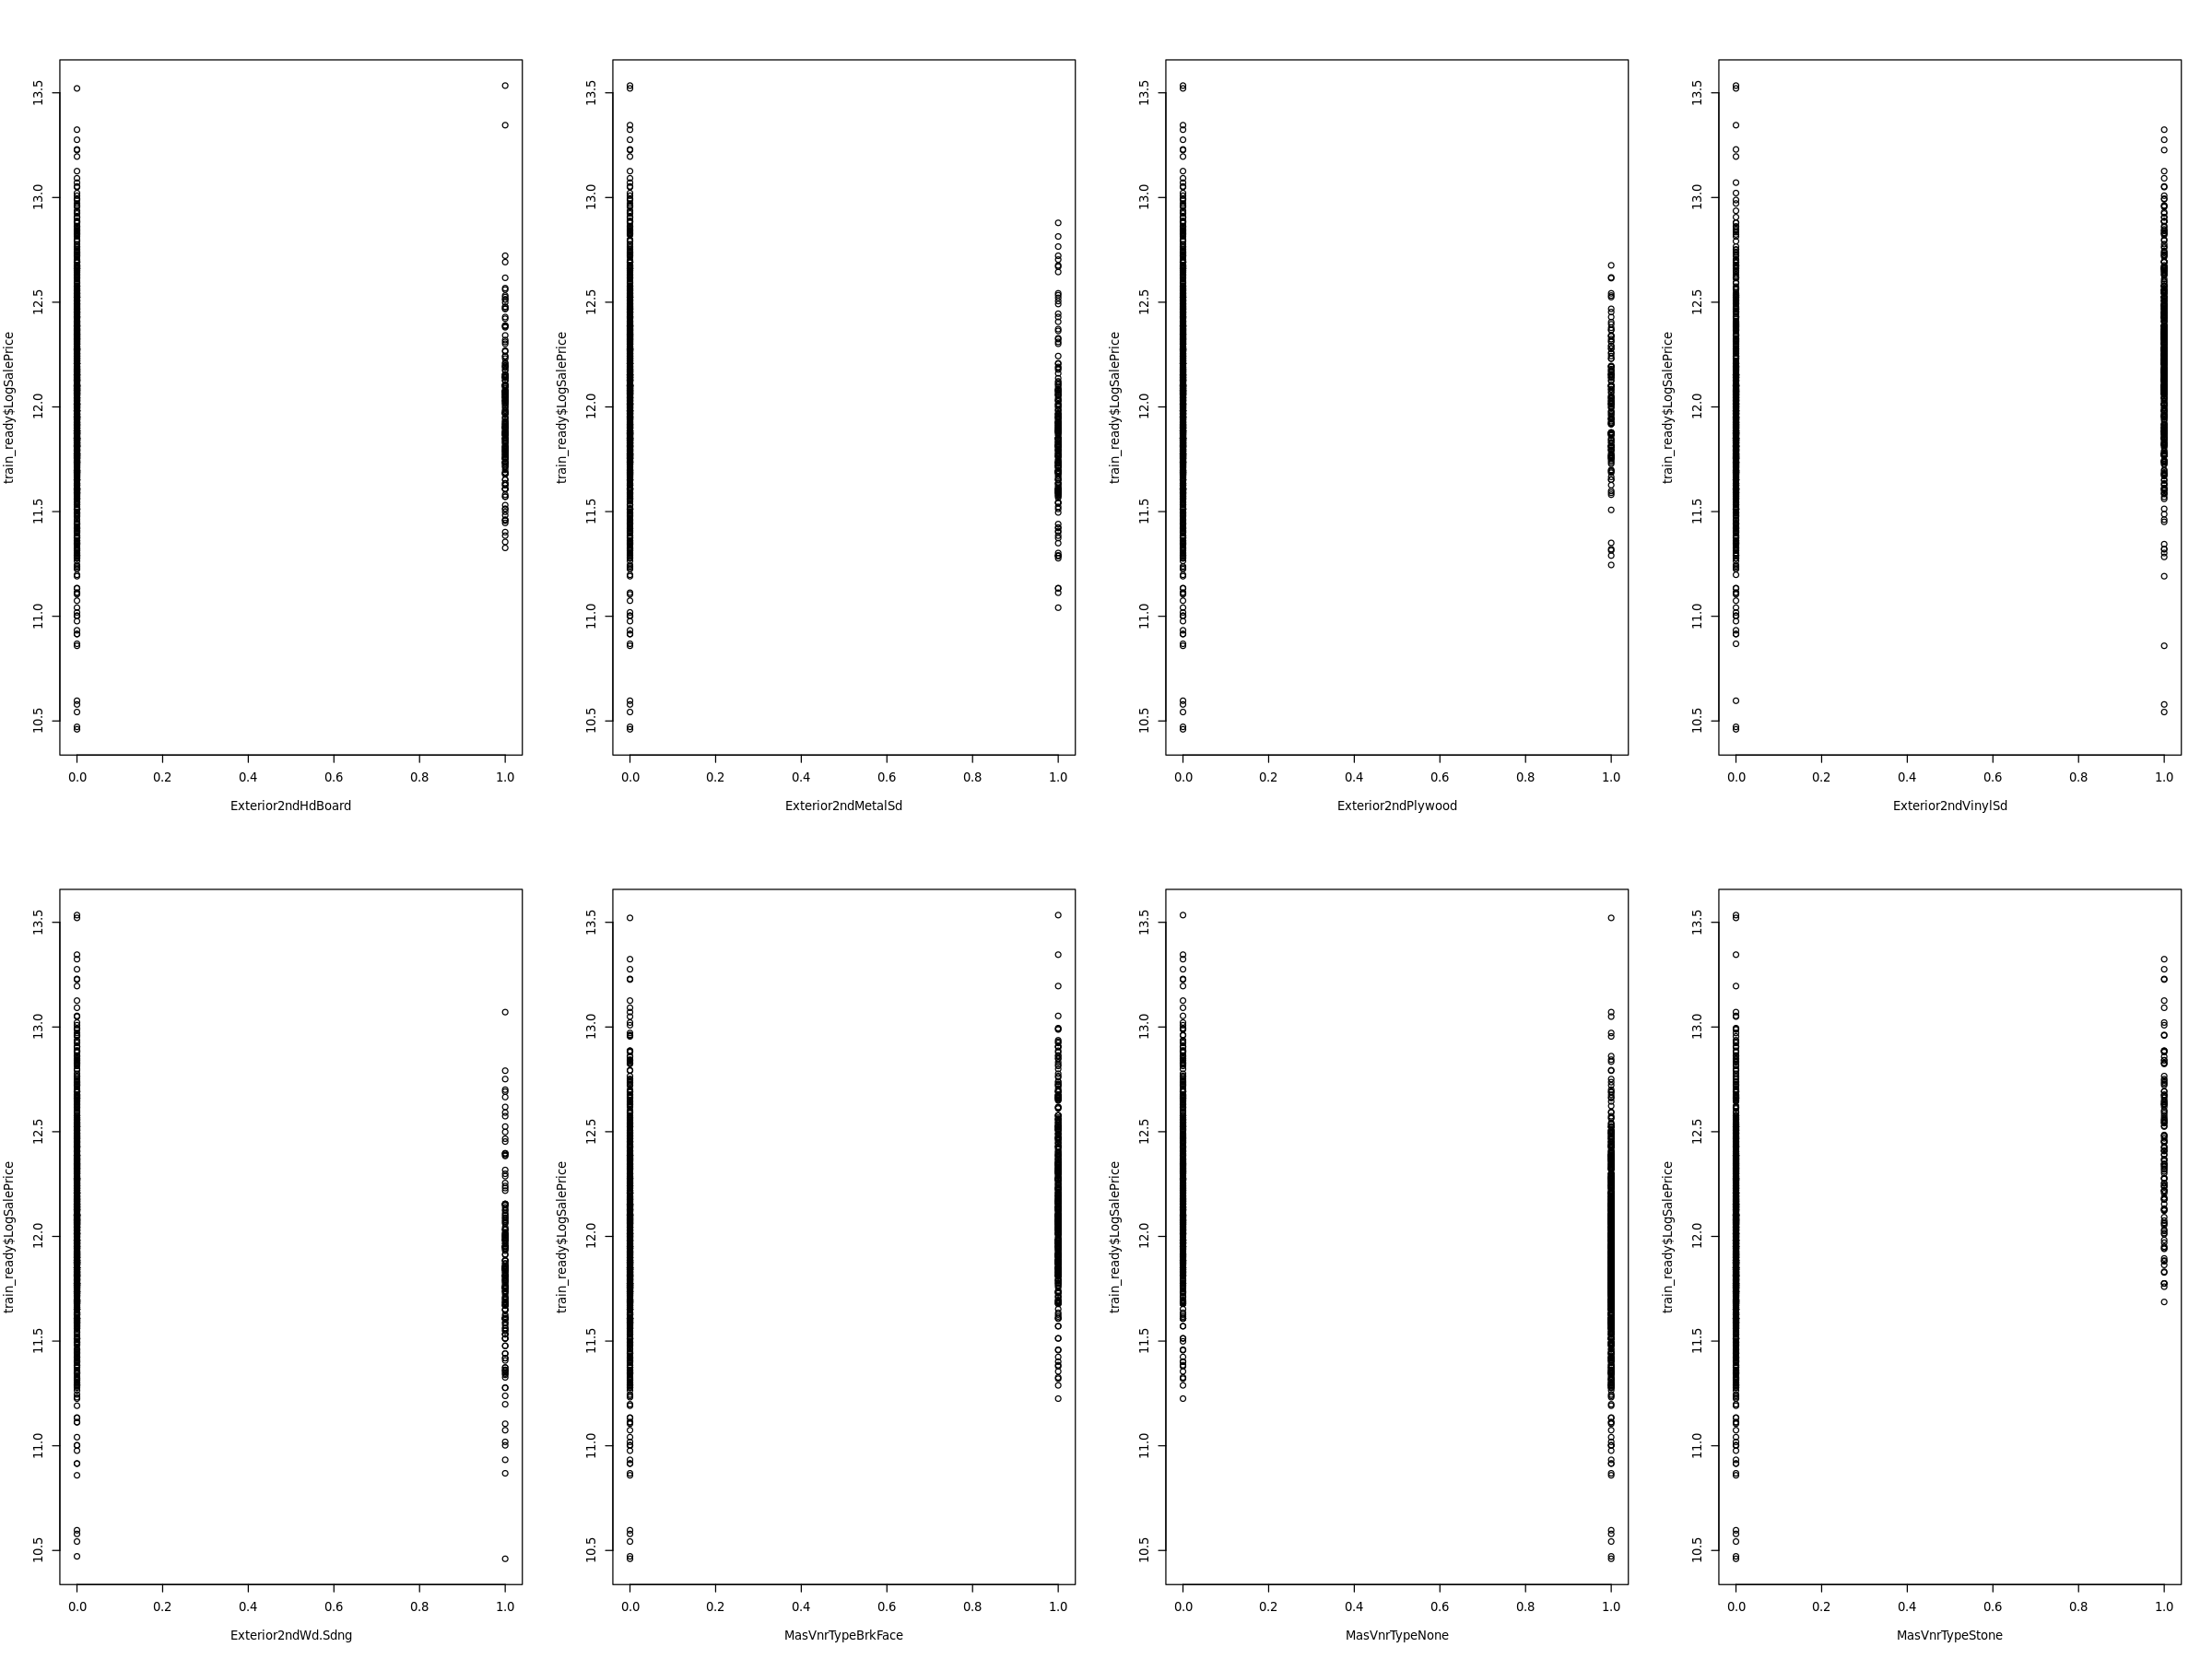

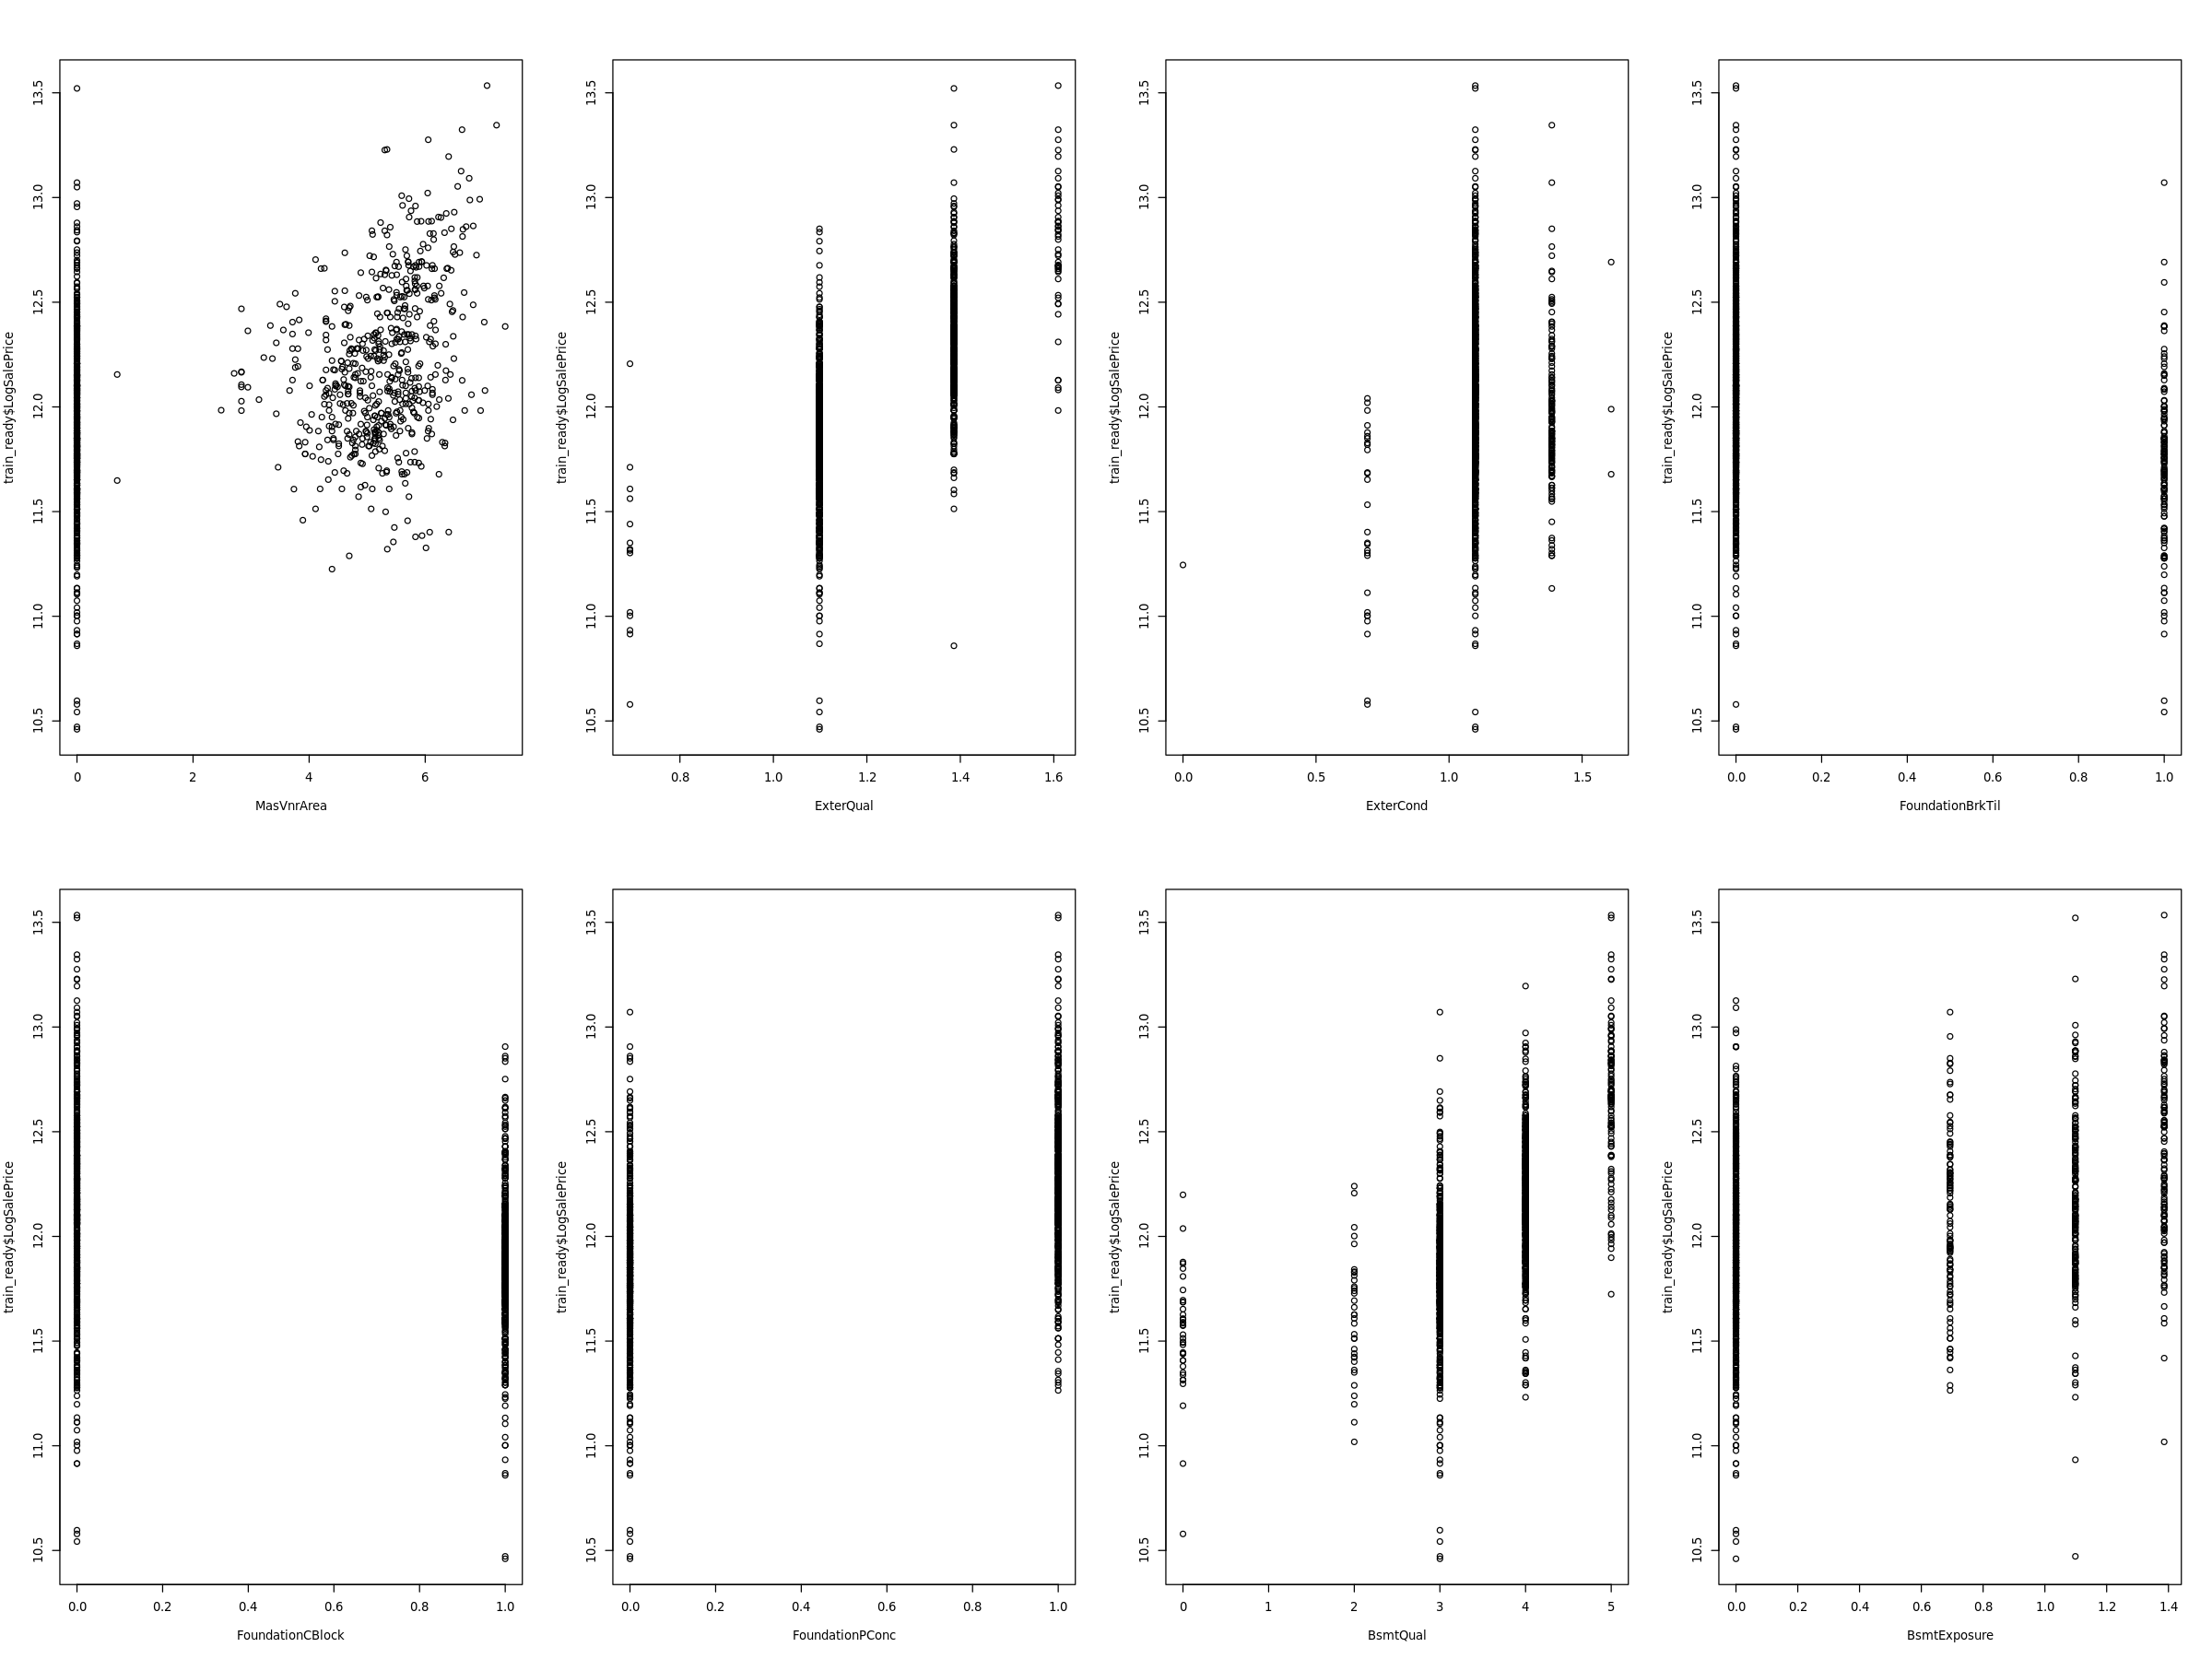

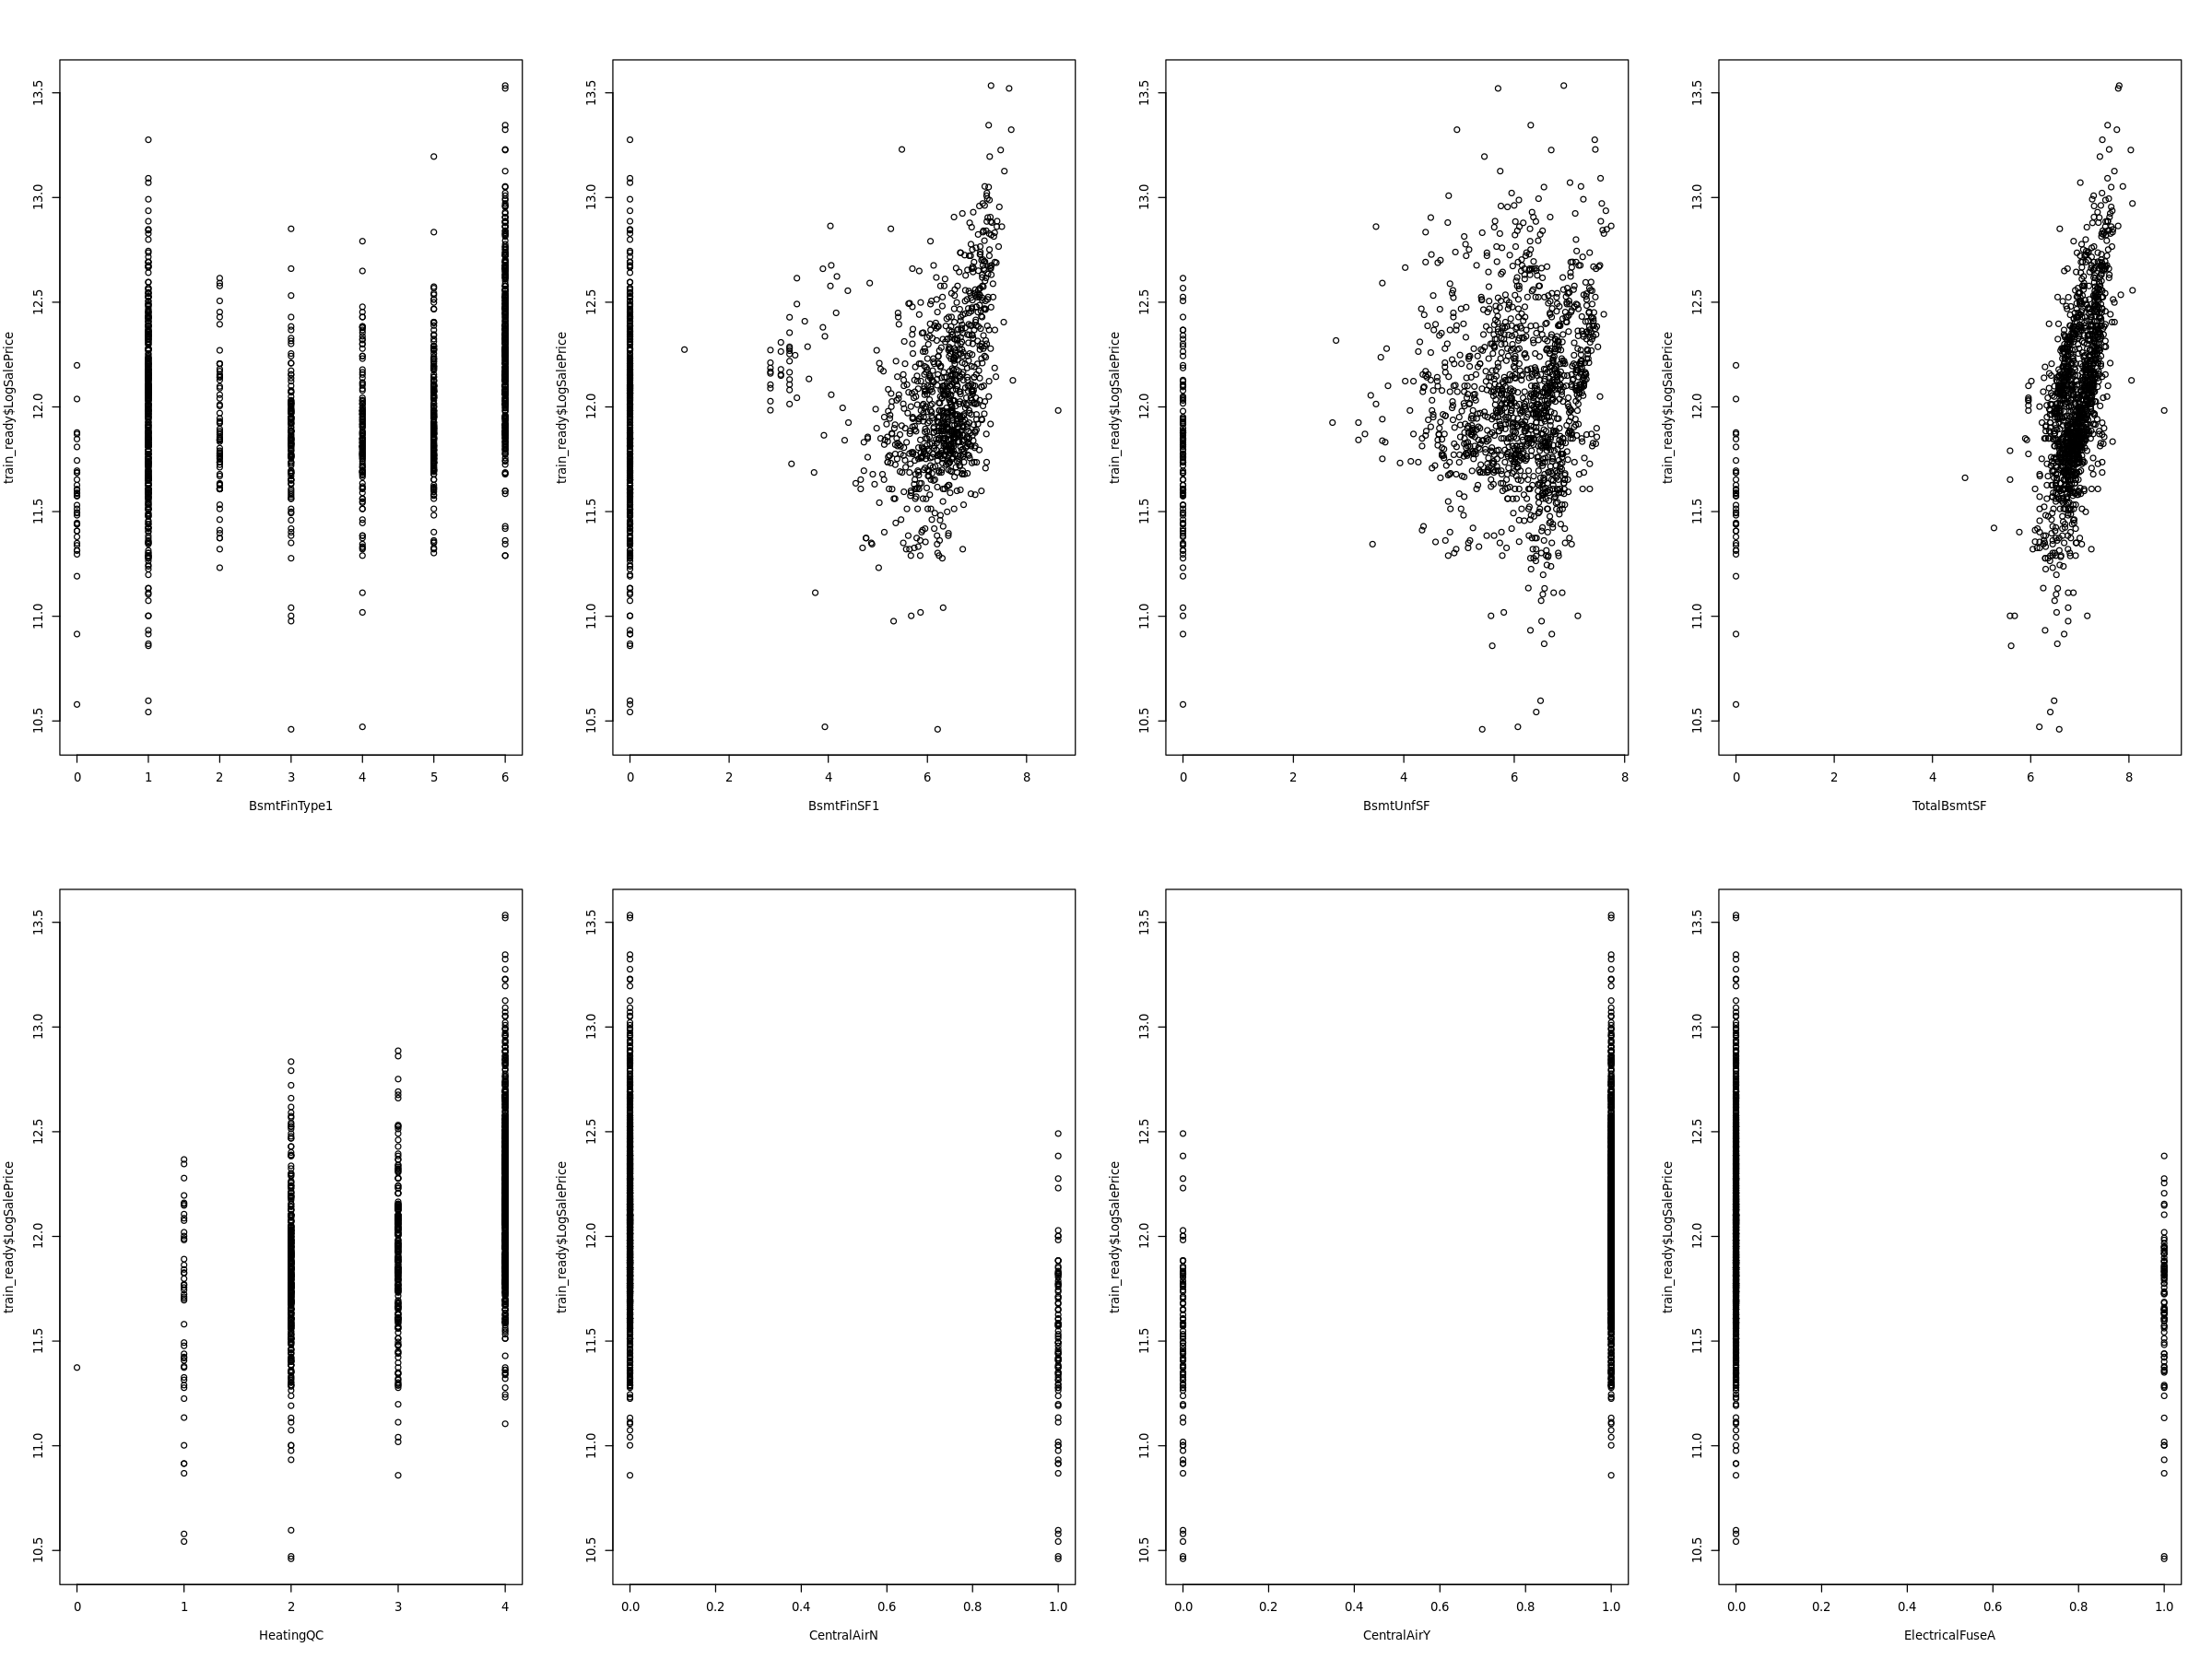

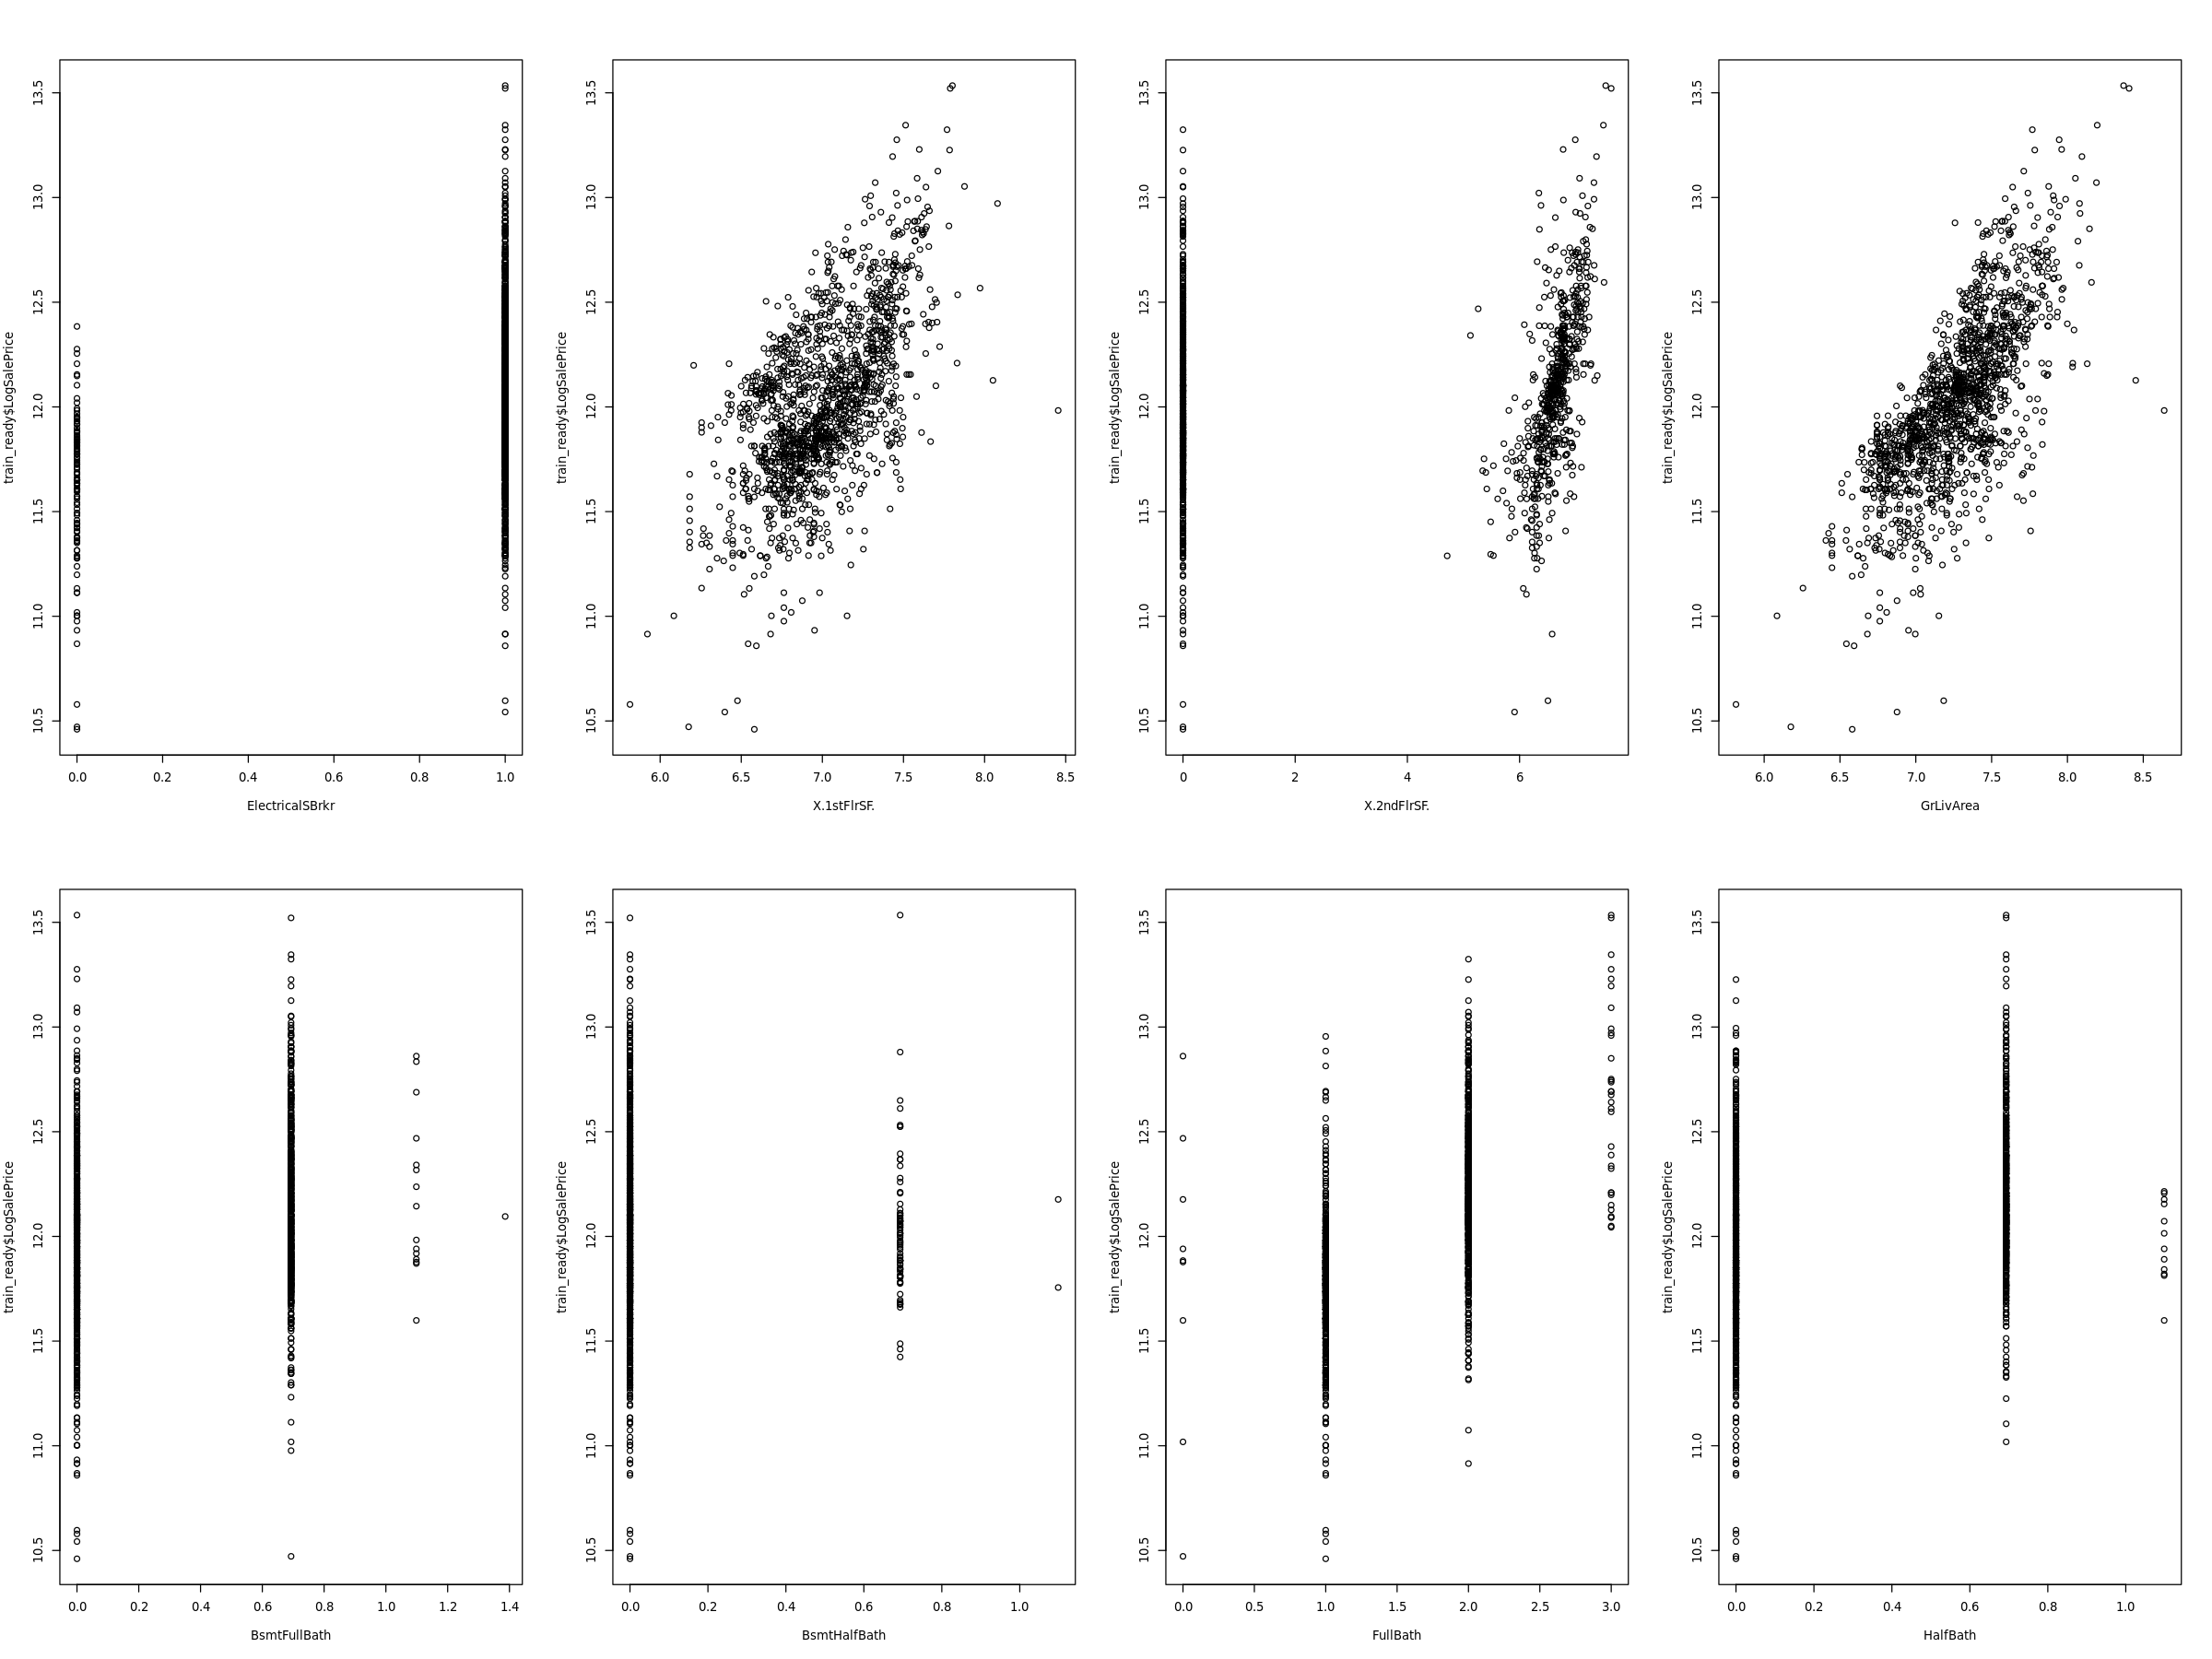

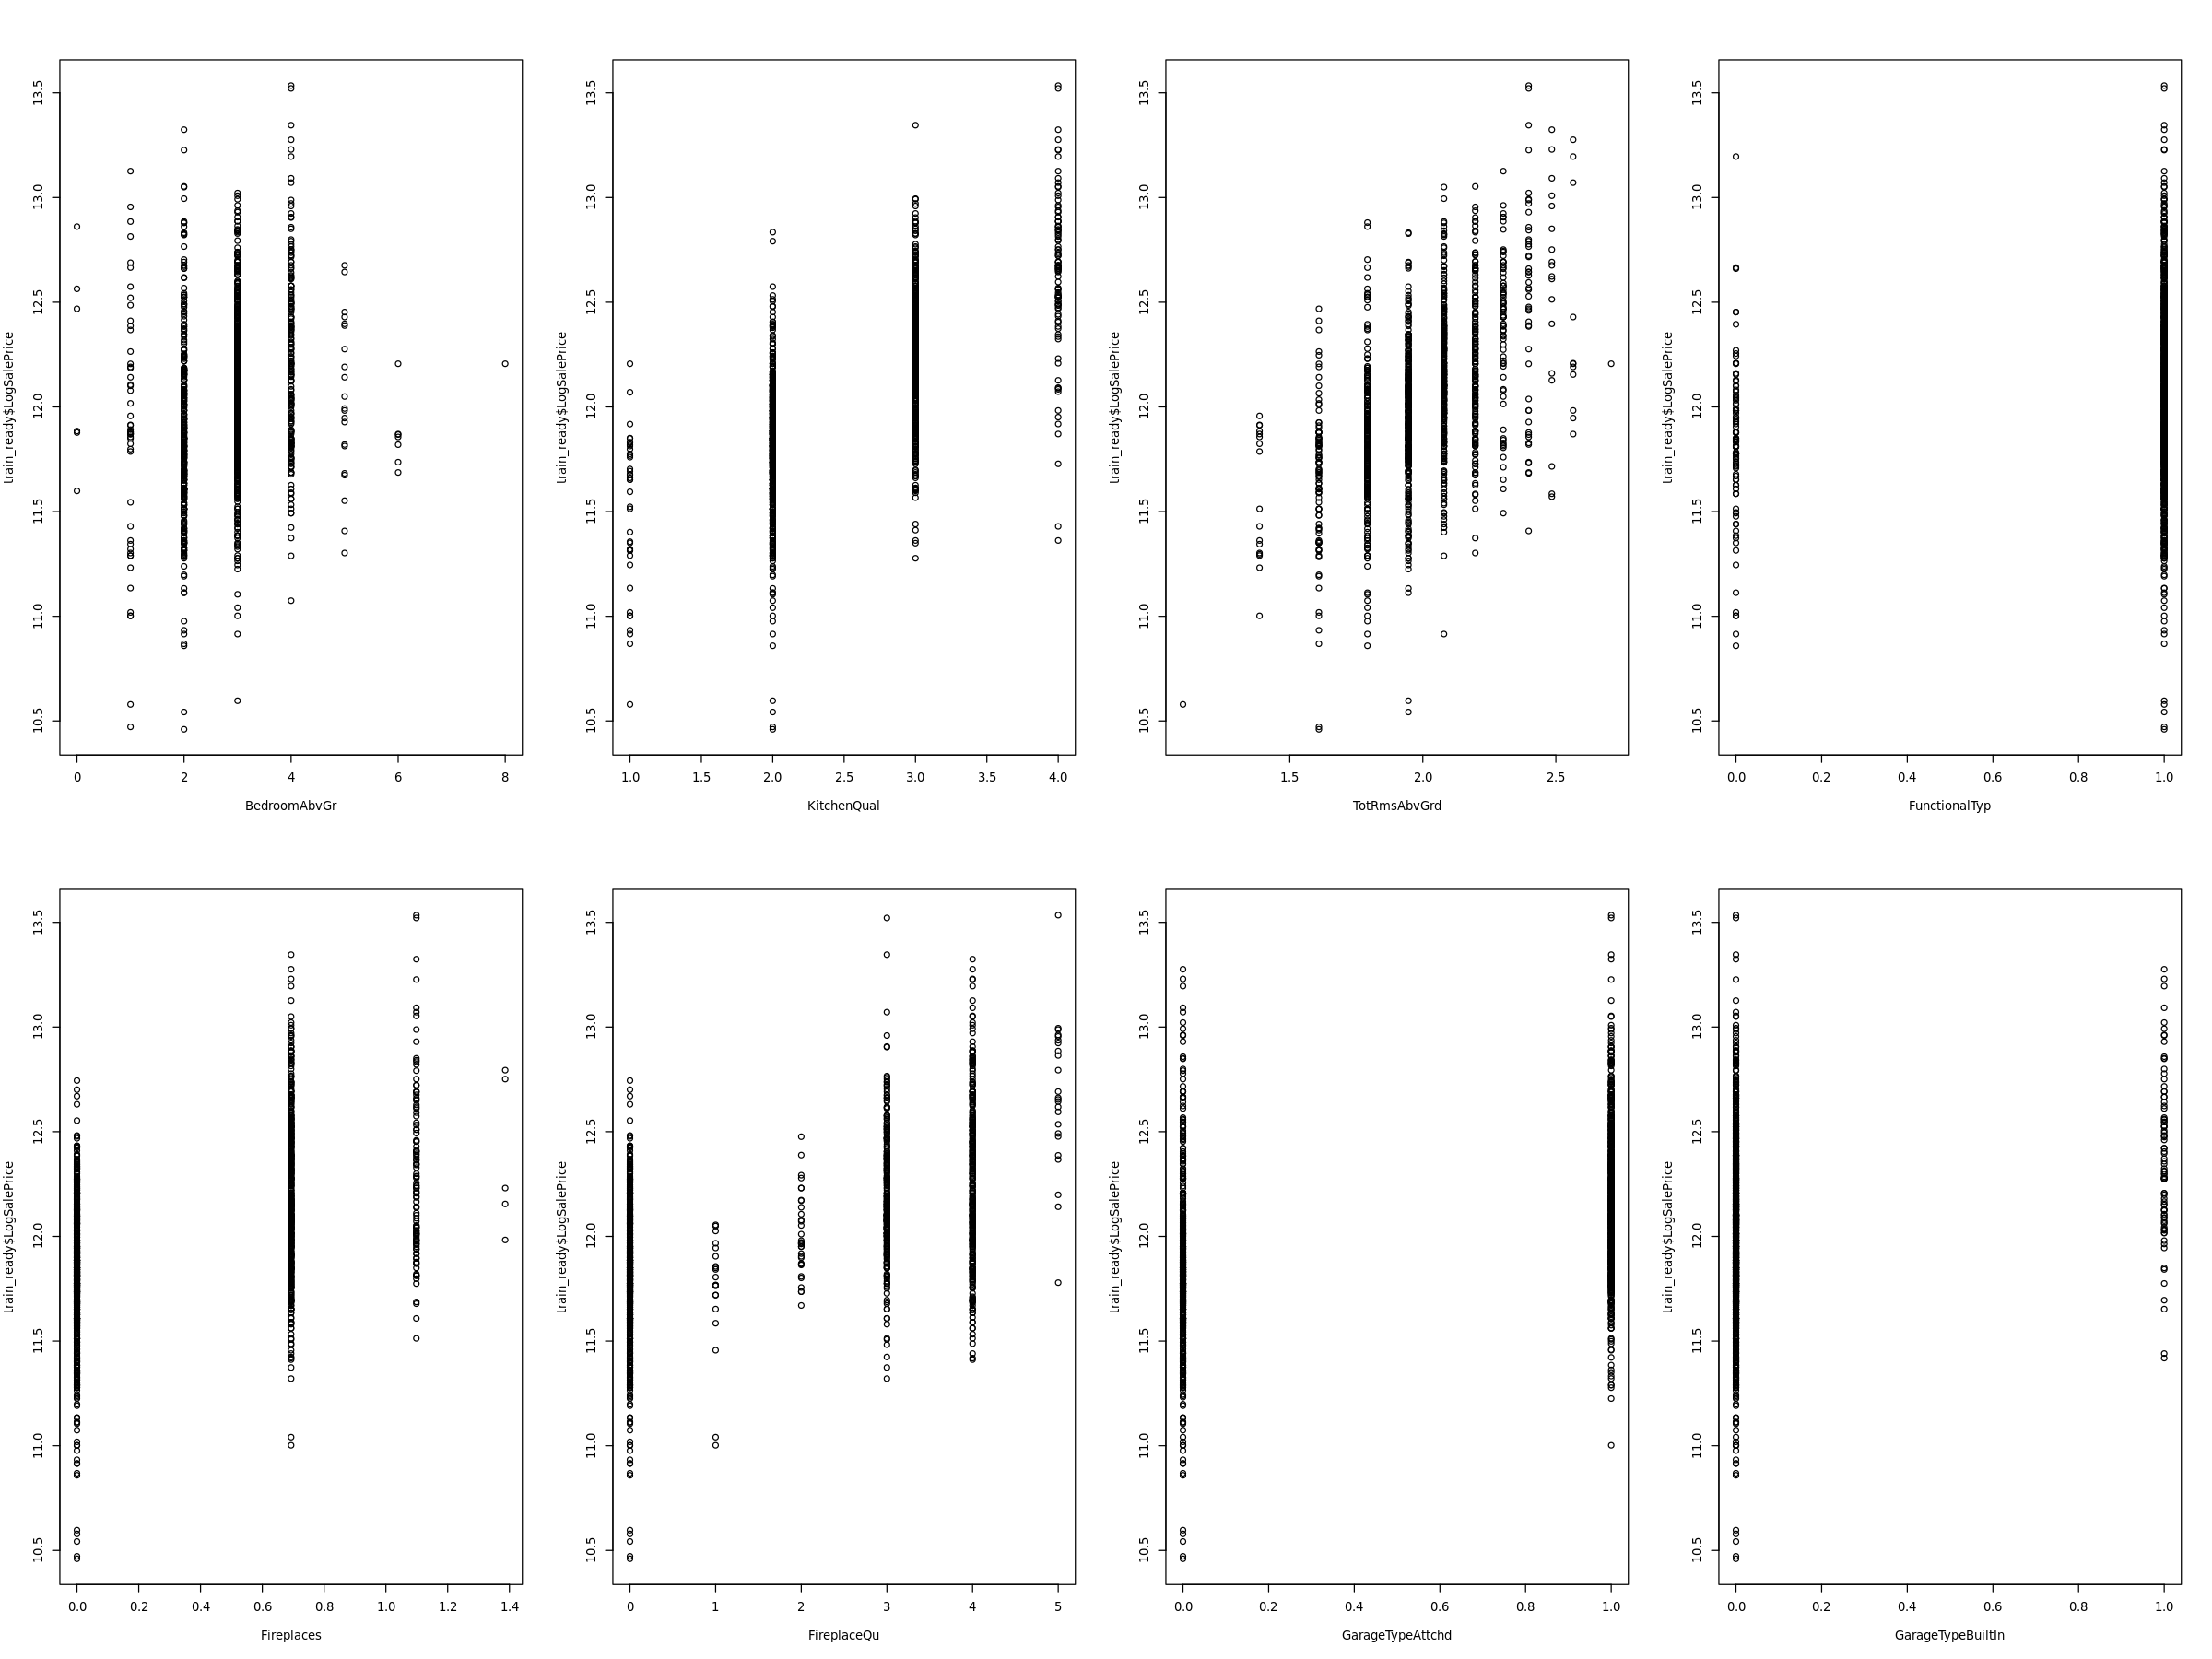

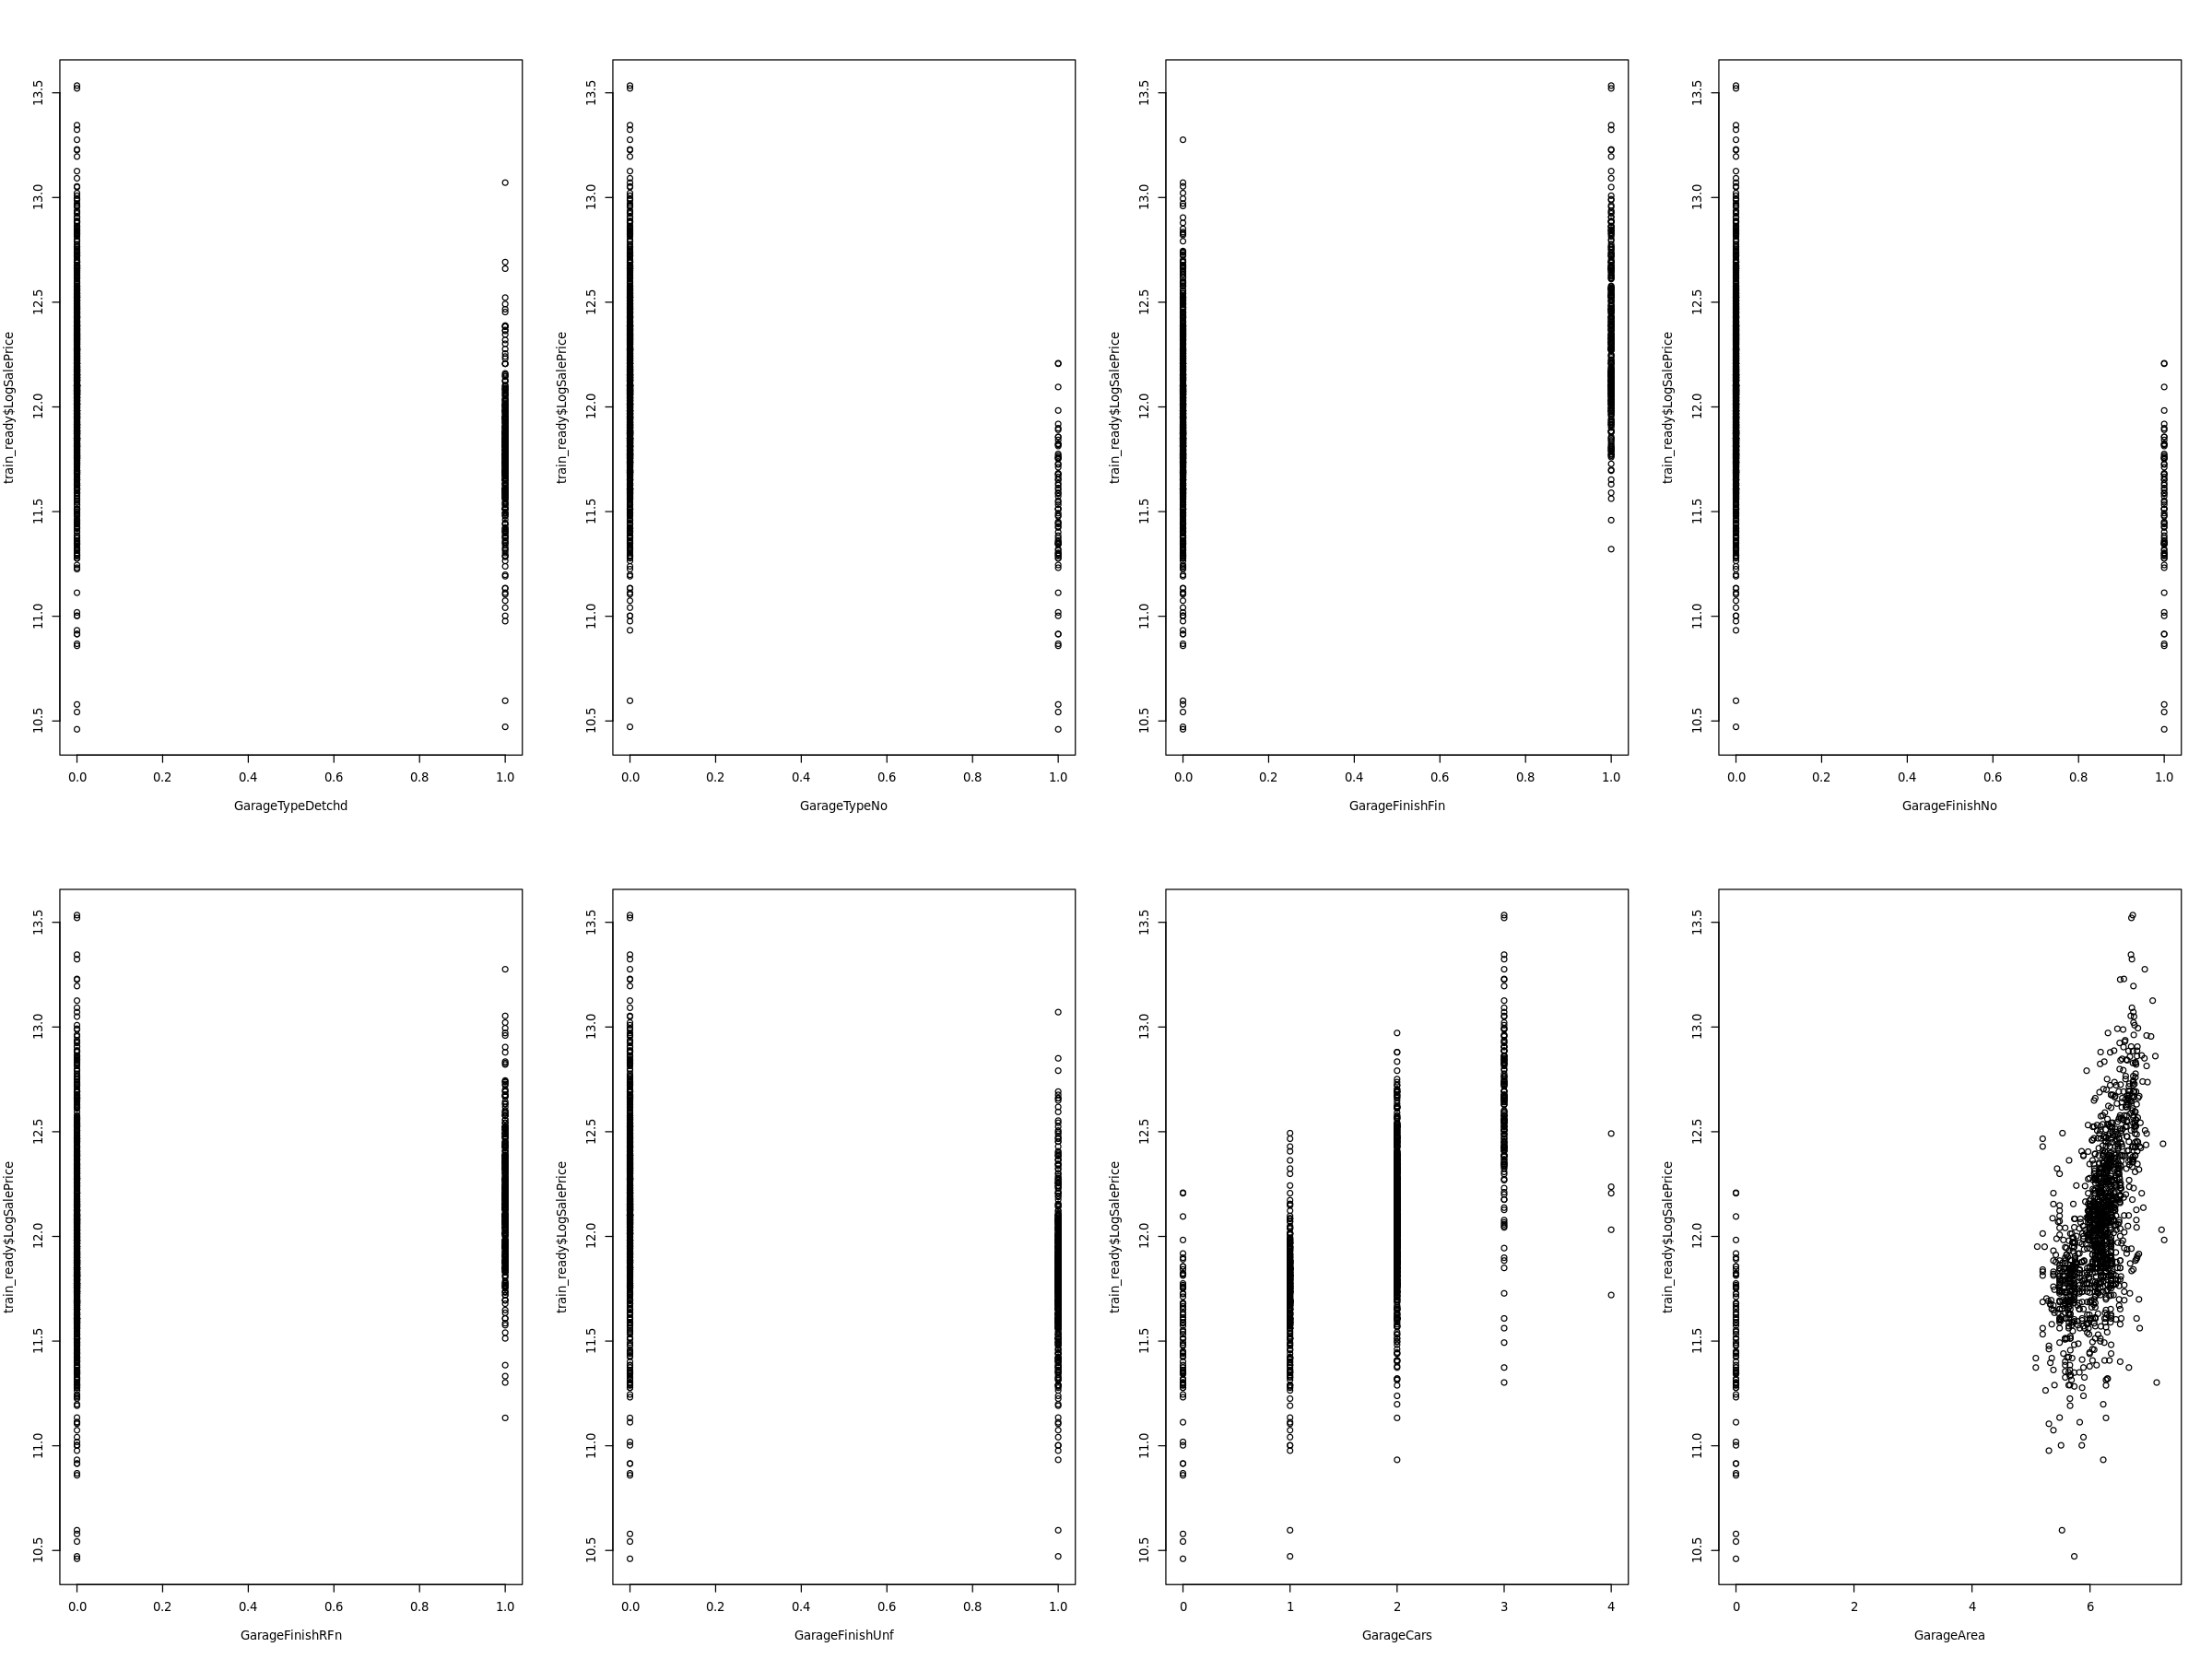

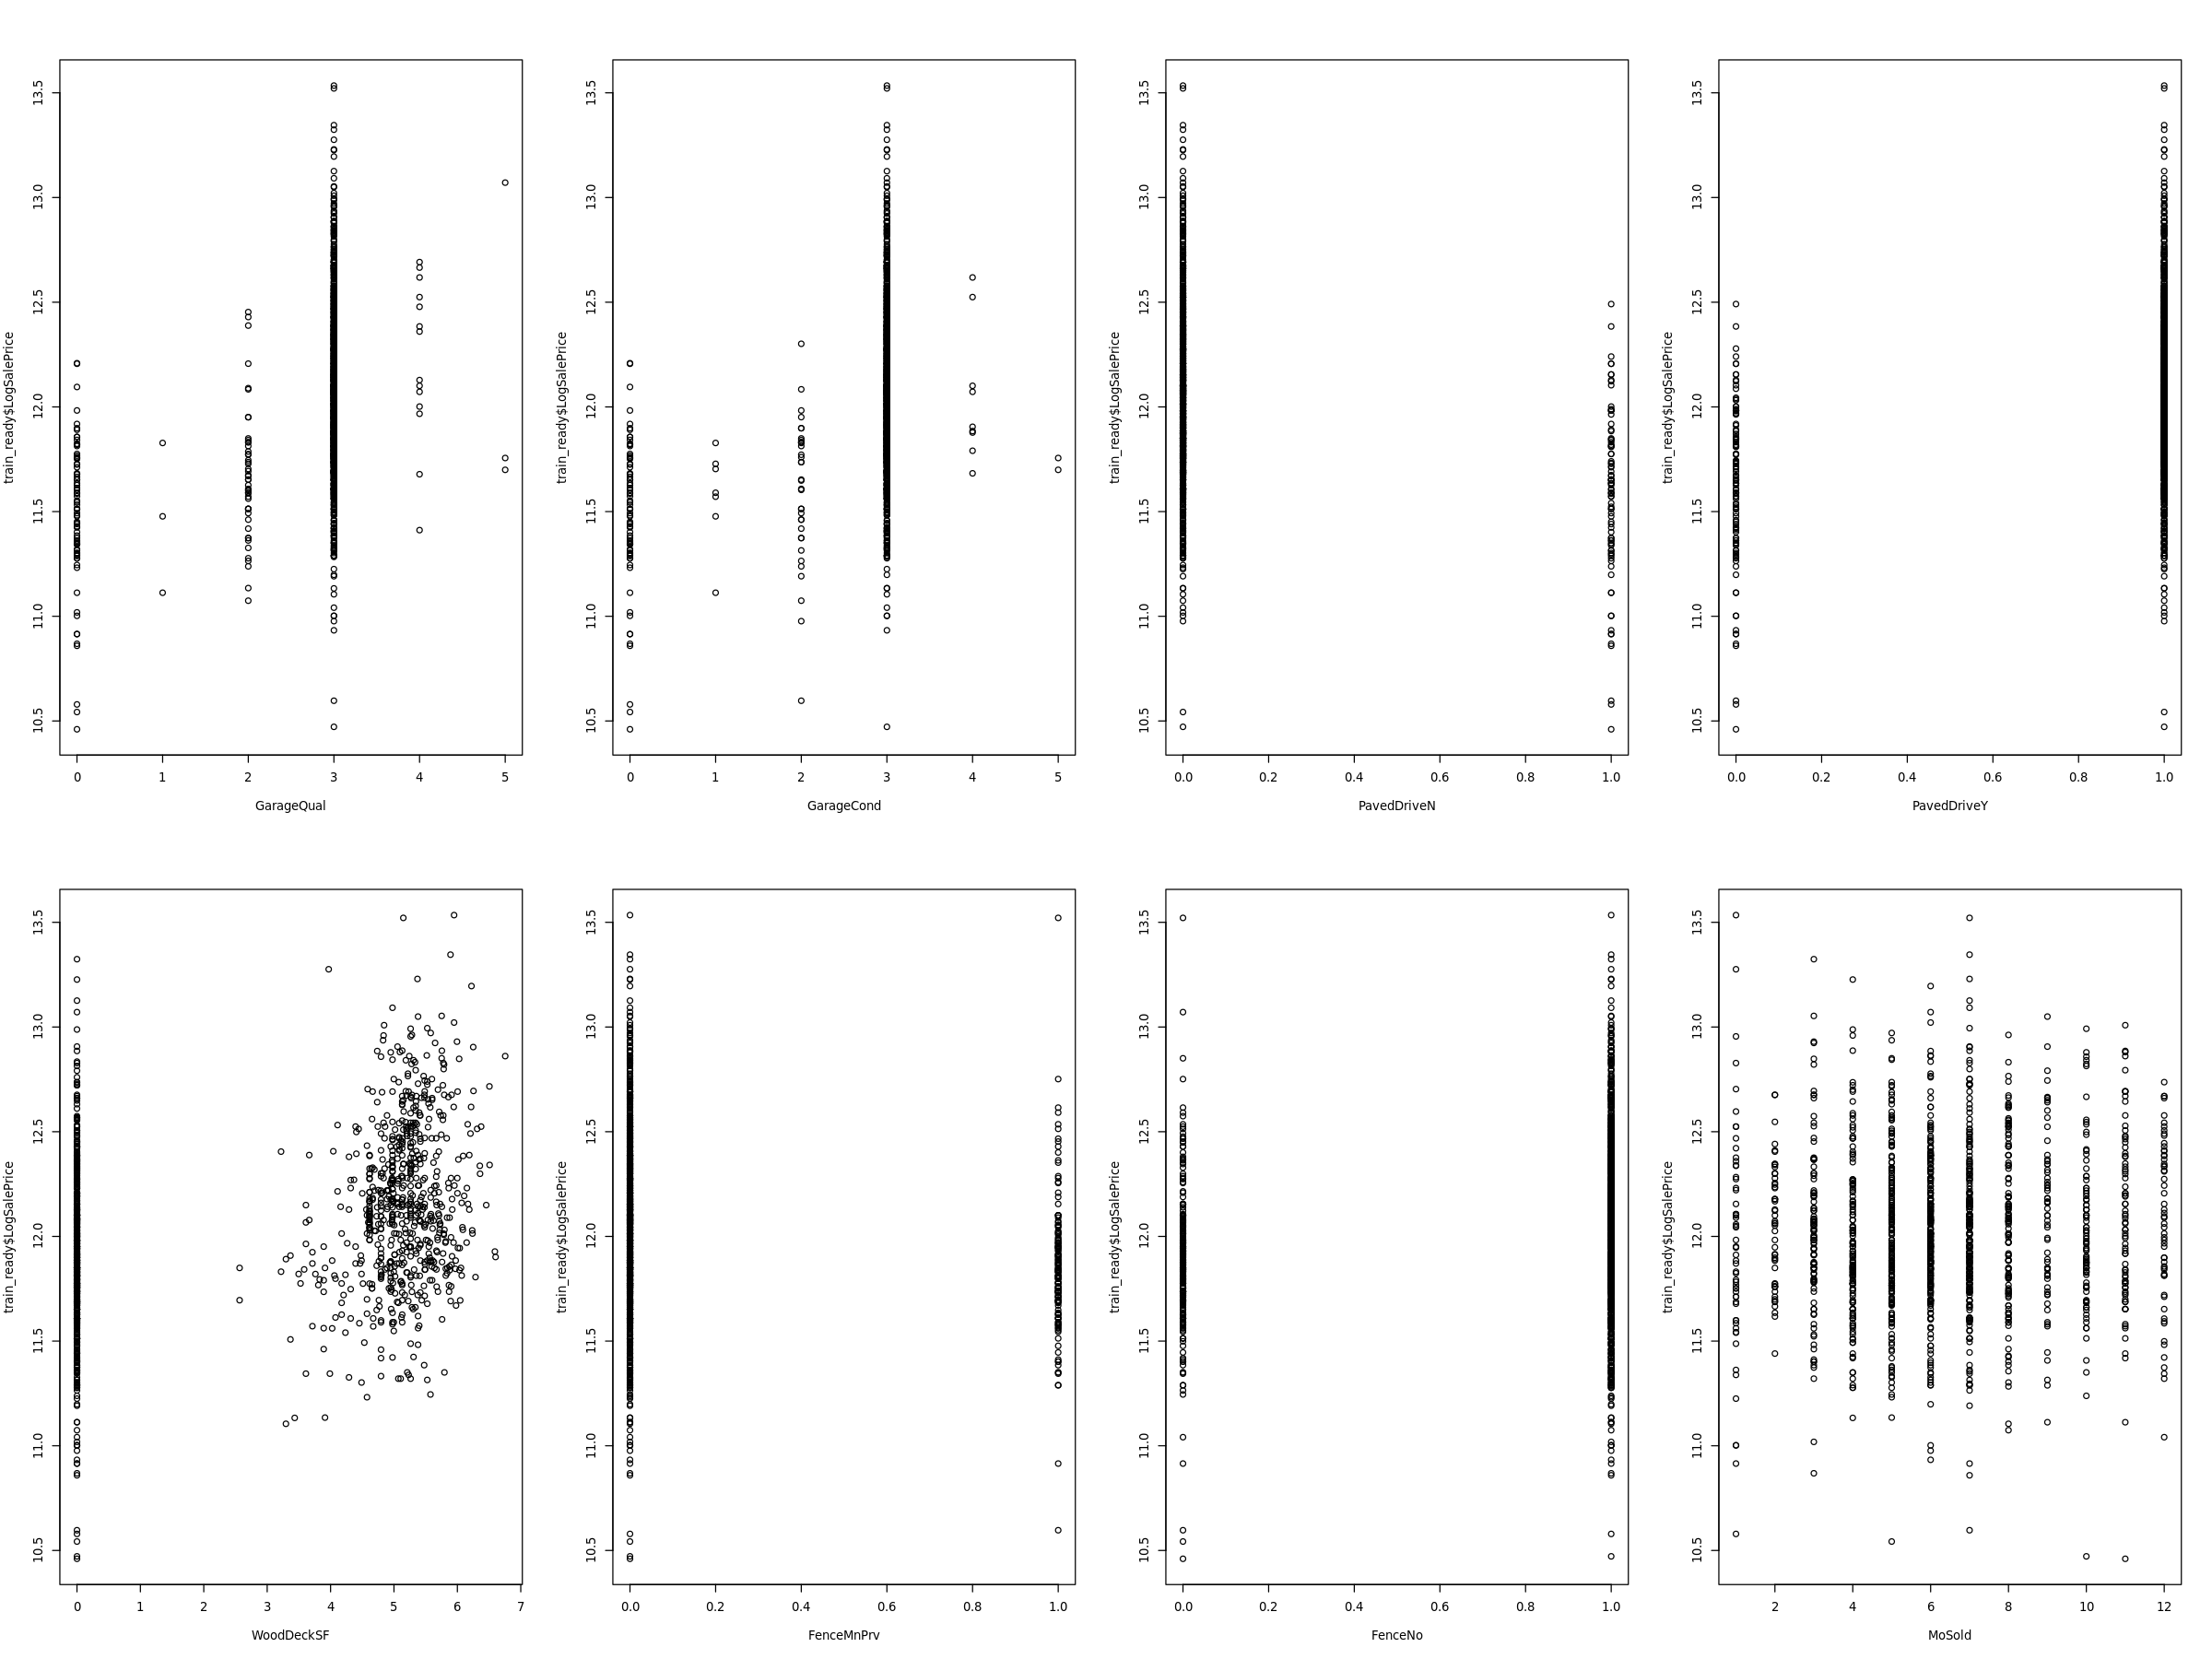

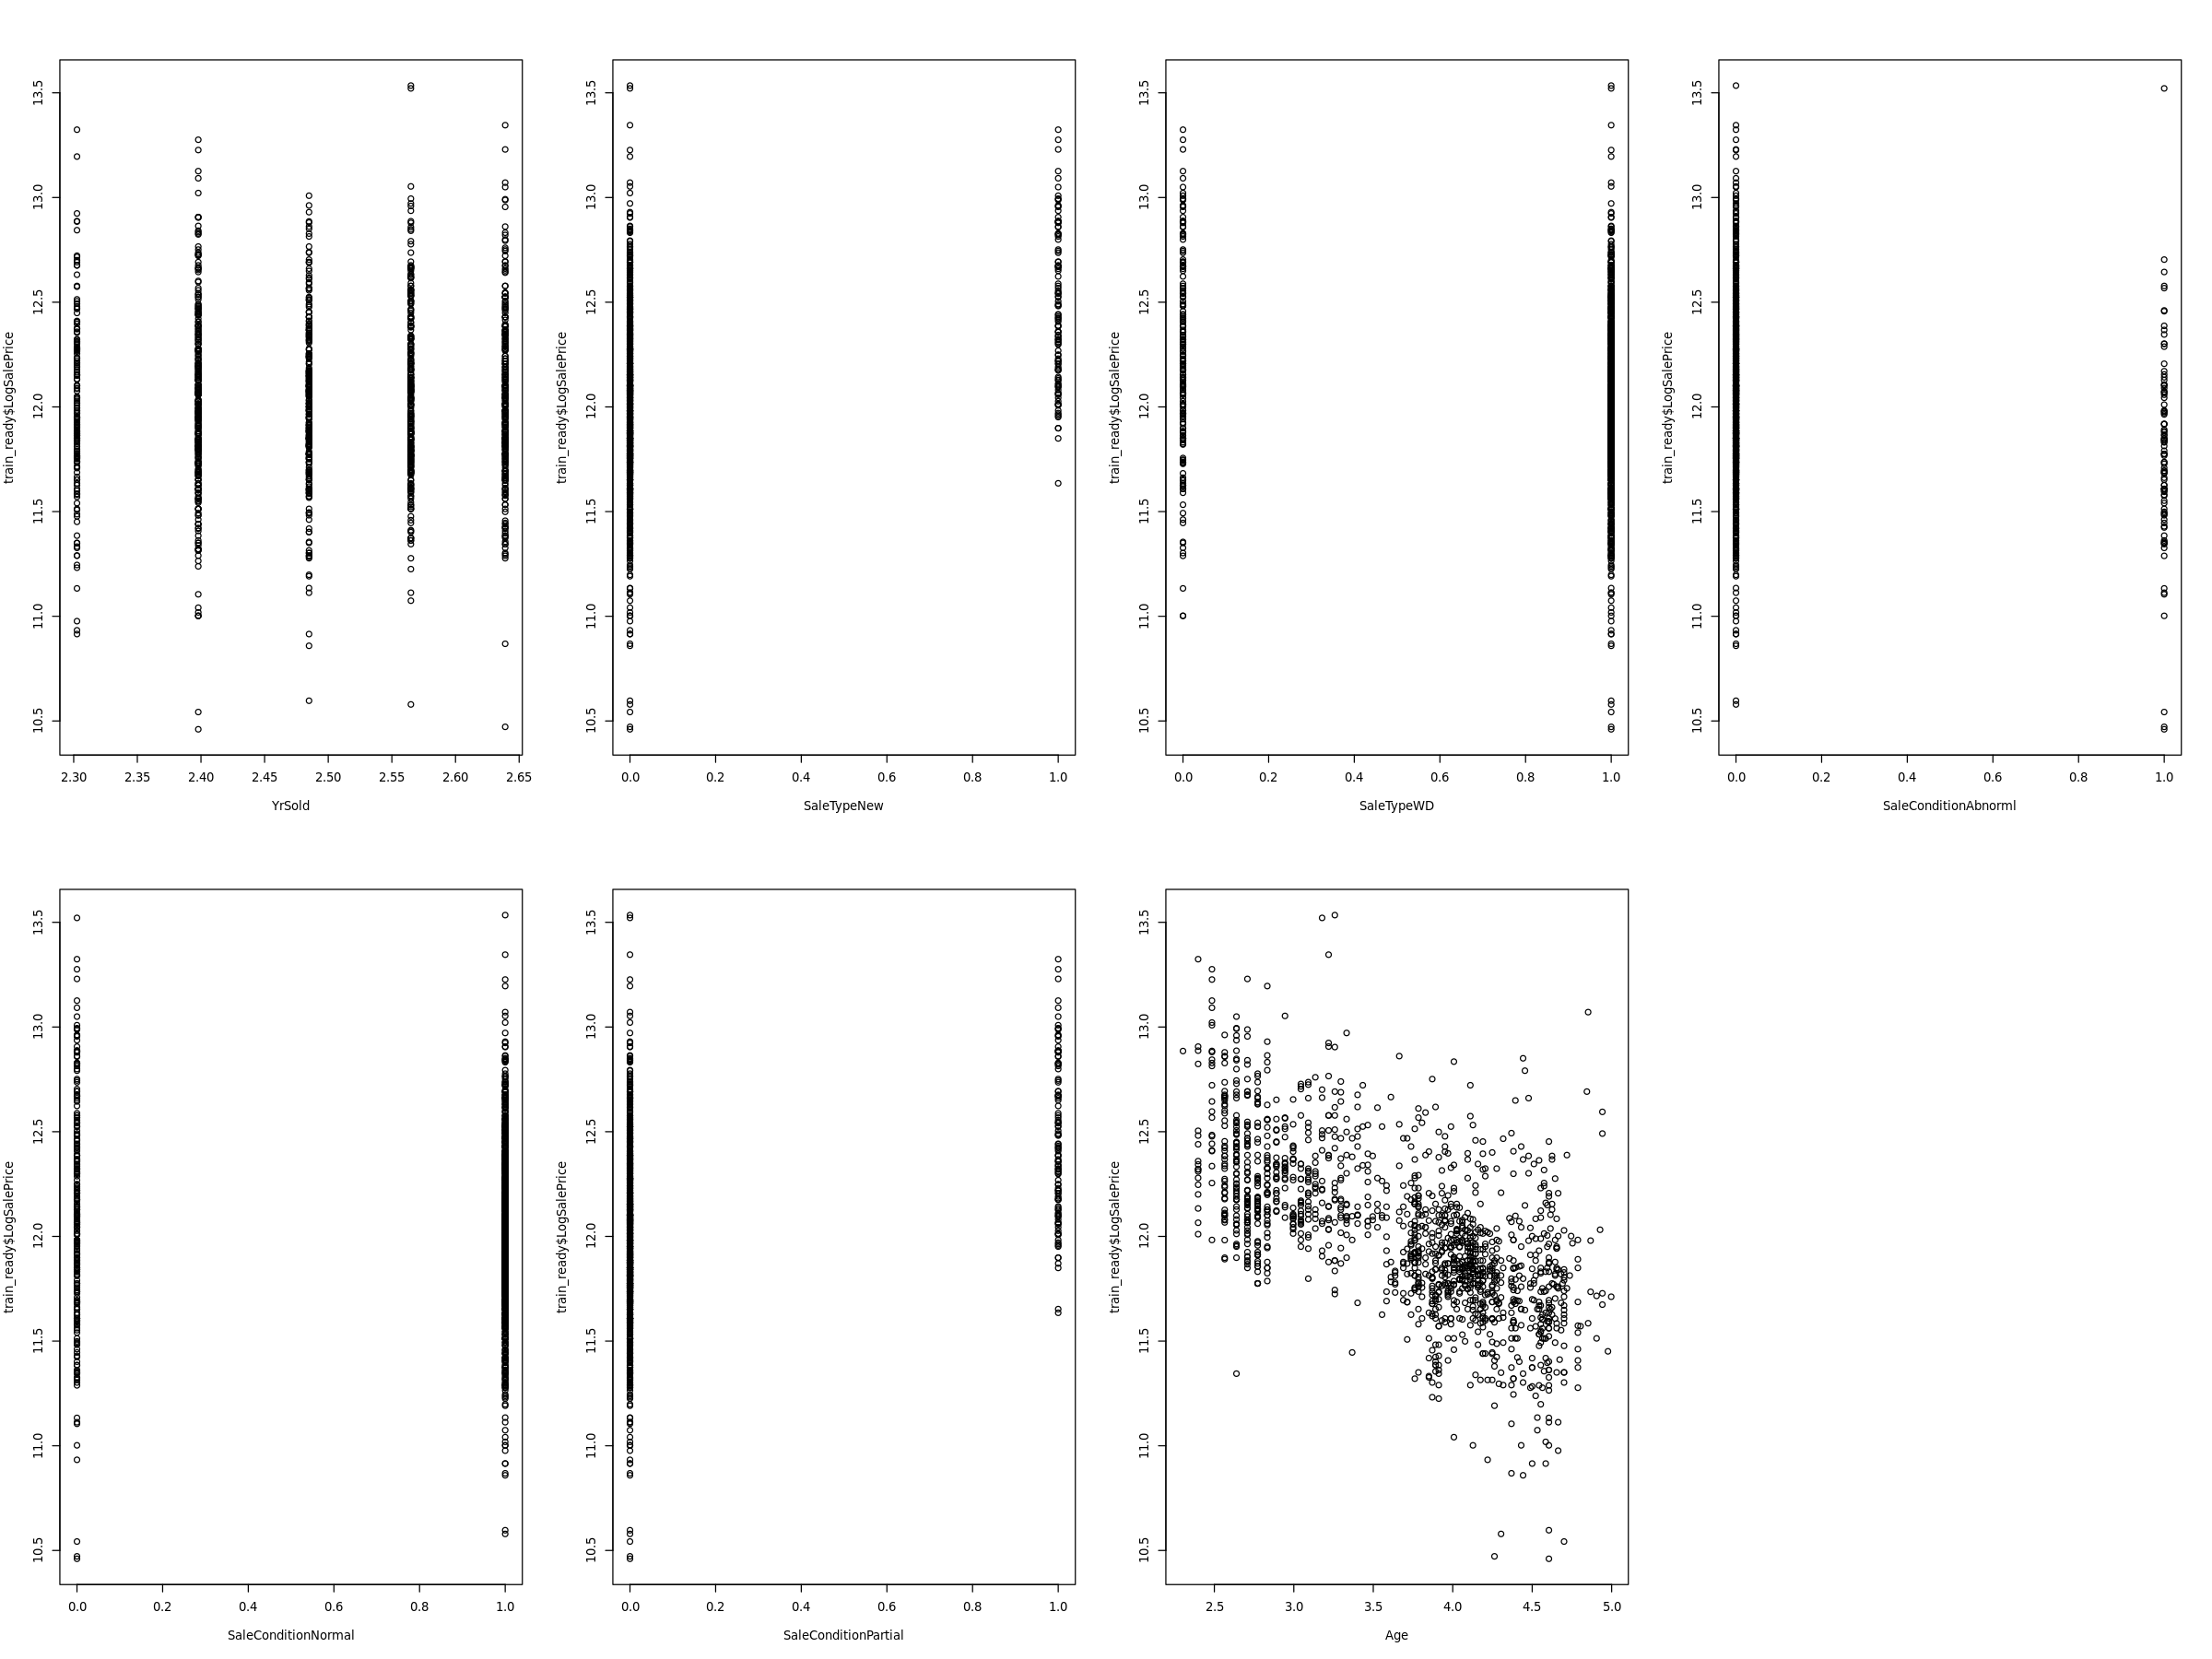

In [22]:
## EDA of response
train_df %>% 
  summarise(mean_sale = mean(SalePrice), 
            median_sale = median(SalePrice),
            sd_sale = sd(SalePrice))

pd1 <- train_df %>% 
  ggplot(aes(SalePrice)) + geom_histogram()

## check if log transformation would make it more resemble to normal distribution
pd2 <- train_df %>% 
  ggplot(aes(log(SalePrice))) + geom_histogram()

grid.arrange(pd1, pd2, nrow = 1)

## looking for potential "outliners", plot all the variables against LogSalePrice, 8 plot each time

## change plot size in Jupyter
options(repr.plot.width=20, repr.plot.height=15)

i <- 2
while (i <= 105 - 7)
{
  par(mfrow = c(2, 4))
  # par(mar=c(1, 1, 1, 1))

  for (j in i:(i + 7))
  {
    if (j > 104) break
    plot(train_ready[[j]], train_ready$LogSalePrice,
     xlab = train_ready[j] %>% names())
  }
  i <- i + 8
}

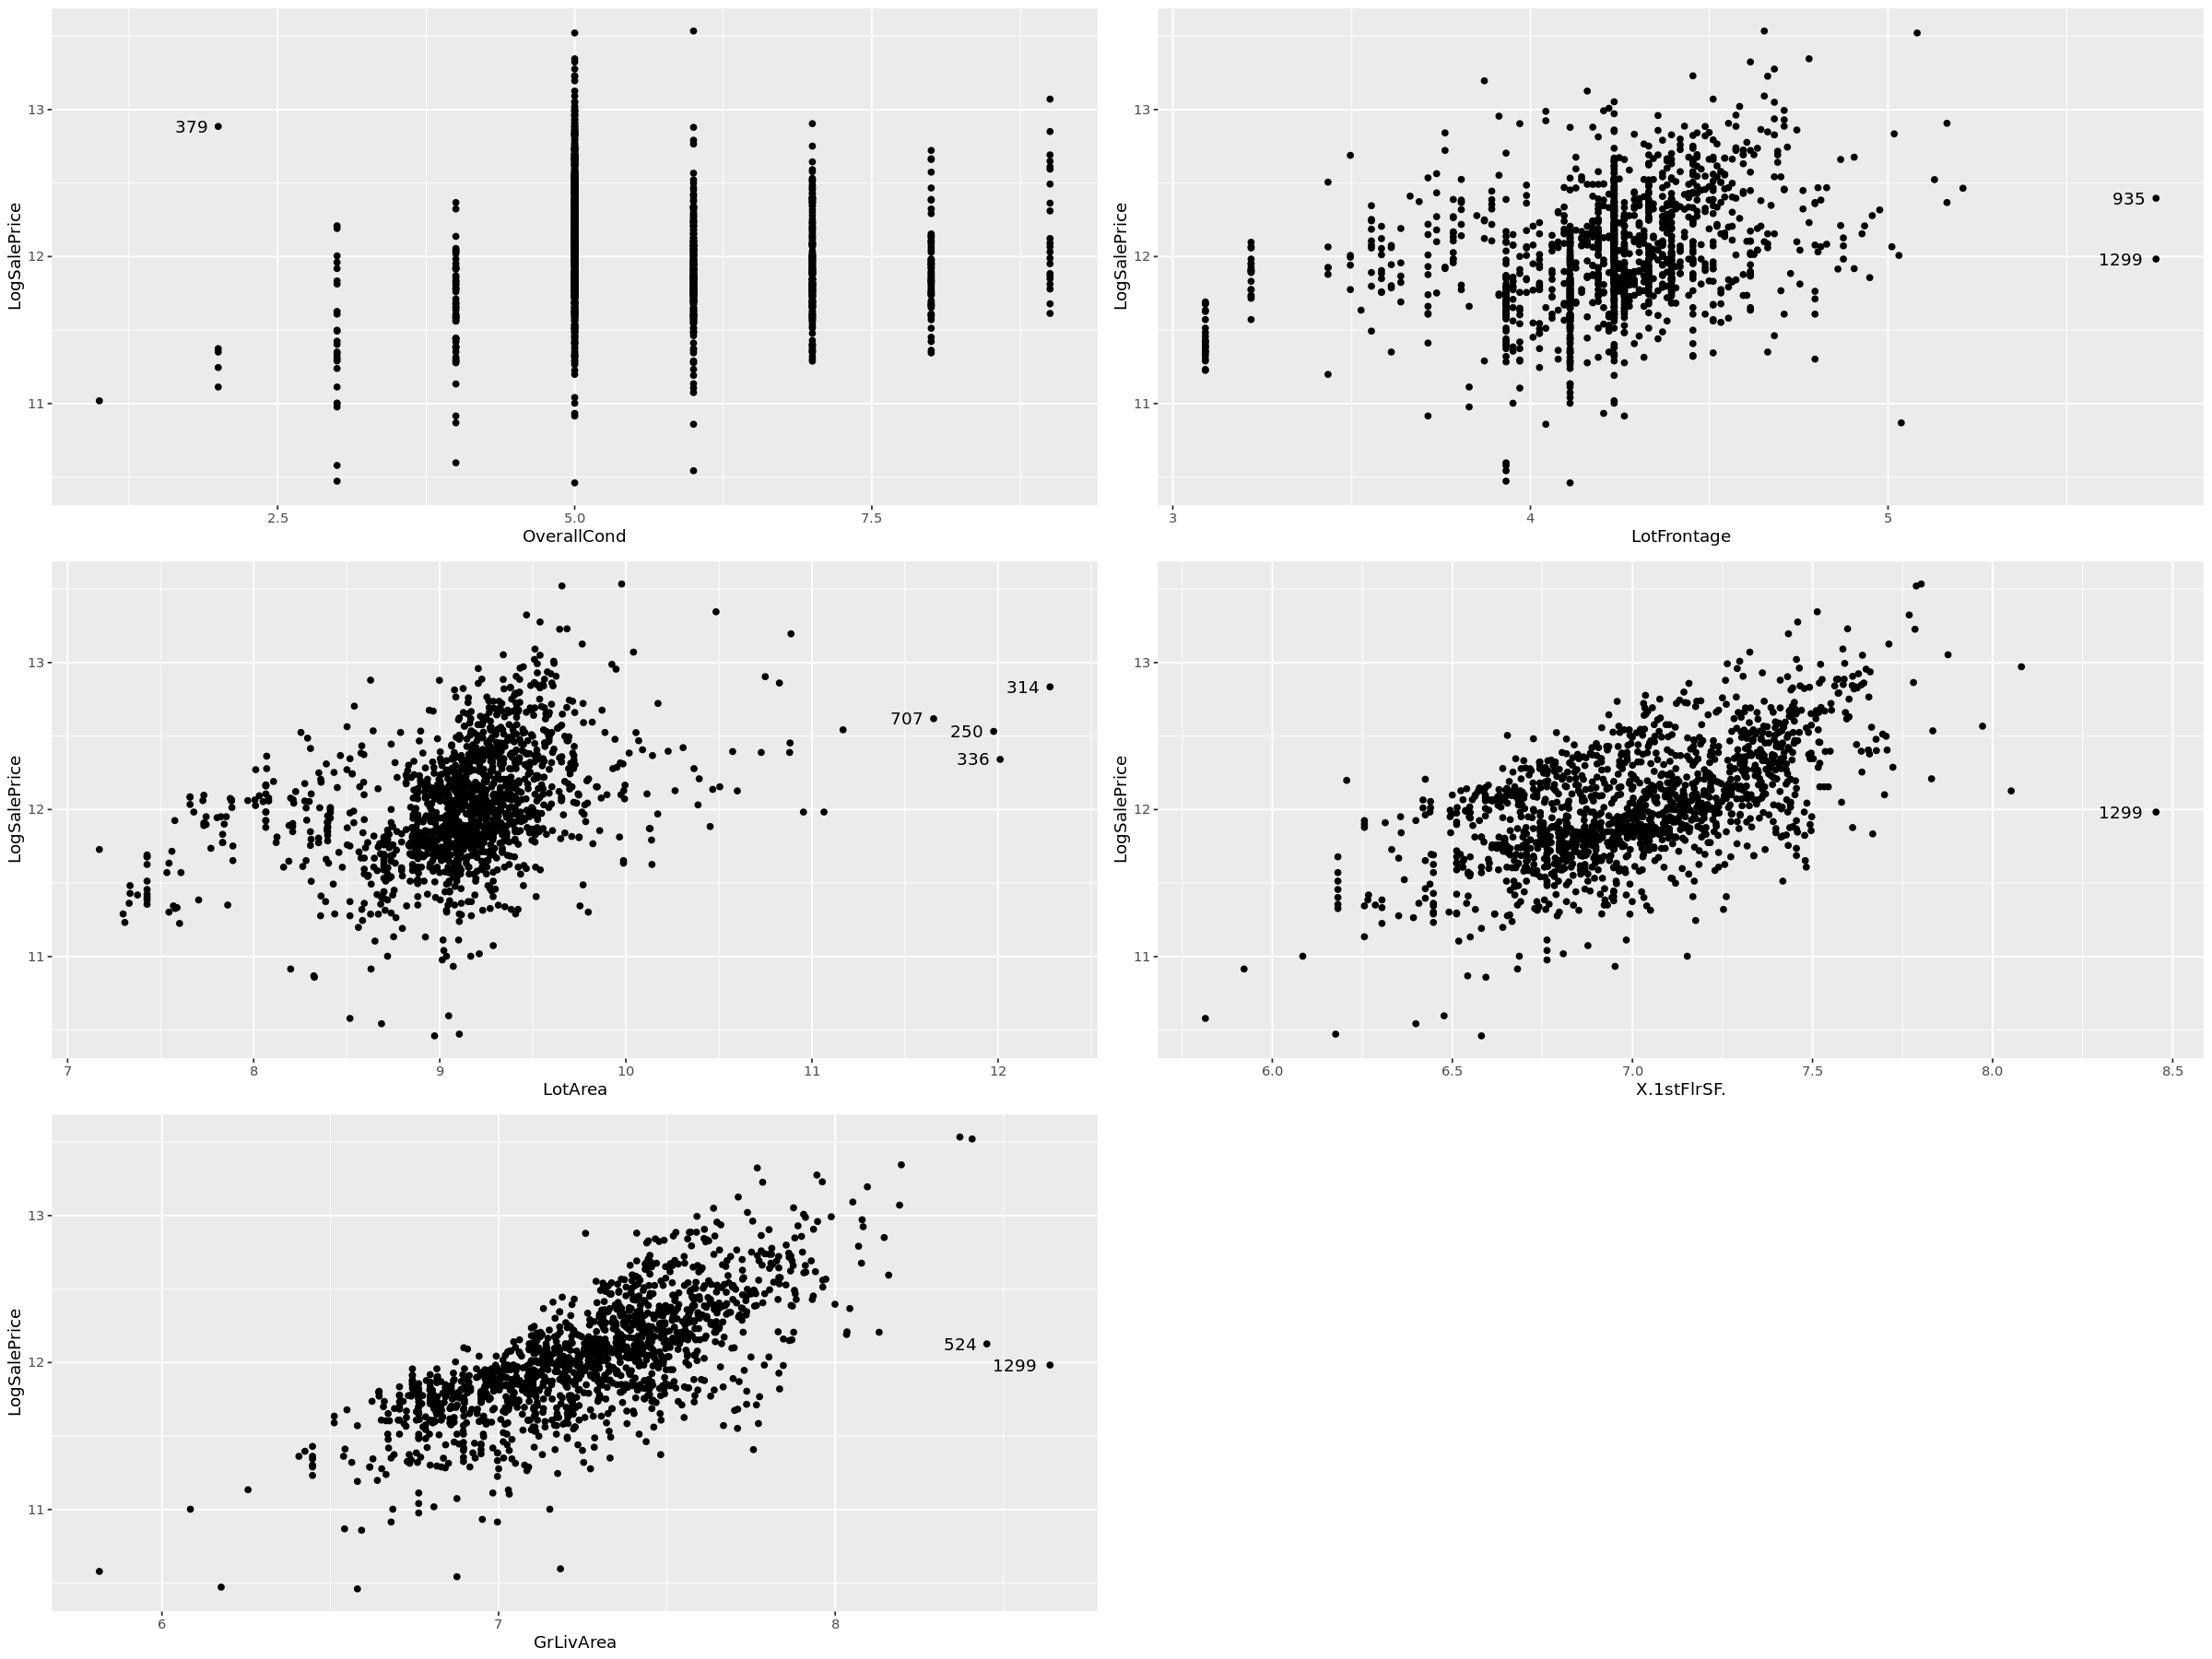

In [23]:
# According to these above plots, 6 viariables may contain some "outliners": OverallCond, LotFrontage, LotArea, X.1stFlrSF, GrLivArea, labeld in the figures with Id# 
p1 <- ggplot(train_ready, aes(OverallCond, LogSalePrice)) + 
  geom_point() +  
  geom_text(aes(label = ifelse(LogSalePrice > 12.5 & OverallCond < 2.5, Id, '')),
            hjust = 1.3)

p2 <- ggplot(train_ready, aes(LotFrontage, LogSalePrice, label = Id)) + 
  geom_point() +
  geom_text(aes(label = ifelse(LotFrontage > 5.5, Id, '')),
            hjust = 1.3)

p3 <- ggplot(train_ready, aes(LotArea, LogSalePrice, label = Id)) + 
  geom_point() +
  geom_text(aes(label = ifelse(LotArea > 11.5, Id, '')),
            hjust = 1.3)

p4 <- ggplot(train_ready, aes(X.1stFlrSF., LogSalePrice, label = Id)) + 
  geom_point() +
  geom_text(aes(label = ifelse(X.1stFlrSF. > 8.25, Id, '')),
            hjust = 1.3)

p5 <- ggplot(train_ready, aes(GrLivArea, LogSalePrice, label = Id)) + 
  geom_point() +
  geom_text(aes(label = ifelse(LogSalePrice < 12.5 & GrLivArea > 8.2, Id, '')),
            hjust = 1.3)

grid.arrange(p1, p2, p3 ,p4, p5, nrow = 3)

In [24]:
## remove these outliners from training set
train_ready <- train_ready %>%
  filter (!Id %in% c(379, 935, 1299, 707, 250, 336, 314, 524)) %>% 
  select(-Id)

# now the train and test sets are ready for model fit
dim(train_ready)
dim(test_ready)

[1] 1452  105

[1] 1459  104

# **Part 2, Model Fitting**

Stochastic Gradient Boosting 

1452 samples
 104 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1306, 1308, 1307, 1308, 1307, 1307, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared   MAE       
  1                   50      0.1704755  0.8428984  0.12049311
  1                  100      0.1396057  0.8796198  0.09964205
  1                  150      0.1303557  0.8928121  0.09364239
  2                   50      0.1432750  0.8779905  0.10110731
  2                  100      0.1256632  0.9002463  0.08979914
  2                  150      0.1220297  0.9057553  0.08686795
  3                   50      0.1349473  0.8879043  0.09550998
  3                  100      0.1236729  0.9032958  0.08795252
  3                  150      0.1217692  0.9062883  0.08630602

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a

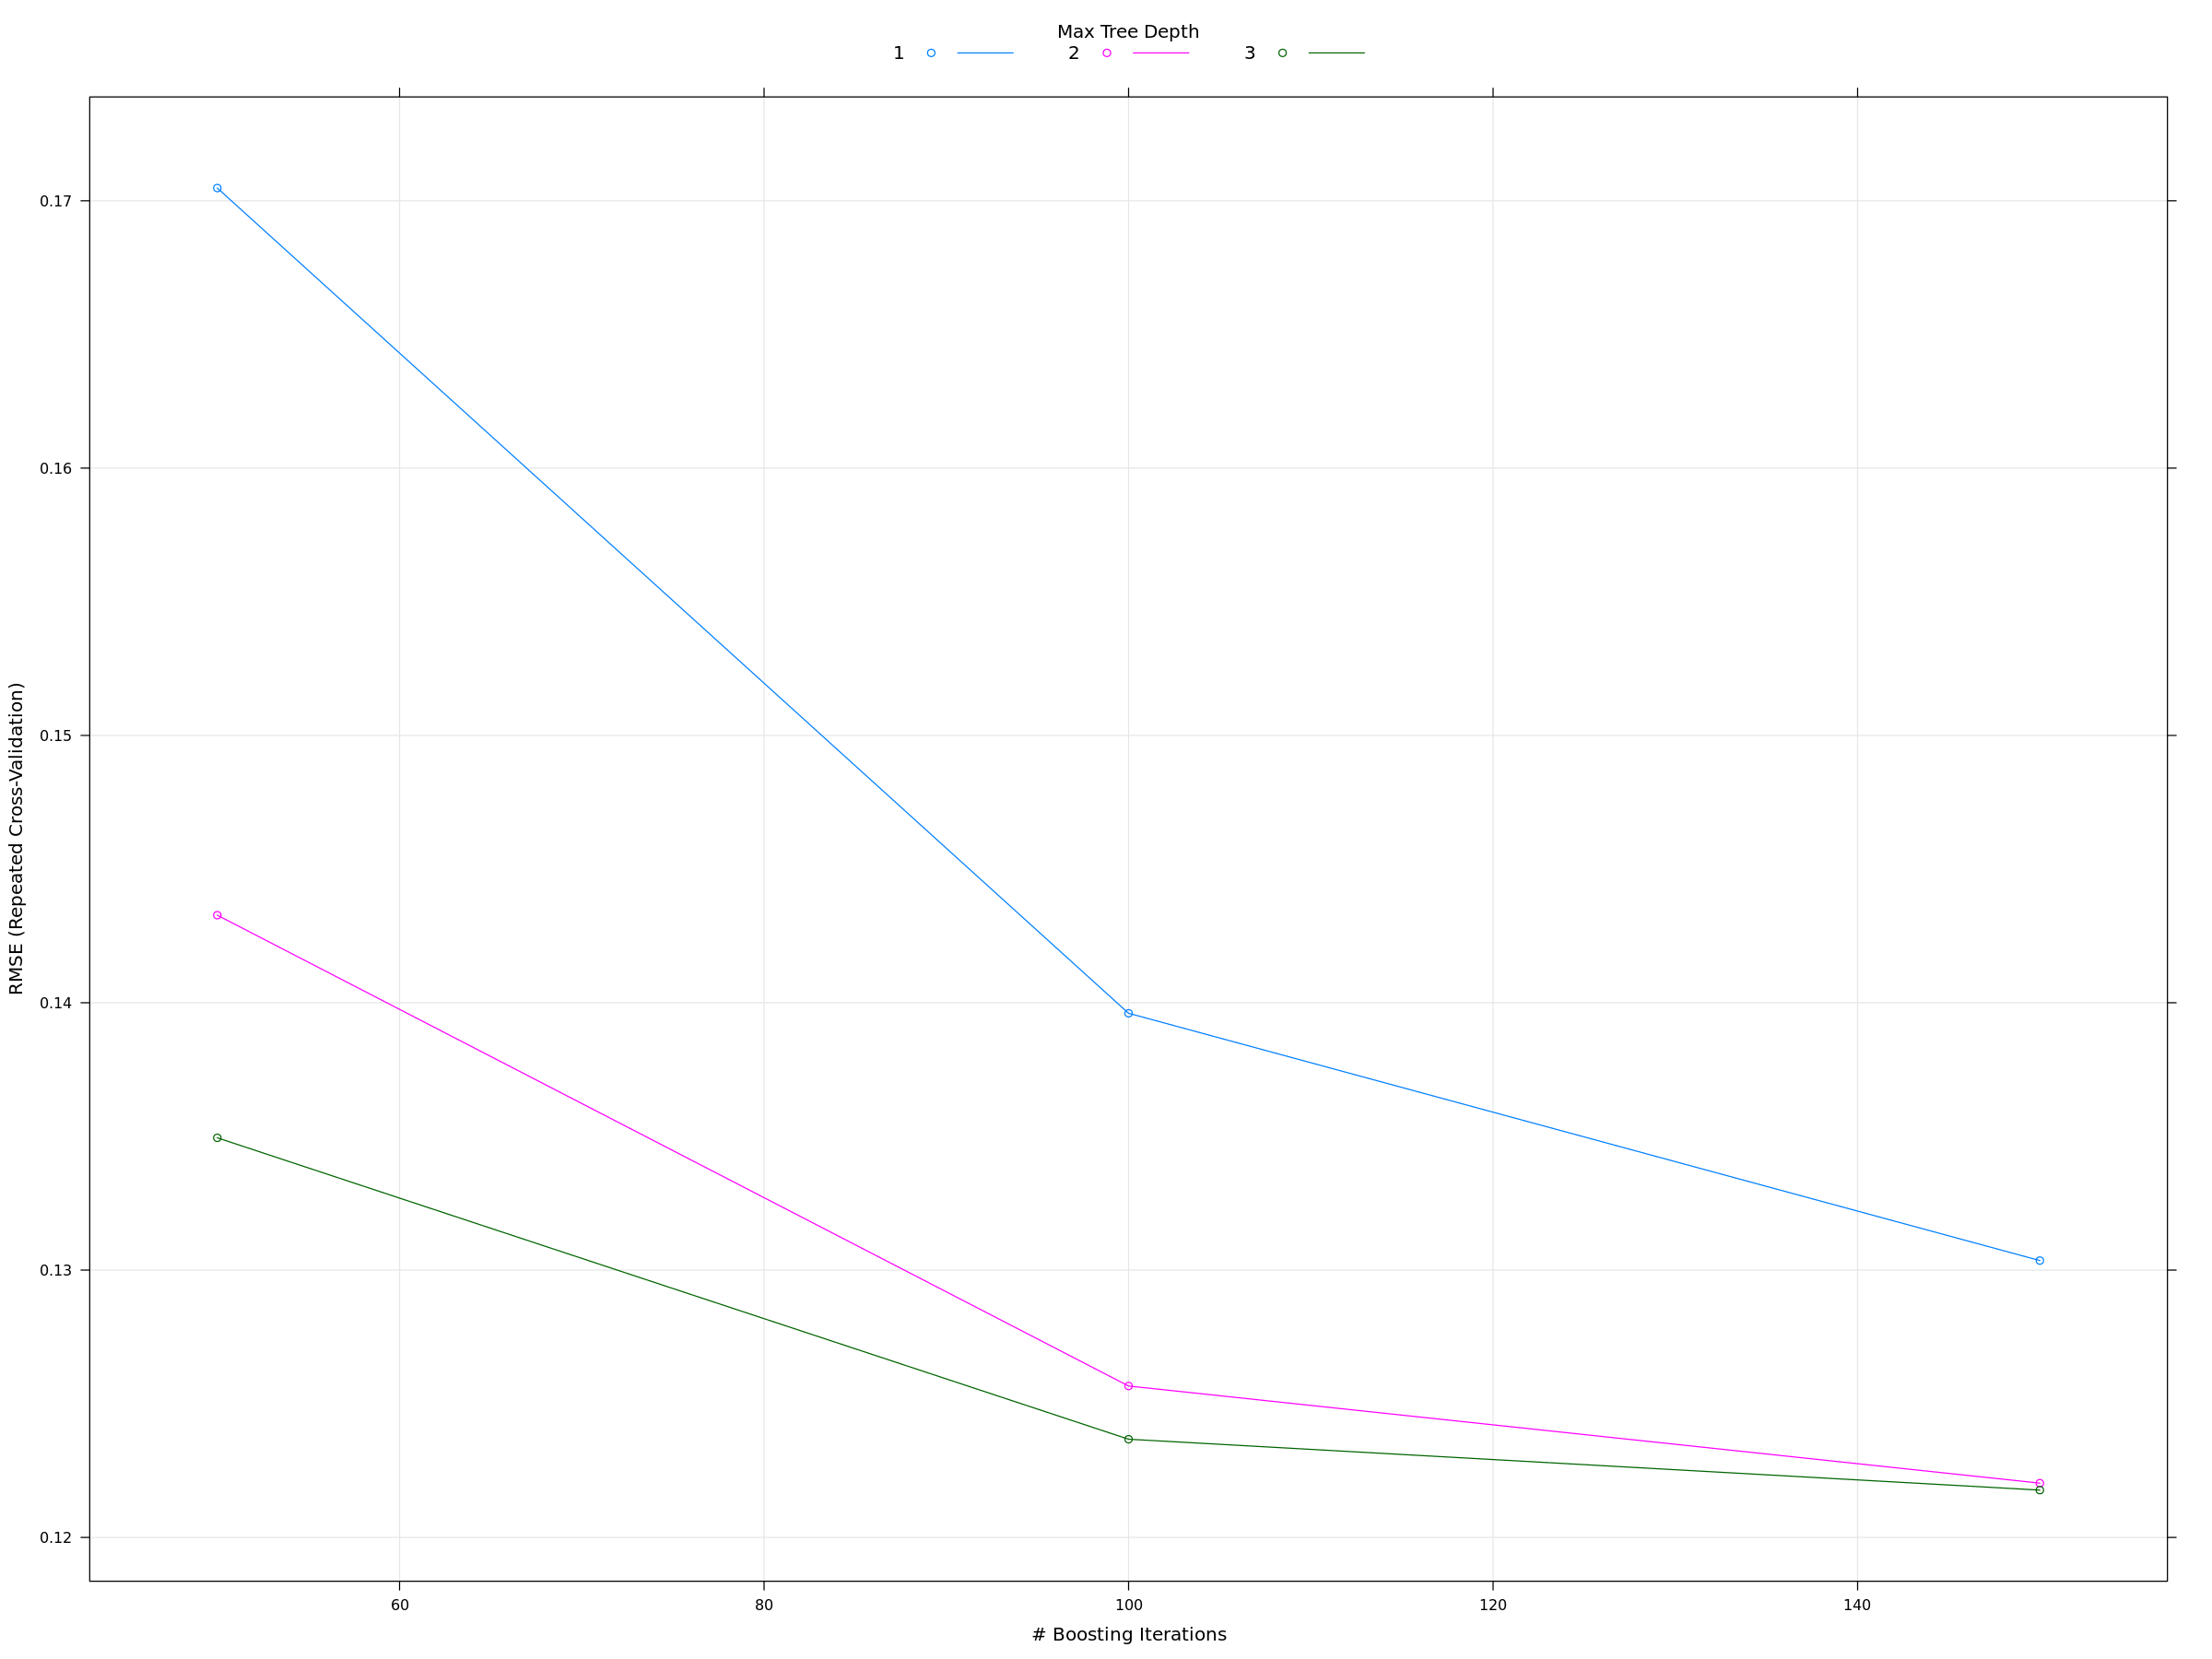

In [25]:
## gbm, intial run
set.seed(123)

myControl = trainControl(method = "repeatedcv",
                         number = 10,
                         repeats = 5)

gbm_model_int <- train(y = train_ready$LogSalePrice,
             x = train_ready %>% select(-LogSalePrice),
             method = "gbm",
             trControl = myControl,
             verbose = FALSE)
gbm_model_int

## change plot size in Jupyter
options(repr.plot.width=16, repr.plot.height=12)
plot(gbm_model_int)

Stochastic Gradient Boosting 

1452 samples
 104 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1307, 1306, 1306, 1308, 1307, 1307, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1184127  0.9117827  0.08285855

Tuning parameter 'n.trees' was held constant at a value of 500
Tuning

Tuning parameter 'shrinkage' was held constant at a value of 0.05

Tuning parameter 'n.minobsinnode' was held constant at a value of 15

,var,rel.inf
,<fct>,<dbl>
OverallQual,OverallQual,35.3265439
GrLivArea,GrLivArea,18.2985792
TotalBsmtSF,TotalBsmtSF,6.0998721
KitchenQual,KitchenQual,4.3806028
Age,Age,3.5294123
GarageArea,GarageArea,2.6547379
ExterQual,ExterQual,2.5867552
GarageCars,GarageCars,2.5733997
LotArea,LotArea,2.5640035


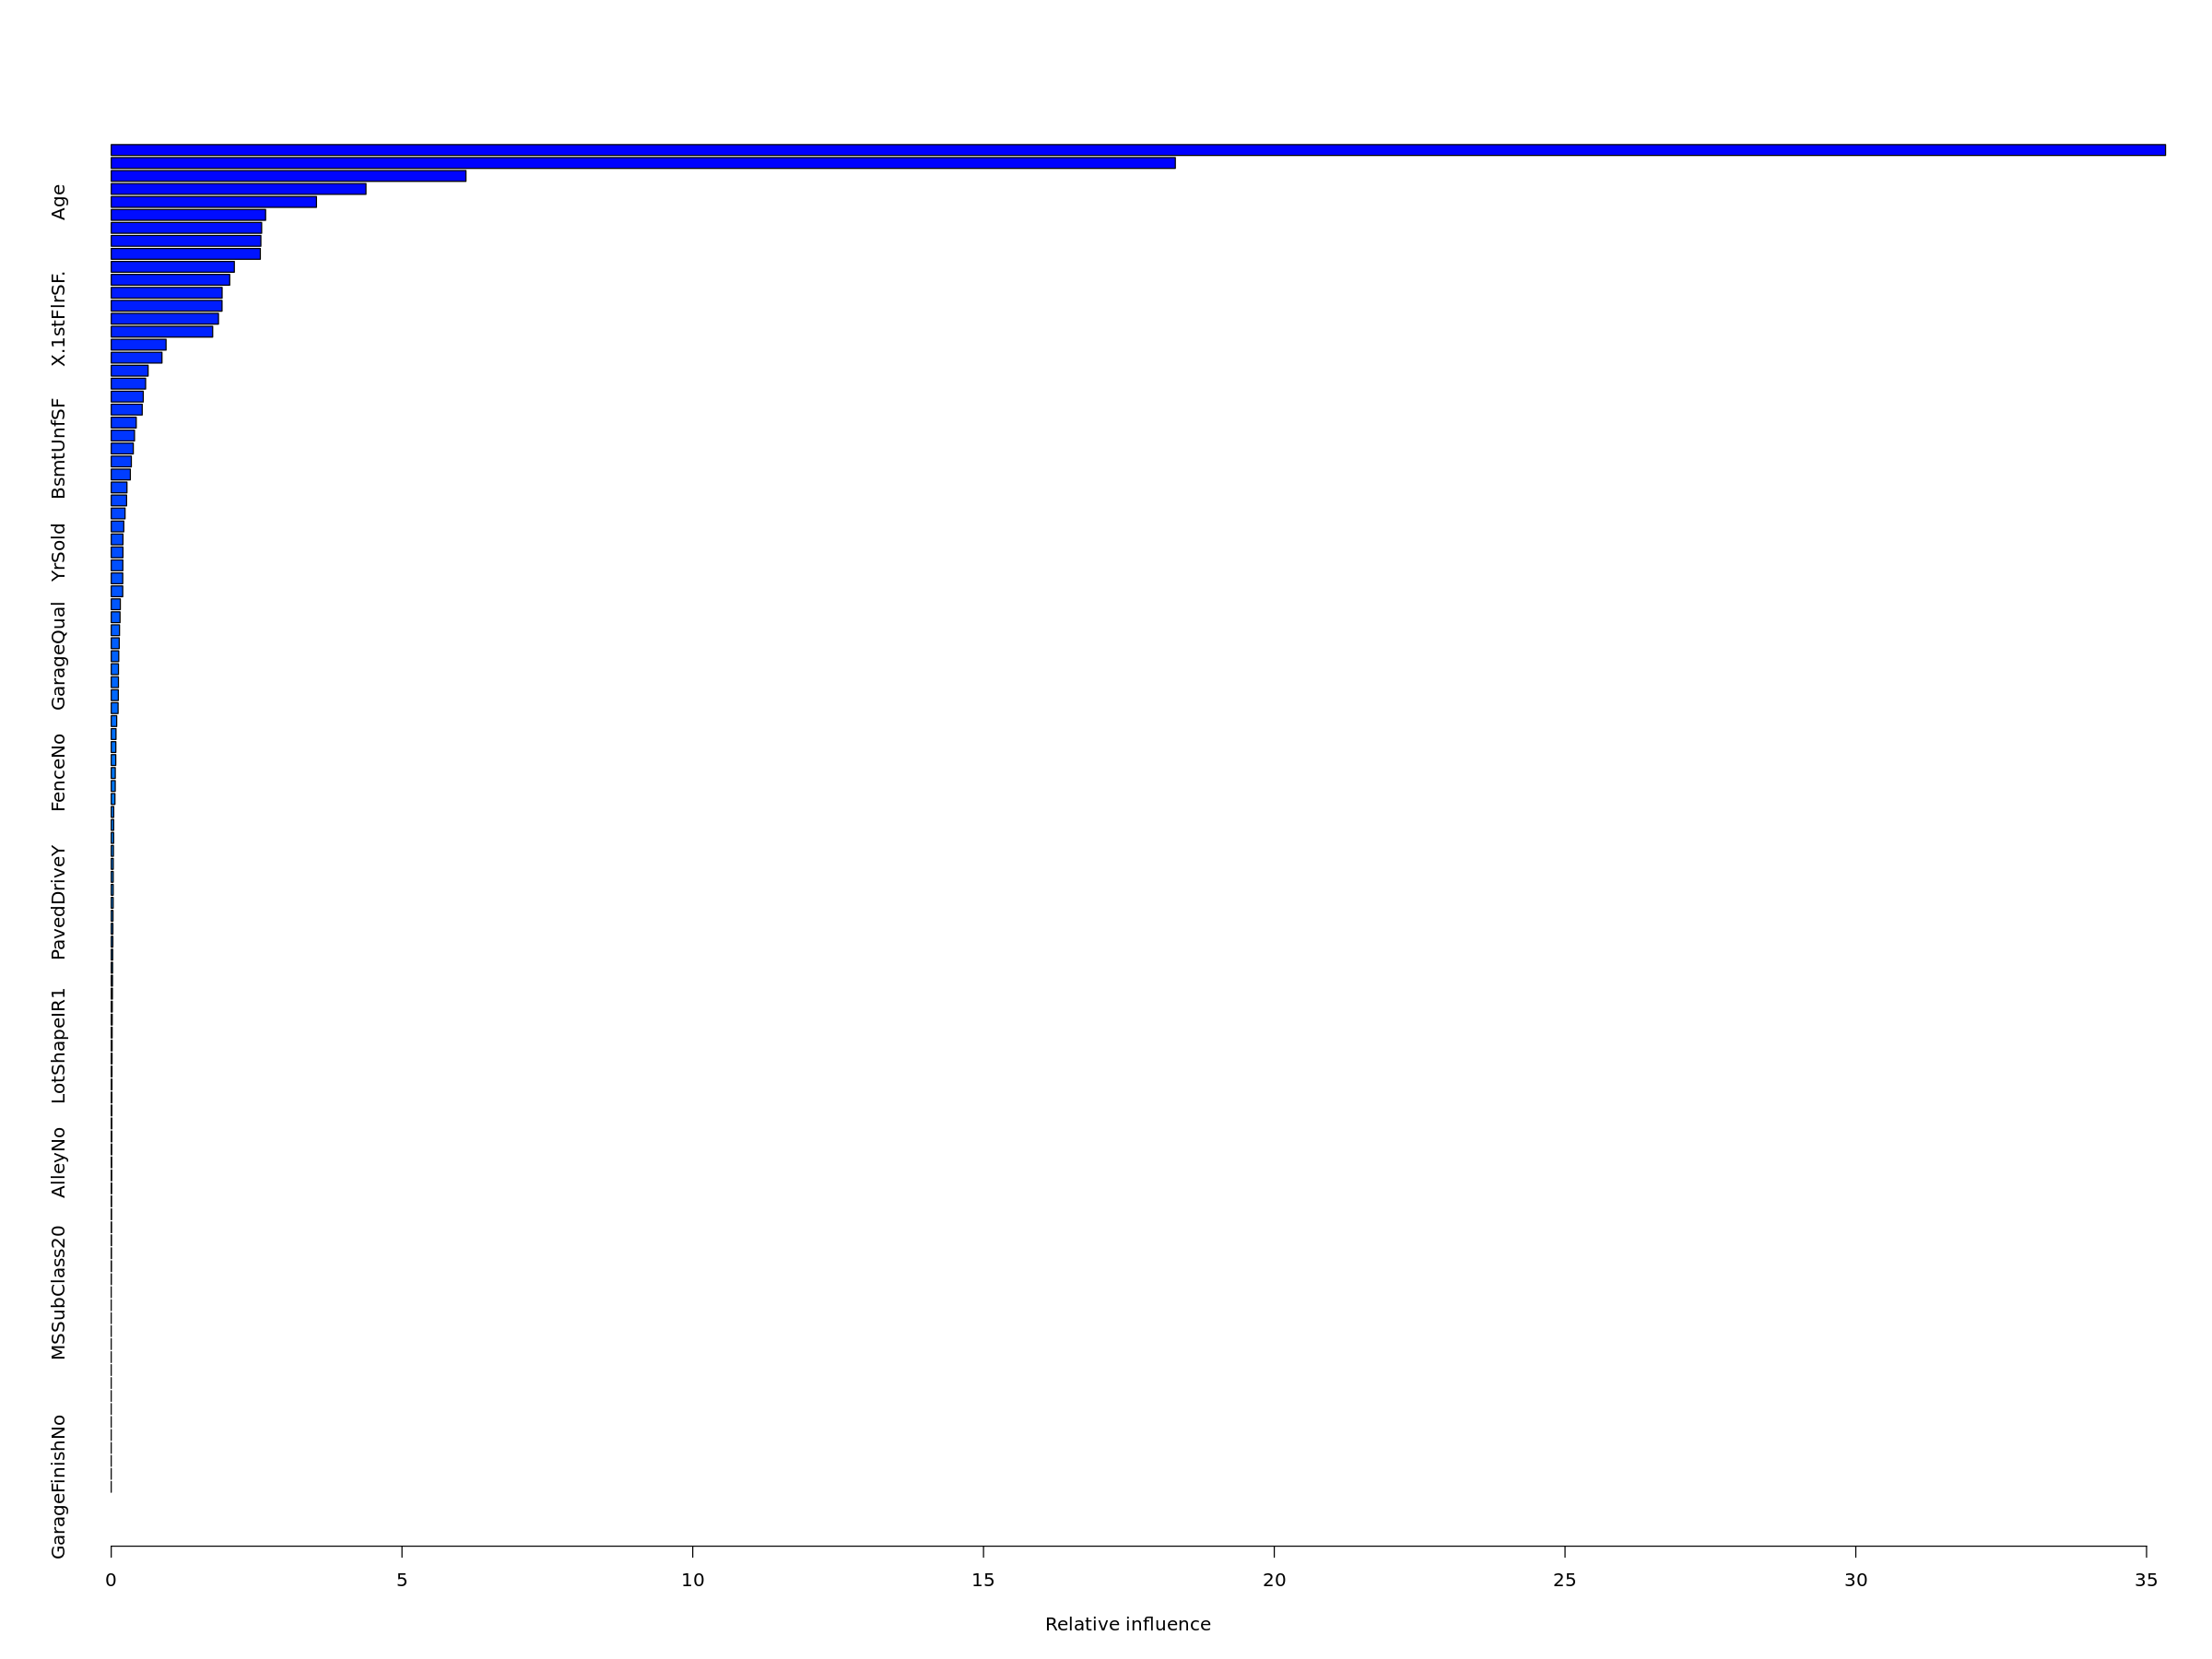

In [26]:
## tuning n.trees, interaction.depth, bag.fraction, n.minobsinnode, shrinkage
## Based on the initial results, more tree and more interaction decrease RMSE, thus first tune these two, while holding n.minobsinnode, shrinkage constant
## Final prameters: n.trees = 500, interaction = 3, n.minobsinnode = 15, shrinkage = 0.1
gbm_model <- train(y = train_ready$LogSalePrice,
             x = train_ready %>% select(-LogSalePrice),
             method = "gbm",
             trControl = myControl,
             verbose = FALSE,
             tuneGrid = expand.grid(n.trees = 500,
                                    interaction.depth = 3,
                                    n.minobsinnode = 15,
                                    shrinkage = 0.05))
gbm_model

gbm_model %>% summary()

glmnet 

1452 samples
 104 predictor

Pre-processing: centered (104), scaled (104) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1307, 1306, 1307, 1308, 1307, 1306, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared   MAE       
  0.10   0.0006555019  0.1187077  0.9114500  0.08410280
  0.10   0.0065550192  0.1181013  0.9122982  0.08428967
  0.10   0.0655501923  0.1229872  0.9078339  0.08778055
  0.55   0.0006555019  0.1182136  0.9121193  0.08408529
  0.55   0.0065550192  0.1186279  0.9118823  0.08509020
  0.55   0.0655501923  0.1498008  0.8795783  0.10551122
  1.00   0.0006555019  0.1181609  0.9122100  0.08429463
  1.00   0.0065550192  0.1202196  0.9100889  0.08614308
  1.00   0.0655501923  0.1775602  0.8453544  0.12808345

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.006555019.

glmnet 

1452 samples
 104 predictor

Pre-processing: centered (104), scaled (104) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1308, 1308, 1306, 1307, 1306, 1306, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1183813  0.9118548  0.08446112

Tuning parameter 'alpha' was held constant at a value of 0.19
Tuning
 parameter 'lambda' was held constant at a value of 0.007

glmnet variable importance

  only 20 most important variables shown (out of 104)

                     Overall
GrLivArea             100.00
OverallQual            71.47
OverallCond            41.01
X.1stFlrSF.            38.17
LotArea                33.84
Age                    31.62
BsmtFinSF1             24.49
GarageCars             23.42
FunctionalTyp          17.10
HalfBath               16.02
SaleTypeNew            15.92
BsmtQual               15.70
BsmtFullBath           15.55
Fireplaces             15.54
KitchenQual            15.40
Condition1Norm         14.88
FullBath               14.53
BsmtExposure           12.47
MSZoningRL             12.02
SaleConditionAbnorml   11.05

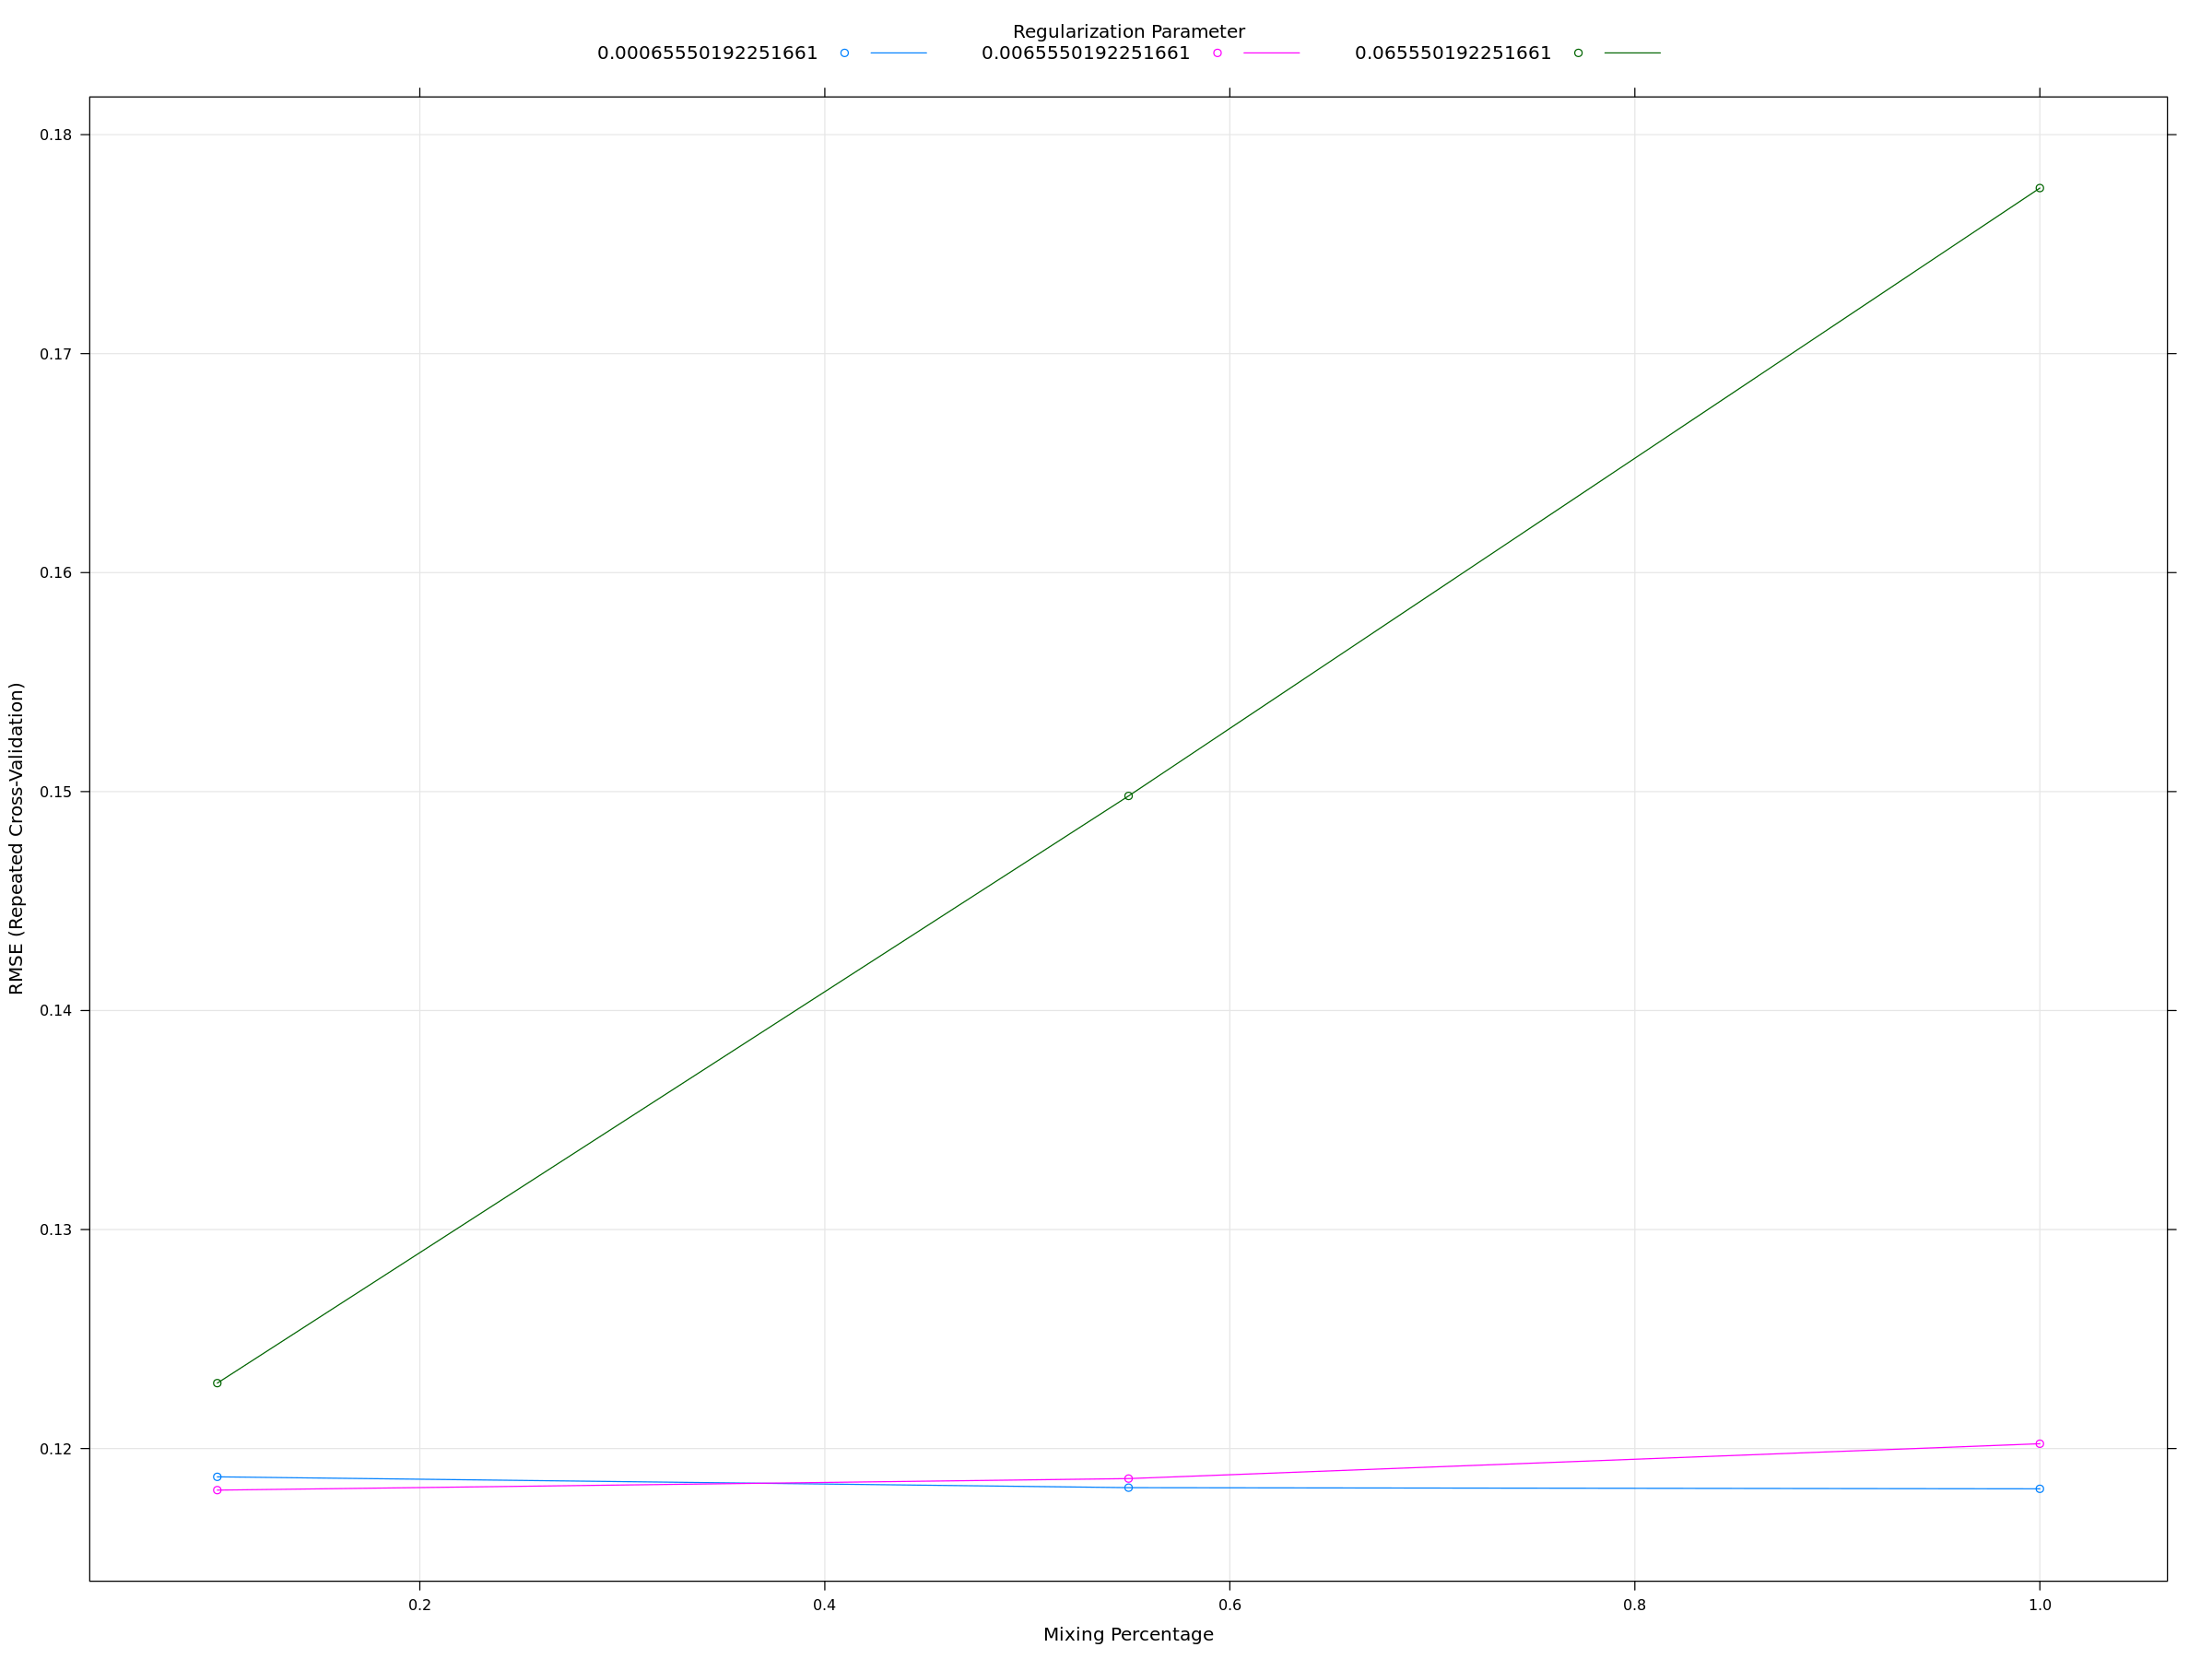

In [30]:
## glmnet initial run
glmnet_model_int <- train(y = train_ready$LogSalePrice,
                  x = train_ready %>% select(-LogSalePrice),
                  method = "glmnet",
                  preProcess = c("center", "scale"),
                  trControl = myControl)

plot(glmnet_model_int)
glmnet_model_int

## Final tuning, alpha = 0.19, lambda = 0.007
glmnet_model <- train(y = train_ready$LogSalePrice,
                 x = train_ready %>% select(-LogSalePrice),
                 method = "glmnet",
                 preProcess = c("center", "scale"),
                 trControl = myControl,
                 tuneGrid = expand.grid(alpha = 0.19,
                                        lambda = 0.007))
glmnet_model
varImp(glmnet_model)

In [31]:
## Final tuning for glmnet, alpha = 0.19, lambda = 0.007
glmnet_model <- train(y = train_ready$LogSalePrice,
                 x = train_ready %>% select(-LogSalePrice),
                 method = "glmnet",
                 preProcess = c("center", "scale"),
                 trControl = myControl,
                 tuneGrid = expand.grid(alpha = 0.19,
                                        lambda = 0.007))
glmnet_model
varImp(glmnet_model)

glmnet 

1452 samples
 104 predictor

Pre-processing: centered (104), scaled (104) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1306, 1307, 1307, 1304, 1306, 1307, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1185562  0.9123634  0.08453514

Tuning parameter 'alpha' was held constant at a value of 0.19
Tuning
 parameter 'lambda' was held constant at a value of 0.007

glmnet variable importance

  only 20 most important variables shown (out of 104)

                     Overall
GrLivArea             100.00
OverallQual            71.47
OverallCond            41.01
X.1stFlrSF.            38.17
LotArea                33.84
Age                    31.62
BsmtFinSF1             24.49
GarageCars             23.42
FunctionalTyp          17.10
HalfBath               16.02
SaleTypeNew            15.92
BsmtQual               15.70
BsmtFullBath           15.55
Fireplaces             15.54
KitchenQual            15.40
Condition1Norm         14.88
FullBath               14.53
BsmtExposure           12.47
MSZoningRL             12.02
SaleConditionAbnorml   11.05

# **Part 3, Model Performance**

In [32]:
## Customized functions/code for r-square, rmse, and cross-validation for stacked model
rSquared <- function(y, ypred)
{
  totalSS <- (y - mean(y)) ^ 2 %>% sum()
  residualSS <- (y - ypred) ^ 2 %>% sum()
  rsq <- 1 - residualSS/totalSS
  return(rsq)
} 

rmse <- function(actual, fitted) sqrt(mean((actual - fitted)^2))

pred_tr1 <- predict(gbm_model, newdata = train_ready, n.tree = 500)
pred_tr2 <- predict(glmnet_model, newdata = train_ready)
pred_tr <- (pred_tr1 + pred_tr2)/2

## cross validation for out-of-sample RMSE and R-squared, 10-fold
fold <- 10
cv_ready <- cut(seq(1, nrow(train_ready)), breaks = fold, labels = FALSE)

set.seed(123)
rmse_cv <- c()
R_squr_cv <- c()
for (i in 1:fold) 
{
  train_set <- train_ready[cv_ready != i, ]
  test_set <- train_ready[cv_ready == i, ]
  
  gbm_model_cv <- train(y = train_set$LogSalePrice,
             x = train_set %>% select(-LogSalePrice),
             method = "gbm",
             verbose = FALSE,
             tuneGrid = expand.grid(n.trees = 500,
                                    interaction.depth = 3,
                                    n.minobsinnode = 15,
                                    shrinkage = 0.05))
  
  glmnet_model_cv <- glmnet_model <- train(y = train_set$LogSalePrice,
                 x = train_set %>% select(-LogSalePrice),
                 method = "glmnet",
                 preProcess = c("center", "scale"),
                 tuneGrid = expand.grid(alpha = 0.19,
                                        lambda = 0.007))
  
  pred1 <- predict(gbm_model_cv, newdata = test_set, n.tree = 500)
  pred2 <- predict(glmnet_model_cv, newdata = test_set)
  avg <- (pred1 + pred2)/2
  rmse_cv[i] <- rmse(test_set$LogSalePrice, avg)
  R_squr_cv[i] <- rSquared(test_set$LogSalePrice, avg)
}

In [ ]:
## in-sample RMSE,  R-squared
data.frame(in_RMSE = rmse(train_ready$LogSalePrice, pred_tr),
           in_R_square = rSquared(train_ready$LogSalePrice, pred_tr))

## estimate of out-of-sample metrices
data.frame(out_RMSE = mean(rmse_cv), out_R_square = mean(R_squr_cv))

## **Part 4, Output for Submission**

In [ ]:
## Prepare for submission gbm
sub <- predict(gbm_model, newdata = test_ready, n.tree = 150)
sub <- data.frame(ID = test_df$Id, SalePrice = exp(sub))
write.csv(sub, "sub_test_gbm.csv", row.names = FALSE)

## Prepare for submission glm
sub <- predict(glmnet_model, newdata = test_ready)
sub <- data.frame(ID = test_df$Id, SalePrice = exp(sub))
write.csv(sub, "sub_test_glm.csv", row.names = FALSE)

## average, stacked model
pred1 <- predict(gbm_model, newdata = test_ready, n.tree = 500)
pred2 <- predict(glmnet_model, newdata = test_ready)
pred <- (pred1 + pred2) / 2
sub <- data.frame(ID = test_df$Id, SalePrice = exp(pred))
write.csv(sub, "sub_test_avg.csv", row.names = FALSE)